# Initial Config

In [2]:
# ================================================================================
# IMPORTS
# ================================================================================
import json
import os
import time
import warnings
import requests
import ipaddress
from dotenv import load_dotenv
from opensearchpy import OpenSearch
from opensearch_py_ml.ml_commons import MLCommonClient

# ================================================================================
# CONFIGURATION AND SETUP
# ================================================================================

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", message="Unverified HTTPS request")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="TracerWarning: torch.tensor")
warnings.filterwarnings("ignore", message="using SSL with verify_certs=False is insecure.")

# Load environment variables from .env file
load_dotenv(".env")

# OpenSearch cluster configuration
HOST = 'localhost'
DEEPSEEK_MODEL = 'deepseek-chat'  # Change to your desired DeepSeek model if needed
PORT = 9200
CLUSTER_URL = {'host': HOST, 'port': PORT}
DEFAULT_USERNAME = 'admin'
DEFAULT_PASSWORD = 'Developer@123'

# ================================================================================
# HELPER FUNCTIONS
# ================================================================================

def get_os_client(cluster_url=CLUSTER_URL, username=DEFAULT_USERNAME, password=DEFAULT_PASSWORD):
    """
    Create and return an OpenSearch client with SSL configuration.
    
    Args:
        cluster_url (dict): Dictionary containing host and port information
        username (str): OpenSearch username for authentication
        password (str): OpenSearch password for authentication
        
    Returns:
        OpenSearch: Configured OpenSearch client instance
    """
    client = OpenSearch(
        hosts=[cluster_url],
        http_auth=(username, password),
        verify_certs=False,
        ssl_assert_hostname=False,
        ssl_show_warn=False,
        use_ssl=True,
        max_retries=10,
        retry_on_timeout=True,
        timeout=300  # Increased timeout to 300 seconds
    )

    return client

# Initialize OS client

In [3]:
# ============================================================================
# STEP 1: INITIALIZE CLIENT AND CONFIGURE CLUSTER
# ============================================================================
print("Step 1: Initializing OpenSearch Client and Configuring Cluster...")
os_client = get_os_client()
ml_client = MLCommonClient(os_client)

# Configure cluster settings to accept DeepSeek as trusted connector endpoint
cluster_settings = {
    "persistent": {
        "plugins.ml_commons.trusted_connector_endpoints_regex": [".*"],
        "plugins.ml_commons.only_run_on_ml_node": "false",
        "plugins.ml_commons.memory_feature_enabled": "true",
        "plugins.ml_commons.connector.private_ip_enabled": "true"
    }
}
os_client.cluster.put_settings(body=cluster_settings)
print("✓ Cluster settings configured successfully\n")

Step 1: Initializing OpenSearch Client and Configuring Cluster...
✓ Cluster settings configured successfully



# Create Embedding model 

In [4]:
# Step 1: Register and deploy the sentence transformer model
print("="*80)
print("Registering and deploying ML model...")
print("="*80)

model_response = ml_client.register_pretrained_model(
    model_name="huggingface/sentence-transformers/msmarco-distilbert-base-tas-b",
    model_version="1.0.1",
    model_format="TORCH_SCRIPT",
    deploy_model=True,
    wait_until_deployed=True
)
embedding_model_id = model_response
print(f"Model ID: {embedding_model_id}")

# Step 2: Wait for model to be fully deployed
print("\nWaiting for model deployment...")
max_wait_time = 300  # 5 minutes max wait
start_time = time.time()

while True:
    model_info = ml_client.get_model_info(embedding_model_id)
    model_state = model_info.get('model_state', 'UNKNOWN')
    print(f"Current model state: {model_state}")
    
    if model_state == 'DEPLOYED':
        print("✓ Model deployed successfully!")
        break
    
    if time.time() - start_time > max_wait_time:
        print("⚠ Warning: Model deployment timeout. Proceeding anyway...")
        break
    
    time.sleep(5)

print(f"\n{'='*80}")
print(f"Model is ready for use")
print(f"{'='*80}")

Registering and deploying ML model...
Model was registered successfully. Model Id:  TYyFMpoBbHKFBFNxtZsE
TYyFMpoBbHKFBFNxtZsE
Task ID: ToyGMpoBbHKFBFNxIJv5
Model was registered successfully. Model Id:  TYyFMpoBbHKFBFNxtZsE
TYyFMpoBbHKFBFNxtZsE
Task ID: ToyGMpoBbHKFBFNxIJv5
Model deployed successfully
Model ID: TYyFMpoBbHKFBFNxtZsE

Waiting for model deployment...
Current model state: DEPLOYED
✓ Model deployed successfully!

Model is ready for use
Model deployed successfully
Model ID: TYyFMpoBbHKFBFNxtZsE

Waiting for model deployment...
Current model state: DEPLOYED
✓ Model deployed successfully!

Model is ready for use


# Create LLM connector

In [5]:
# ============================================================================
# STEP 2: CREATE MODEL GROUP
# ============================================================================
print("Step 2: Initializing OpenSearch Client and Creating Model Group...")
os_client = get_os_client()
model_group_name = f"deepseek_chat_group_{int(time.time())}"
model_group_body = {"name": model_group_name, "description": "Model group for deepseek chat"}
model_group_response = os_client.transport.perform_request('POST', '/_plugins/_ml/model_groups/_register', body=model_group_body)
model_group_id = model_group_response['model_group_id']
print(f"✓ Created model group '{model_group_name}' with ID: {model_group_id}\n")

# ============================================================================
# STEP 3: CREATE DEEPSEEK CONNECTOR
# ============================================================================
print("Step 3: Creating deepseek connector...")
# Use the proper DeepSeek API format with HTTP protocol
connector_body = {
    "name": "DeepSeek Chat",
    "description": "Connector for DeepSeek Chat API",
    "version": "1",
    "protocol": "http",
    "parameters": {
        "endpoint": "api.deepseek.com",
        "model": "deepseek-chat"
    },
    "credential": {
        "deepSeek_key": os.getenv("DEEPSEEK_API_KEY")
    },
    "actions": [
        {
        "action_type": "predict",
        "method": "POST",
        "url": "https://${parameters.endpoint}/v1/chat/completions",
        "headers": {
            "Content-Type": "application/json",
            "Authorization": "Bearer ${credential.deepSeek_key}"
        },
        "request_body": "{ \"model\": \"${parameters.model}\", \"messages\": ${parameters.messages} }"
        }
    ]
    }
connector_response = os_client.transport.perform_request('POST', '/_plugins/_ml/connectors/_create', body=connector_body)
connector_id = connector_response['connector_id']
print(f"✓ Created deepseek connector with ID: {connector_id}\n")

# ============================================================================
# STEP 4: REGISTER AND DEPLOY MODEL
# ============================================================================
print("Step 4: Registering and Deploying Model...")
model_body = {
    "name": "deepseek_chat_model",
    "function_name": "remote",
    "model_group_id": model_group_id,
    "description": f"{DEEPSEEK_MODEL} chat model",
    "connector_id": connector_id,
    "model_format": "TORCH_SCRIPT"
}
model_response = os_client.transport.perform_request('POST', '/_plugins/_ml/models/_register', body=model_body)
llm_model_id = model_response['model_id']
print(f"✓ Registered model with ID: {llm_model_id}")

deploy_body = {"deployment_plan": [{"llm_model_id": llm_model_id, "workers": 1}]}
try:
    os_client.transport.perform_request('POST', f'/_plugins/_ml/models/{llm_model_id}/_deploy', body=deploy_body)
    print("✓ Model deployment initiated")
except Exception as e:
    print(f"⚠ Error deploying model: {e}")

print("⏳ Waiting for model deployment to complete...")
while True:
    status_response = os_client.transport.perform_request('GET', f'/_plugins/_ml/models/{llm_model_id}')
    current_status = status_response['model_state']
    print(f"   Current status: {current_status}")
    if current_status == 'DEPLOYED':
        print("✓ Model deployed successfully!\n")
        break
    elif current_status == 'FAILED':
        print("✗ Model deployment failed!")
    time.sleep(5)

# ============================================================================
# STEP 5: TEST MODEL WITH SAMPLE DATA
# ============================================================================
print("Step 5: Testing Model with Sample Data...")
predict_body = {"parameters": {
    "messages": [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Why is the sky blue?"}
    ]
}}

try:
    predict_response = os_client.transport.perform_request('POST', f'/_plugins/_ml/models/{llm_model_id}/_predict', body=predict_body)
    print("✓ Model prediction successful!")
    print(json.dumps(predict_response, indent=2))
except Exception as e:
    print(f"⚠ Error during prediction: {e}\n")

Step 2: Initializing OpenSearch Client and Creating Model Group...
✓ Created model group 'deepseek_chat_group_1761784250' with ID: T4yGMpoBbHKFBFNxQJsS

Step 3: Creating deepseek connector...
✓ Created deepseek connector with ID: UoyGMpoBbHKFBFNxQJvR

Step 4: Registering and Deploying Model...
✓ Registered model with ID: VYyGMpoBbHKFBFNxQJv4
✓ Model deployment initiated
⏳ Waiting for model deployment to complete...
   Current status: DEPLOYING
✓ Created deepseek connector with ID: UoyGMpoBbHKFBFNxQJvR

Step 4: Registering and Deploying Model...
✓ Registered model with ID: VYyGMpoBbHKFBFNxQJv4
✓ Model deployment initiated
⏳ Waiting for model deployment to complete...
   Current status: DEPLOYING
   Current status: DEPLOYED
✓ Model deployed successfully!

Step 5: Testing Model with Sample Data...
   Current status: DEPLOYED
✓ Model deployed successfully!

Step 5: Testing Model with Sample Data...
✓ Model prediction successful!
{
  "inference_results": [
    {
      "output": [
        {


## 🎯 Hybrid Search: Combining the Best of Both Worlds

### What is Hybrid Search?

**Hybrid Search** combines two powerful search techniques to give you the best possible results:

1. **Keyword Search (BM25)** 🔤 - Traditional search that looks for exact word matches
2. **Semantic Search (k-NN)** 🧠 - AI-powered search that understands meaning and context

Think of it like this: If you search for "customers from California", keyword search finds documents containing these exact words, while semantic search finds documents about "buyers in CA" or "clients in the Golden State" - even without exact matches!

---

### 📊 How Hybrid Search Works - Visual Flow

```mermaid
graph TB
    A["🔍 User Query<br/>'Show me all customers from California'"] --> B{Query Processing}
    
    B --> C["🔤 Keyword Path<br/>(BM25 Search)"]
    B --> D["🧠 Semantic Path<br/>(Neural k-NN Search)"]
    
    C --> E["Match exact words in:<br/>• INFERRED_TABLE_DESCRIPTION<br/>• INFERRED_COLUMN_DESCRIPTION"]
    D --> F["Convert query to<br/>embedding vector<br/>(using AI model)"]
    
    E --> G["Keyword Results<br/>with BM25 scores"]
    F --> H["Find similar embeddings<br/>in vector space"]
    H --> I["Semantic Results<br/>with k-NN scores"]
    
    G --> J["⚖️ Score Combination<br/>(weighted sum)"]
    I --> J
    
    J --> K["Keyword Boost × Score<br/>+<br/>Semantic Boost × Score"]
    K --> L["🏆 Final Ranked Results<br/>(Top K documents)"]
    
    style A fill:#e1f5ff,stroke:#0288d1,stroke-width:3px,color:#000
    style C fill:#fff9c4,stroke:#f9a825,stroke-width:2px,color:#000
    style D fill:#f3e5f5,stroke:#8e24aa,stroke-width:2px,color:#000
    style E fill:#fff9c4,stroke:#f9a825,stroke-width:2px,color:#000
    style F fill:#f3e5f5,stroke:#8e24aa,stroke-width:2px,color:#000
    style G fill:#fff9c4,stroke:#f9a825,stroke-width:2px,color:#000
    style I fill:#f3e5f5,stroke:#8e24aa,stroke-width:2px,color:#000
    style J fill:#c8e6c9,stroke:#388e3c,stroke-width:3px,color:#000
    style K fill:#c8e6c9,stroke:#388e3c,stroke-width:2px,color:#000
    style L fill:#ffccbc,stroke:#e64a19,stroke-width:3px,color:#000
```

---

### 🎛️ Understanding Boost Parameters

The `keyword_boost` and `semantic_boost` parameters let you control which search method has more influence:

- **`keyword_boost=1.0, semantic_boost=1.0`** ⚖️ Equal weight - balanced hybrid search
- **`keyword_boost=2.0, semantic_boost=1.0`** 🔤+ More emphasis on exact matches
- **`keyword_boost=0.5, semantic_boost=2.0`** 🧠++ More emphasis on meaning/context

---

### 💡 Key Concepts for Students

**Why use Hybrid Search?**
- **Recall**: Semantic search finds conceptually related results you might miss with keywords alone
- **Precision**: Keyword search ensures exact matches rank highly when they exist
- **Flexibility**: Boost parameters let you tune for different use cases

**The Magic Behind the Scenes:**
1. Query is sent to both search engines simultaneously
2. Each engine scores documents independently
3. Scores are combined using boost weights
4. Results are sorted by final combined score
5. Top K results are returned

**Real-World Example:**
- Query: "customers from California"
- Keyword finds: exact word matches for "customers", "from", "California"
- Semantic finds: documents about "clients", "buyers", "CA", "Golden State", "West Coast"
- Combined: You get the most relevant results regardless of exact wording!

---

In [6]:
def hybrid_search(query_text, index_name, fields_to_search=["title", "context", "question"], 
                  k=5, model_id=None, keyword_boost=1.0, semantic_boost=1.0):
    """
    Perform hybrid search combining keyword (BM25) and semantic (k-NN) search.
    
    Parameters:
    -----------
    query_text : str
        The search query text
    index_name : str
        Name of the index to search
    fields_to_search : list of str
        Fields to search in (both keyword and semantic)
        Default includes title for better semantic matching
    k : int
        Number of top results to return
    model_id : str, optional
        Model ID for embedding generation
    keyword_boost : float
        Boost factor for keyword search (default: 1.0)
    semantic_boost : float
        Boost factor for semantic search (default: 1.0)
    
    Returns:
    --------
    dict : Search results with combined scores
    """
    # Build keyword queries for each field
    keyword_queries = []
    for field in fields_to_search:
        keyword_queries.append({
            "match": {
                field: {
                    "query": query_text,
                    "boost": keyword_boost
                }
            }
        })
    
    # Build semantic queries for each field
    semantic_queries = []
    for field in fields_to_search:
        semantic_queries.append({
            "neural": {
                f"{field}_embedding": {
                    "query_text": query_text,
                    "model_id": embedding_model_id,
                    "k": k * 2,  # Retrieve more candidates for better results
                    "boost": semantic_boost
                }
            }
        })
    
    # Combine queries using bool should
    search_body = {
        "size": k,
        "query": {
            "bool": {
                "should": keyword_queries + semantic_queries,
                "minimum_should_match": 1
            }
        },
        # Return all fields except embeddings
        "_source": {
            "excludes": ["*_embedding"]
        },
        "explain": False  # Set to True to see score calculation details
    }
    
    return os_client.search(index=index_name, body=search_body)


# Example 1: Hybrid search with equal weights
print("="*100)
print("🔍 HYBRID SEARCH EXAMPLE 1: Equal Keyword + Semantic Weights")
print("="*100)
query = "Show me all customers from California"
print(f"\nQuery: '{query}'")
print(f"Keyword Boost: 1.0, Semantic Boost: 1.0")

results = hybrid_search(
    query_text=query,
    index_name="adventure_works_meta_ai_ready",
    fields_to_search=["INFERRED_TABLE_DESCRIPTION","INFERRED_COLUMN_DESCRIPTION"],
    k=5,
    model_id=embedding_model_id,
    keyword_boost=1.0,
    semantic_boost=1.0
)

print(f"\n{'─'*100}")
print(f"Found {results['hits']['total']['value']} results")
print(f"{'─'*100}")

for i, hit in enumerate(results['hits']['hits'], 1):
    score = hit['_score']
    source = hit['_source']
    
    print(f"\n📄 Result {i} (Score: {score:.4f})")
    print(f"   Table Schema: {source.get('TABLE_SCHEMA', 'N/A')}")
    print(f"   Table Name: {source.get('TABLE_NAME', 'N/A')}")
    print(f"   Column Name: {source.get('COLUMN_NAME', 'N/A')}")
    print(f"   Data Type: {source.get('DATA_TYPE', 'N/A')}")
    print(f"   Column Description: {source.get('INFERRED_COLUMN_DESCRIPTION', 'N/A')[:150]}...")
    print(f"   Table Description: {source.get('INFERRED_COLUMN_DESCRIPTION', 'N/A')[:150]}...")
    print(f"   {'-'*96}")

print(f"\n{'='*100}\n")

🔍 HYBRID SEARCH EXAMPLE 1: Equal Keyword + Semantic Weights

Query: 'Show me all customers from California'
Keyword Boost: 1.0, Semantic Boost: 1.0

────────────────────────────────────────────────────────────────────────────────────────────────────
Found 206 results
────────────────────────────────────────────────────────────────────────────────────────────────────

📄 Result 1 (Score: 4.1783)
   Table Schema: Sales
   Table Name: SalesOrderHeader
   Column Name: PurchaseOrderNumber
   Data Type: nvarchar
   Column Description: Unique purchase order reference numbers from customers, prefixed with "PO" followed by a numerical sequence for tracking external procurement requests...
   Table Description: Unique purchase order reference numbers from customers, prefixed with "PO" followed by a numerical sequence for tracking external procurement requests...
   ------------------------------------------------------------------------------------------------

📄 Result 2 (Score: 3.3489)
   Table

# RAG-Based Text-to-SQL Agent

This section implements a complete RAG pipeline for text-to-SQL generation:
1. **Task 1**: Retrieve relevant database metadata using hybrid search
2. **Task 2**: Generate SQL query using DeepSeek LLM with the retrieved context

In [7]:
def retrieve_relevant_metadata(query_text, index_name="adventure_works_meta_ai_ready", 
                               top_k=10, keyword_boost=1.0, semantic_boost=1.5):
    """
    Task 1: Retrieve relevant database metadata for a given query using hybrid search.
    
    This function searches the database metadata index to find the most relevant tables 
    and columns that should be used to answer the user's query.
    
    Parameters:
    -----------
    query_text : str
        The user's natural language query
    index_name : str
        Name of the metadata index (default: "adventure_works_meta_ai_ready")
    top_k : int
        Number of top results to retrieve (default: 10)
    keyword_boost : float
        Boost factor for keyword search (default: 1.0)
    semantic_boost : float
        Boost factor for semantic search (default: 1.5)
    
    Returns:
    --------
    dict : Structured metadata containing:
        - raw_results: Full OpenSearch response
        - structured_context: Formatted context string for LLM
        - metadata_summary: List of relevant table/column information
    """
    
    # Fields to search in the metadata index
    fields_to_search = [
        "INFERRED_TABLE_DESCRIPTION", 
        "INFERRED_COLUMN_DESCRIPTION",
        "TABLE_NAME",
        "COLUMN_NAME"
    ]
    
    # Build keyword queries
    keyword_queries = []
    for field in fields_to_search:
        keyword_queries.append({
            "match": {
                field: {
                    "query": query_text,
                    "boost": keyword_boost
                }
            }
        })
    
    # Build semantic queries for fields with embeddings
    semantic_queries = []
    for field in ["INFERRED_TABLE_DESCRIPTION", "INFERRED_COLUMN_DESCRIPTION"]:
        semantic_queries.append({
            "neural": {
                f"{field}_embedding": {
                    "query_text": query_text,
                    "model_id": embedding_model_id,
                    "k": top_k * 2,
                    "boost": semantic_boost
                }
            }
        })
    
    # Combine queries
    search_body = {
        "size": top_k,
        "query": {
            "bool": {
                "should": keyword_queries + semantic_queries,
                "minimum_should_match": 1
            }
        },
        "_source": {
            "excludes": ["*_embedding"]
        }
    }
    
    # Execute search
    results = os_client.search(index=index_name, body=search_body)
    
    # Process results into structured format
    metadata_summary = []
    tables_seen = {}  # Track tables and their columns
    
    for hit in results['hits']['hits']:
        source = hit['_source']
        score = hit['_score']
        
        table_schema = source.get('TABLE_SCHEMA', 'N/A')
        table_name = source.get('TABLE_NAME', 'N/A')
        column_name = source.get('COLUMN_NAME', 'N/A')
        data_type = source.get('DATA_TYPE', 'N/A')
        column_desc = source.get('INFERRED_COLUMN_DESCRIPTION', 'N/A')
        table_desc = source.get('INFERRED_TABLE_DESCRIPTION', 'N/A')
        
        # Create unique table identifier
        table_key = f"{table_schema}.{table_name}"
        
        # Initialize table entry if not seen
        if table_key not in tables_seen:
            tables_seen[table_key] = {
                'schema': table_schema,
                'name': table_name,
                'description': table_desc,
                'columns': []
            }
        
        # Add column information
        column_info = {
            'name': column_name,
            'type': data_type,
            'description': column_desc,
            'relevance_score': score
        }
        tables_seen[table_key]['columns'].append(column_info)
        
        metadata_summary.append({
            'table_schema': table_schema,
            'table_name': table_name,
            'column_name': column_name,
            'data_type': data_type,
            'column_description': column_desc,
            'table_description': table_desc,
            'relevance_score': score
        })
    
    # Build structured context for LLM
    context_parts = []
    context_parts.append("=== RELEVANT DATABASE METADATA ===\n")
    context_parts.append(f"Query: {query_text}\n")
    context_parts.append(f"Retrieved {len(tables_seen)} relevant table(s) and {len(metadata_summary)} column(s)\n\n")
    
    for table_key, table_info in tables_seen.items():
        context_parts.append(f"TABLE: {table_info['schema']}.{table_info['name']}")
        context_parts.append(f"Description: {table_info['description']}")
        context_parts.append(f"Columns:")
        
        for col in table_info['columns']:
            context_parts.append(f"  - {col['name']} ({col['type']}): {col['description']}")
        
        context_parts.append("")  # Empty line between tables
    
    structured_context = "\n".join(context_parts)
    
    return {
        'raw_results': results,
        'structured_context': structured_context,
        'metadata_summary': metadata_summary,
        'tables': tables_seen
    }

# Test the metadata retrieval function
print("="*100)
print("🔍 TESTING METADATA RETRIEVAL (Task 1)")
print("="*100)

test_query = "Find the top 10 products by sales"
print(f"\nQuery: '{test_query}'\n")

metadata_result = retrieve_relevant_metadata(test_query, top_k=8)

print(metadata_result['structured_context'])
print(f"\n{'='*100}")

🔍 TESTING METADATA RETRIEVAL (Task 1)

Query: 'Find the top 10 products by sales'

=== RELEVANT DATABASE METADATA ===

Query: Find the top 10 products by sales

Retrieved 6 relevant table(s) and 8 column(s)


TABLE: Sales.SalesTerritory
Description: This table stores sales territory information for business regions. It tracks sales performance metrics (YTD and last year) for territories grouped geographically. The data supports sales analysis, territory management, and performance comparisons across different regions and countries.
Columns:
  - TerritoryID (int): A unique numerical identifier for each sales territory. The integer values range from 1 to 10, with sample values like 5 and 1.
  - SalesLastYear (money): The total sales revenue generated by the sales territory in the previous fiscal year, displayed as monetary values.

TABLE: Production.BillOfMaterials
Description: This table stores bill of materials (BOM) data, defining product structures by linking assembled products to th

In [13]:
def generate_sql_with_deepseek(query_text, metadata_context, model_id=None):
    """
    Task 2: Generate SQL query using DeepSeek LLM with retrieved metadata context.
    
    This function takes the user's query and relevant database metadata, then uses
    DeepSeek to generate an appropriate SQL query.
    
    Parameters:
    -----------
    query_text : str
        The user's natural language query
    metadata_context : str
        Structured context containing relevant table/column metadata from Task 1
    model_id : str, optional
        DeepSeek model ID (defaults to global llm_model_id)
    
    Returns:
    --------
    dict : Contains:
        - sql_query: Generated SQL query string
        - explanation: Explanation of the query
        - raw_response: Full LLM response
    """
    
    if model_id is None:
        model_id = llm_model_id
    
    # Construct the prompt for SQL generation
    system_prompt = """You are an expert SQL developer. Your task is to generate accurate SQL queries based on user questions and the provided database metadata.

IMPORTANT GUIDELINES:
1. Use ONLY the tables and columns provided in the metadata context
2. Generate standard SQL that works with common database systems
3. Include appropriate WHERE clauses, JOINs, and aggregations as needed
4. Use proper SQL formatting with clear indentation
5. Add comments to explain complex parts of the query
6. Return the SQL query in a clear format and ensure correctness for e.g. over clause when partition clause is present, group by clause if aggregation functions are used etc.
7. If the query cannot be answered with the available metadata, explain why

Your response should be in this format:
SQL QUERY:
```sql
[Your SQL query here]
```

EXPLANATION:
[Brief explanation of what the query does and why you structured it this way]
"""
    
    user_prompt = f"""{metadata_context}

USER QUESTION: {query_text}

Please generate an appropriate SQL query to answer this question using the metadata provided above."""
    
    # Prepare the prediction request
    predict_body = {
        "parameters": {
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ]
        }
    }
    
    try:
        # Call DeepSeek model
        predict_response = os_client.transport.perform_request(
            'POST', 
            f'/_plugins/_ml/models/{model_id}/_predict', 
            body=predict_body
        )
        
        # Extract the response content
        inference_results = predict_response.get('inference_results', [{}])[0]
        output = inference_results.get('output', [{}])[0]
        result_content = output.get('dataAsMap', {}).get('choices', [{}])[0].get('message', {}).get('content', '')
        
        # Parse SQL query and explanation from response
        sql_query = ""
        explanation = ""
        
        if "SQL QUERY:" in result_content and "EXPLANATION:" in result_content:
            parts = result_content.split("EXPLANATION:")
            sql_part = parts[0].replace("SQL QUERY:", "").strip()
            explanation = parts[1].strip()
            
            # Extract SQL from code block if present
            if "```sql" in sql_part:
                sql_query = sql_part.split("```sql")[1].split("```")[0].strip()
            elif "```" in sql_part:
                sql_query = sql_part.split("```")[1].split("```")[0].strip()
            else:
                sql_query = sql_part.strip()
        else:
            # Fallback: treat entire response as SQL if structure not found
            if "```sql" in result_content:
                sql_query = result_content.split("```sql")[1].split("```")[0].strip()
            elif "```" in result_content:
                sql_query = result_content.split("```")[1].split("```")[0].strip()
            else:
                sql_query = result_content.strip()
            explanation = "SQL query generated successfully."
        
        return {
            'sql_query': sql_query,
            'explanation': explanation,
            'raw_response': result_content,
            'success': True
        }
        
    except Exception as e:
        return {
            'sql_query': None,
            'explanation': f"Error generating SQL: {str(e)}",
            'raw_response': None,
            'success': False,
            'error': str(e)
        }

# Test SQL generation with DeepSeek
print("="*100)
print("🤖 TESTING SQL GENERATION WITH DEEPSEEK (Task 2)")
print("="*100)

test_query = "Find the top 10 products by sales"
print(f"\nQuery: '{test_query}'\n")

# First, get the metadata (Task 1)
print("Step 1: Retrieving relevant metadata...")
metadata_result = retrieve_relevant_metadata(test_query, top_k=8)
print(f"✓ Retrieved metadata for {len(metadata_result['tables'])} table(s)\n")

# Then, generate SQL (Task 2)
print("Step 2: Generating SQL query with DeepSeek...")
sql_result = generate_sql_with_deepseek(test_query, metadata_result['structured_context'])

if sql_result['success']:
    print("✓ SQL query generated successfully!\n")
    print(f"{'─'*100}")
    print("GENERATED SQL QUERY:")
    print(f"{'─'*100}")
    print(sql_result['sql_query'])
    print(f"\n{'─'*100}")
    print("EXPLANATION:")
    print(f"{'─'*100}")
    print(sql_result['explanation'])
else:
    print(f"✗ Error: {sql_result['explanation']}")

print(f"\n{'='*100}")

🤖 TESTING SQL GENERATION WITH DEEPSEEK (Task 2)

Query: 'Find the top 10 products by sales'

Step 1: Retrieving relevant metadata...
✓ Retrieved metadata for 6 table(s)

Step 2: Generating SQL query with DeepSeek...
✓ SQL query generated successfully!

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL QUERY:
────────────────────────────────────────────────────────────────────────────────────────────────────
-- This query cannot be generated with the provided metadata
-- The necessary tables and columns for product sales information are not available

────────────────────────────────────────────────────────────────────────────────────────────────────
EXPLANATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
The query cannot be generated because the provided metadata does not contain the necessary tables and columns to answer "Find the top 10 products by sales". 

Spec

## Complete RAG Text-to-SQL Agent

The following cell combines both tasks into a complete end-to-end pipeline.

In [14]:
def text_to_sql_agent(query_text, index_name="adventure_works_meta_ai_ready", 
                      top_k=10, keyword_boost=1.0, semantic_boost=1.5, 
                      verbose=True):
    """
    Complete RAG-based Text-to-SQL Agent.
    
    This function orchestrates the complete pipeline:
    1. Retrieves relevant database metadata using hybrid search
    2. Generates SQL query using DeepSeek LLM with the retrieved context
    
    Parameters:
    -----------
    query_text : str
        The user's natural language query
    index_name : str
        Name of the metadata index
    top_k : int
        Number of metadata entries to retrieve
    keyword_boost : float
        Boost for keyword search
    semantic_boost : float
        Boost for semantic search
    verbose : bool
        Whether to print detailed progress information
    
    Returns:
    --------
    dict : Complete results containing:
        - query: Original user query
        - metadata: Retrieved metadata from Task 1
        - sql_query: Generated SQL query from Task 2
        - explanation: Explanation of the SQL query
        - success: Whether the pipeline completed successfully
    """
    
    if verbose:
        print("="*100)
        print("🚀 RAG TEXT-TO-SQL AGENT")
        print("="*100)
        print(f"\n📝 User Query: '{query_text}'\n")
    
    try:
        # ============================================================================
        # TASK 1: Retrieve Relevant Metadata
        # ============================================================================
        if verbose:
            print("🔍 TASK 1: Retrieving relevant database metadata...")
        
        metadata_result = retrieve_relevant_metadata(
            query_text=query_text,
            index_name=index_name,
            top_k=top_k,
            keyword_boost=keyword_boost,
            semantic_boost=semantic_boost
        )
        
        num_tables = len(metadata_result['tables'])
        num_columns = len(metadata_result['metadata_summary'])
        
        if verbose:
            print(f"   ✓ Retrieved {num_tables} relevant table(s)")
            print(f"   ✓ Retrieved {num_columns} relevant column(s)")
            print(f"   Tables: {', '.join([t.split('.')[-1] for t in metadata_result['tables'].keys()])}")
        
        # ============================================================================
        # TASK 2: Generate SQL Query with DeepSeek
        # ============================================================================
        if verbose:
            print(f"\n🤖 TASK 2: Generating SQL query with DeepSeek LLM...")
        
        sql_result = generate_sql_with_deepseek(
            query_text=query_text,
            metadata_context=metadata_result['structured_context']
        )
        
        if not sql_result['success']:
            if verbose:
                print(f"   ✗ Error: {sql_result['explanation']}")
            return {
                'query': query_text,
                'metadata': metadata_result,
                'sql_query': None,
                'explanation': sql_result['explanation'],
                'success': False,
                'error': sql_result.get('error')
            }
        
        if verbose:
            print(f"   ✓ SQL query generated successfully!")
        
        # ============================================================================
        # Display Results
        # ============================================================================
        if verbose:
            print(f"\n{'='*100}")
            print("📊 RESULTS")
            print(f"{'='*100}")
            print(f"\n{'─'*100}")
            print("GENERATED SQL QUERY:")
            print(f"{'─'*100}")
            print(sql_result['sql_query'])
            print(f"\n{'─'*100}")
            print("EXPLANATION:")
            print(f"{'─'*100}")
            print(sql_result['explanation'])
            print(f"\n{'─'*100}")
            print("METADATA USED:")
            print(f"{'─'*100}")
            for i, (table_key, table_info) in enumerate(metadata_result['tables'].items(), 1):
                print(f"\n{i}. {table_key}")
                print(f"   Description: {table_info['description']}")
                print(f"   Columns: {len(table_info['columns'])}")
                for col in table_info['columns'][:3]:  # Show first 3 columns
                    print(f"      • {col['name']} ({col['type']})")
                if len(table_info['columns']) > 3:
                    print(f"      ... and {len(table_info['columns']) - 3} more")
            
            print(f"\n{'='*100}\n")
        
        return {
            'query': query_text,
            'metadata': metadata_result,
            'sql_query': sql_result['sql_query'],
            'explanation': sql_result['explanation'],
            'raw_llm_response': sql_result['raw_response'],
            'success': True,
            'num_tables_used': num_tables,
            'num_columns_used': num_columns
        }
        
    except Exception as e:
        error_msg = f"Pipeline error: {str(e)}"
        if verbose:
            print(f"\n✗ {error_msg}")
        return {
            'query': query_text,
            'metadata': None,
            'sql_query': None,
            'explanation': error_msg,
            'success': False,
            'error': str(e)
        }


# Example usage
print("Testing the complete RAG Text-to-SQL Agent...\n")

result = text_to_sql_agent(
    query_text="Find the top 10 products by sales",
    top_k=10,
    keyword_boost=1.0,
    semantic_boost=1.5,
    verbose=True
)

Testing the complete RAG Text-to-SQL Agent...

🚀 RAG TEXT-TO-SQL AGENT

📝 User Query: 'Find the top 10 products by sales'

🔍 TASK 1: Retrieving relevant database metadata...
   ✓ Retrieved 8 relevant table(s)
   ✓ Retrieved 10 relevant column(s)
   Tables: SalesTerritory, BillOfMaterials, SpecialOffer, ProductVendor, SalesOrderHeader, SalesPerson, ProductSubcategory, SalesPersonQuotaHistory

🤖 TASK 2: Generating SQL query with DeepSeek LLM...
   ✓ SQL query generated successfully!

📊 RESULTS

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL QUERY:
────────────────────────────────────────────────────────────────────────────────────────────────────
-- Cannot generate query: Insufficient metadata
-- The available tables do not contain product-level sales data
-- Required tables/columns missing:
--   - Product table with ProductID and ProductName
--   - Sales detail table with ProductID and sales amounts
--   - Relationship 

## Additional Examples

Try different types of queries to test the agent's capabilities.

In [29]:
# Example 1: Aggregation query
result1 = text_to_sql_agent(
    query_text="What is the total sales amount by product category?",
    top_k=8,
    verbose=True
)

🚀 RAG TEXT-TO-SQL AGENT

📝 User Query: 'What is the total sales amount by product category?'

🔍 TASK 1: Retrieving relevant database metadata...
   ✓ Retrieved 5 relevant table(s)
   ✓ Retrieved 8 relevant column(s)
   Tables: SalesOrderDetail, PurchaseOrderDetail, ProductCategory, Product, SalesPersonQuotaHistory

🤖 TASK 2: Generating SQL query with DeepSeek LLM...
   ✓ SQL query generated successfully!

📊 RESULTS

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL QUERY:
────────────────────────────────────────────────────────────────────────────────────────────────────
SELECT 
    pc.Name AS ProductCategory,
    SUM(sod.LineTotal) AS TotalSalesAmount
FROM Sales.SalesOrderDetail sod
    INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
    INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = p

In [30]:
# Example 2: Join query
result2 = text_to_sql_agent(
    query_text="List the top 10 customers by order count along with their email addresses",
    top_k=10,
    verbose=True
)

🚀 RAG TEXT-TO-SQL AGENT

📝 User Query: 'List the top 10 customers by order count along with their email addresses'

🔍 TASK 1: Retrieving relevant database metadata...
   ✓ Retrieved 4 relevant table(s)
   ✓ Retrieved 10 relevant column(s)
   Tables: EmailAddress, Person, SalesOrderHeader, ShoppingCartItem

🤖 TASK 2: Generating SQL query with DeepSeek LLM...
   ✓ SQL query generated successfully!

📊 RESULTS

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL QUERY:
────────────────────────────────────────────────────────────────────────────────────────────────────
Based on the provided metadata, I cannot generate a complete SQL query to answer this question because there is a critical missing relationship.

**MISSING RELATIONSHIP:** The metadata does not show how to connect customers to their orders. Specifically:

- `Sales.SalesOrderHeader` likely contains customer orders, but there's no column shown that identifies which 

In [31]:
# Example 3: Filtering with date/time
result3 = text_to_sql_agent(
    query_text="Find all orders placed in the last 30 days with a total amount greater than $1000",
    top_k=8,
    verbose=True
)

🚀 RAG TEXT-TO-SQL AGENT

📝 User Query: 'Find all orders placed in the last 30 days with a total amount greater than $1000'

🔍 TASK 1: Retrieving relevant database metadata...
   ✓ Retrieved 7 relevant table(s)
   ✓ Retrieved 8 relevant column(s)
   Tables: ProductDescription, SalesOrderHeader, WorkOrder, ShipMethod, SalesOrderDetail, BusinessEntity, SalesOrderHeaderSalesReason

🤖 TASK 2: Generating SQL query with DeepSeek LLM...
   ✓ SQL query generated successfully!

📊 RESULTS

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL QUERY:
────────────────────────────────────────────────────────────────────────────────────────────────────
SELECT 
    soh.SalesOrderID,
    soh.OrderDate,
    soh.TotalDue,
    soh.CustomerID
FROM Sales.SalesOrderHeader soh
WHERE soh.OrderDate >= DATEADD(day, -30, GETDATE())
    AND soh.TotalDue > 1000
ORDER BY soh.OrderDate DESC, soh.TotalDue DESC;

──────────────────────────────────────────────

## Custom Query Examples

Use this cell to test your own queries with the agent.

In [15]:
# Test your own query here
your_query = "Segment customers based on their order values and frequency into high, medium, and low value segments."

custom_result = text_to_sql_agent(
    query_text=your_query,
    top_k=10,
    keyword_boost=1.0,
    semantic_boost=1.5,
    verbose=True
)

# Access the results
if custom_result['success']:
    print("\n" + "="*100)
    print("✅ SUCCESS - You can now copy and use this SQL query!")
    print("="*100)
    print("\nSQL Query to execute:")
    print("-" * 100)
    print(custom_result['sql_query'])
    print("-" * 100)
else:
    print("\n❌ Failed to generate SQL query")
    print(f"Error: {custom_result['explanation']}")

🚀 RAG TEXT-TO-SQL AGENT

📝 User Query: 'Segment customers based on their order values and frequency into high, medium, and low value segments.'

🔍 TASK 1: Retrieving relevant database metadata...
   ✓ Retrieved 7 relevant table(s)
   ✓ Retrieved 10 relevant column(s)
   Tables: Product, SalesOrderHeader, ProductSubcategory, ShoppingCartItem, StateProvince, ProductCategory, ProductListPriceHistory

🤖 TASK 2: Generating SQL query with DeepSeek LLM...
   ✓ SQL query generated successfully!

📊 RESULTS

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL QUERY:
────────────────────────────────────────────────────────────────────────────────────────────────────
WITH CustomerOrderMetrics AS (
    SELECT 
        soh.CustomerID,
        COUNT(DISTINCT soh.SalesOrderID) AS OrderCount,
        SUM(soh.TaxAmt) AS TotalTaxAmount
    FROM Sales.SalesOrderHeader soh
    GROUP BY soh.CustomerID
),
CustomerSegments AS (
    SELECT 
       

# Execute SQL

## Connect to MSSQL Database

This section establishes a connection to the MSSQL Server database using SQLAlchemy with the pymssql driver.

In [16]:
# Database connectivity
import sqlalchemy, os
from sqlalchemy import create_engine, text, MetaData, inspect
import pymssql
import urllib.parse

# Environment variables and configuration
from dotenv import load_dotenv

load_dotenv(".env")

class MSSQLConnector:
    """
    MSSQL Database Connector using SQLAlchemy and pymssql
    """
    
    def __init__(self):
        self.server = os.getenv('MSSQL_SERVER')
        self.database = os.getenv('MSSQL_DATABASE')
        self.username = os.getenv('MSSQL_USERNAME')
        self.password = os.getenv('MSSQL_PASSWORD')
        self.port = int(os.getenv('MSSQL_PORT', os.getenv('MSSQL_PORT')))
        self.use_windows_auth = os.getenv('MSSQL_USE_WINDOWS_AUTH', 'false').lower() == 'true'
        
        self.engine = None
        self.connection_string = None
        
    def create_connection_string(self):
        """Create the connection string for MSSQL using pymssql"""
        if self.use_windows_auth:
            # Windows Authentication - pymssql doesn't support this directly
            # You would need to use SSPI/Kerberos which is complex
            raise ValueError(
                "Windows Authentication is not supported with pymssql. "
                "Please use SQL Server authentication with username and password."
            )
        else:
            # SQL Server Authentication
            if not self.username or not self.password:
                raise ValueError("Username and password required for SQL Server authentication")
            
            # URL encode the password to handle special characters
            encoded_password = urllib.parse.quote_plus(self.password)
            encoded_username = urllib.parse.quote_plus(self.username)
            
            # pymssql connection string format
            self.connection_string = (
                f"mssql+pymssql://{encoded_username}:{encoded_password}@"
                f"{self.server}:{self.port}/{self.database}"
            )
        
        return self.connection_string
    
    def connect(self):
        """Establish database connection"""
        try:
            if not self.connection_string:
                self.create_connection_string()
            
            self.engine = create_engine(self.connection_string)
            
            # Test the connection
            with self.engine.connect() as conn:
                result = conn.execute(text("SELECT 1 as test")).fetchone()
                if result[0] == 1:
                    print("✅ Successfully connected to MSSQL database!")
                    print(f"📊 Server: {self.server}:{self.port}")
                    print(f"🗄️ Database: {self.database}")
                    return True
        
        except Exception as e:
            print(f"❌ Failed to connect to database: {str(e)}")
            print("\n💡 Troubleshooting tips:")
            print("1. Check if SQL Server is running")
            print("2. Verify server name and database name")
            print("3. Check credentials (username and password)")
            print("4. Ensure SQL Server is configured to allow TCP/IP connections")
            print("5. Check firewall settings and network connectivity")
            print("6. Verify the port number (default: 1433)")
            return False
    
    def execute_query(self, query, params=None):
        """Execute a SQL query and return results as DataFrame"""
        try:
            if not self.engine:
                print("❌ No database connection. Call connect() first.")
                return None
            
            if params:
                df = pd.read_sql_query(text(query), self.engine, params=params)
            else:
                df = pd.read_sql_query(text(query), self.engine)
            
            return df
        
        except Exception as e:
            print(f"❌ Error executing query: {str(e)}")
            return None
    
    def get_tables(self):
        """Get list of all tables in the database"""
        query = """
        SELECT 
            TABLE_SCHEMA,
            TABLE_NAME,
            TABLE_TYPE
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_TYPE = 'BASE TABLE'
        ORDER BY TABLE_SCHEMA, TABLE_NAME
        """
        return self.execute_query(query)
    
    def get_columns(self, schema_name=None, table_name=None):
        """Get column information for tables"""
        query = """
        SELECT 
            TABLE_SCHEMA,
            TABLE_NAME,
            COLUMN_NAME,
            DATA_TYPE,
            CHARACTER_MAXIMUM_LENGTH,
            IS_NULLABLE,
            COLUMN_DEFAULT,
            ORDINAL_POSITION
        FROM INFORMATION_SCHEMA.COLUMNS
        """
        
        conditions = []
        params = {}
        
        if schema_name:
            conditions.append("TABLE_SCHEMA = :schema_name")
            params['schema_name'] = schema_name
            
        if table_name:
            conditions.append("TABLE_NAME = :table_name")
            params['table_name'] = table_name
        
        if conditions:
            query += " WHERE " + " AND ".join(conditions)
        
        query += " ORDER BY TABLE_SCHEMA, TABLE_NAME, ORDINAL_POSITION"
        
        return self.execute_query(query, params if params else None)

# Initialize the database connector
db_connector = MSSQLConnector()

# Test the connection
if db_connector.connect():
    print("\n🚀 Database connector ready for use!")
else:
    print("\n❌ Database connection failed. Please check your configuration.")

✅ Successfully connected to MSSQL database!
📊 Server: localhost:1434
🗄️ Database: AdventureWorks2019

🚀 Database connector ready for use!


## Execute Generated SQL Query

This section executes the SQL query generated by the RAG agent on the actual database and retrieves the results.

In [17]:
import pandas as pd

def execute_generated_sql(sql_query, db_connector, show_preview=True, max_rows=100):
    """
    Execute a generated SQL query on the database and return results as pandas DataFrame.
    
    Parameters:
    -----------
    sql_query : str
        The SQL query to execute
    db_connector : MSSQLConnector
        The database connector instance
    show_preview : bool
        Whether to display preview of results (default: True)
    max_rows : int
        Maximum number of rows to preview (default: 100)
    
    Returns:
    --------
    pd.DataFrame : Query results as a pandas DataFrame
    """
    
    print("="*100)
    print("🔄 EXECUTING SQL QUERY ON DATABASE")
    print("="*100)
    print("\nSQL Query:")
    print("-"*100)
    print(sql_query)
    print("-"*100)
    
    try:
        # Execute the query
        print("\n⏳ Executing query...")
        df = db_connector.execute_query(sql_query)
        
        if df is None:
            print("❌ Query execution failed - no results returned")
            return None
        
        # Display success information
        rows, cols = df.shape
        print(f"\n✅ Query executed successfully!")
        print(f"📊 Results: {rows} rows × {cols} columns")
        
        if show_preview and rows > 0:
            print(f"\n{'='*100}")
            print("📋 DATA PREVIEW")
            print(f"{'='*100}")
            
            # Show column information
            print("\nColumns:")
            for i, col in enumerate(df.columns, 1):
                dtype = df[col].dtype
                print(f"  {i}. {col} ({dtype})")
            
            # Show data preview
            print(f"\nFirst {min(rows, max_rows)} rows:")
            print("-"*100)
            
            # Display with pandas settings for better formatting
            with pd.option_context('display.max_columns', None,
                                   'display.max_rows', max_rows,
                                   'display.width', None,
                                   'display.max_colwidth', 50):
                print(df.head(max_rows))
            
            print("-"*100)
            
            # Show summary statistics for numeric columns
            numeric_cols = df.select_dtypes(include=['number']).columns
            if len(numeric_cols) > 0:
                print(f"\n📈 Summary Statistics (Numeric Columns):")
                print("-"*100)
                print(df[numeric_cols].describe())
                print("-"*100)
        
        elif rows == 0:
            print("\n⚠️  Query returned no rows (empty result set)")
        
        print(f"\n{'='*100}\n")
        return df
        
    except Exception as e:
        print(f"\n❌ Error executing query: {str(e)}")
        print("\n💡 Possible issues:")
        print("  - Syntax error in SQL query")
        print("  - Table or column doesn't exist")
        print("  - Insufficient permissions")
        print("  - Database connection lost")
        print(f"\n{'='*100}\n")
        return None


# Execute the SQL query from the last RAG agent result
if 'custom_result' in locals() and custom_result['success']:
    sql_to_execute = custom_result['sql_query']
    
    print("🚀 Executing SQL query generated by RAG agent...\n")
    
    # Execute the query and get results
    results_df = execute_generated_sql(
        sql_query=sql_to_execute,
        db_connector=db_connector,
        show_preview=True,
        max_rows=20
    )
    
    if results_df is not None:
        print("✅ Results stored in variable: results_df")
        print(f"📊 Access the DataFrame using: results_df")
        print(f"💾 Save to CSV using: results_df.to_csv('output.csv', index=False)")
    
else:
    print("⚠️  No SQL query available to execute.")
    print("Please run the text_to_sql_agent first to generate a SQL query.")
    print("\nExample:")
    print("  result = text_to_sql_agent(query_text='Your question here', verbose=True)")
    print("  Then run this cell again.")

🚀 Executing SQL query generated by RAG agent...

🔄 EXECUTING SQL QUERY ON DATABASE

SQL Query:
----------------------------------------------------------------------------------------------------
WITH CustomerOrderMetrics AS (
    SELECT 
        soh.CustomerID,
        COUNT(DISTINCT soh.SalesOrderID) AS OrderCount,
        SUM(soh.TaxAmt) AS TotalTaxAmount
    FROM Sales.SalesOrderHeader soh
    GROUP BY soh.CustomerID
),
CustomerSegments AS (
    SELECT 
        CustomerID,
        OrderCount,
        TotalTaxAmount,
        -- Segment based on order frequency and value
        CASE 
            WHEN OrderCount >= 5 AND TotalTaxAmount >= 1000 THEN 'High Value'
            WHEN OrderCount >= 3 OR TotalTaxAmount >= 500 THEN 'Medium Value'
            ELSE 'Low Value'
        END AS CustomerSegment
    FROM CustomerOrderMetrics
)
SELECT 
    CustomerID,
    OrderCount,
    TotalTaxAmount,
    CustomerSegment
FROM CustomerSegments
ORDER BY TotalTaxAmount DESC, OrderCount DESC;
---------

## Execute Any Custom SQL Query

Use this cell to execute any SQL query manually.

In [13]:
# Option: Execute a custom SQL query directly
custom_sql = """
SELECT TOP (1000) [AddressID]
      ,[AddressLine1]
      ,[AddressLine2]
      ,[City]
      ,[StateProvinceID]
      ,[PostalCode]
      ,[SpatialLocation]
      ,[rowguid]
      ,[ModifiedDate]
  FROM [Person].[Address]
"""

# Execute the custom query
custom_df = execute_generated_sql(
    sql_query=custom_sql,
    db_connector=db_connector,
    show_preview=True,
    max_rows=10
)

🔄 EXECUTING SQL QUERY ON DATABASE

SQL Query:
----------------------------------------------------------------------------------------------------

SELECT TOP (1000) [AddressID]
      ,[AddressLine1]
      ,[AddressLine2]
      ,[City]
      ,[StateProvinceID]
      ,[PostalCode]
      ,[SpatialLocation]
      ,[rowguid]
      ,[ModifiedDate]
  FROM [Person].[Address]

----------------------------------------------------------------------------------------------------

⏳ Executing query...

✅ Query executed successfully!
📊 Results: 1000 rows × 9 columns

📋 DATA PREVIEW

Columns:
  1. AddressID (int64)
  2. AddressLine1 (object)
  3. AddressLine2 (object)
  4. City (object)
  5. StateProvinceID (int64)
  6. PostalCode (object)
  7. SpatialLocation (object)
  8. rowguid (object)
  9. ModifiedDate (datetime64[ns])

First 10 rows:
----------------------------------------------------------------------------------------------------
   AddressID          AddressLine1 AddressLine2     City  St

## Complete End-to-End Pipeline

This cell demonstrates the complete workflow: Query → Metadata Retrieval → SQL Generation → Execution → Results

In [18]:
def rag_text_to_sql_pipeline(user_query, db_connector, top_k=10, 
                             keyword_boost=1.0, semantic_boost=1.5,
                             execute_query=True, show_results=True):
    """
    Complete end-to-end RAG Text-to-SQL pipeline with query execution.
    
    This function:
    1. Takes a natural language query
    2. Retrieves relevant database metadata using hybrid search
    3. Generates SQL query using DeepSeek LLM
    4. Optionally executes the query on the database
    5. Returns results as a pandas DataFrame
    
    Parameters:
    -----------
    user_query : str
        Natural language question about the data
    db_connector : MSSQLConnector
        Database connector instance
    top_k : int
        Number of metadata entries to retrieve
    keyword_boost : float
        Boost for keyword search
    semantic_boost : float
        Boost for semantic search
    execute_query : bool
        Whether to execute the generated SQL (default: True)
    show_results : bool
        Whether to display results preview (default: True)
    
    Returns:
    --------
    dict : Complete pipeline results containing:
        - query: Original user query
        - sql_query: Generated SQL query
        - dataframe: Query results as pandas DataFrame (if executed)
        - metadata: Retrieved metadata
        - success: Whether pipeline completed successfully
    """
    
    print("🌟" + "="*98 + "🌟")
    print("🚀 COMPLETE RAG TEXT-TO-SQL PIPELINE WITH EXECUTION")
    print("🌟" + "="*98 + "🌟")
    print(f"\n💬 User Query: '{user_query}'\n")
    
    # Step 1 & 2: Generate SQL using RAG agent
    print("📍 STEP 1 & 2: Generating SQL query using RAG agent...")
    print("-"*100)
    
    rag_result = text_to_sql_agent(
        query_text=user_query,
        top_k=top_k,
        keyword_boost=keyword_boost,
        semantic_boost=semantic_boost,
        verbose=False  # Suppress verbose output for cleaner pipeline view
    )
    
    if not rag_result['success']:
        print(f"❌ Failed to generate SQL query: {rag_result['explanation']}")
        return {
            'query': user_query,
            'sql_query': None,
            'dataframe': None,
            'metadata': None,
            'success': False,
            'error': rag_result.get('error')
        }
    
    print(f"✅ SQL query generated successfully!")
    print(f"📊 Used {rag_result['num_tables_used']} table(s) and {rag_result['num_columns_used']} column(s)")
    print(f"\n{'─'*100}")
    print("GENERATED SQL:")
    print(f"{'─'*100}")
    print(rag_result['sql_query'])
    print(f"{'─'*100}\n")
    
    # Step 3: Execute query if requested
    results_df = None
    if execute_query:
        print("📍 STEP 3: Executing SQL query on database...")
        print("-"*100)
        
        results_df = execute_generated_sql(
            sql_query=rag_result['sql_query'],
            db_connector=db_connector,
            show_preview=show_results,
            max_rows=20
        )
        
        if results_df is None:
            return {
                'query': user_query,
                'sql_query': rag_result['sql_query'],
                'dataframe': None,
                'metadata': rag_result['metadata'],
                'explanation': rag_result['explanation'],
                'success': False,
                'error': 'Query execution failed'
            }
    
    # Final summary
    print("🌟" + "="*98 + "🌟")
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("🌟" + "="*98 + "🌟")
    print(f"\n📊 Summary:")
    print(f"   • User Query: {user_query}")
    print(f"   • Tables Retrieved: {rag_result['num_tables_used']}")
    print(f"   • Columns Retrieved: {rag_result['num_columns_used']}")
    if results_df is not None:
        print(f"   • Result Rows: {len(results_df)}")
        print(f"   • Result Columns: {len(results_df.columns)}")
    print(f"\n{'='*100}\n")
    
    return {
        'query': user_query,
        'sql_query': rag_result['sql_query'],
        'dataframe': results_df,
        'metadata': rag_result['metadata'],
        'explanation': rag_result['explanation'],
        'num_tables_used': rag_result['num_tables_used'],
        'num_columns_used': rag_result['num_columns_used'],
        'success': True
    }


# Example: Complete pipeline execution
pipeline_query = "Segment customers based on their order values and frequency into high, medium, and low value segments."

pipeline_result = rag_text_to_sql_pipeline(
    user_query=pipeline_query,
    db_connector=db_connector,
    top_k=10,
    execute_query=True,
    show_results=True
)

# Access the results
if pipeline_result['success']:
    final_df = pipeline_result['dataframe']
    print("✅ Results available in: pipeline_result['dataframe']")
    print("💾 Save results: pipeline_result['dataframe'].to_csv('results.csv', index=False)")
else:
    print("❌ Pipeline failed. Check the error messages above.")

🌟==================================================================================================🌟
🚀 COMPLETE RAG TEXT-TO-SQL PIPELINE WITH EXECUTION
🌟==================================================================================================🌟

💬 User Query: 'Segment customers based on their order values and frequency into high, medium, and low value segments.'

📍 STEP 1 & 2: Generating SQL query using RAG agent...
----------------------------------------------------------------------------------------------------
✅ SQL query generated successfully!
📊 Used 7 table(s) and 10 column(s)

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL:
────────────────────────────────────────────────────────────────────────────────────────────────────
WITH CustomerOrderMetrics AS (
    SELECT 
        soh.CustomerID,
        COUNT(DISTINCT soh.SalesOrderID) AS OrderFrequency,
        SUM(soh.TotalDue) AS TotalOrderValue,
        -

# Data Analysis & Visualization

This section provides comprehensive statistical analysis and visualizations for any pandas DataFrame returned from the SQL queries.

In [19]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
import warnings

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

print("✅ Visualization libraries imported successfully!")

✅ Visualization libraries imported successfully!


In [20]:
def analyze_dataframe(df, title="Data Analysis Report"):
    """
    Perform comprehensive statistical analysis on any pandas DataFrame.
    
    This function automatically:
    - Identifies column types (numeric, categorical, datetime)
    - Computes relevant statistics for each type
    - Identifies missing values and data quality issues
    - Detects outliers in numeric columns
    - Provides insights and recommendations
    
    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to analyze
    title : str
        Title for the analysis report
    
    Returns:
    --------
    dict : Comprehensive analysis results
    """
    
    if df is None or df.empty:
        print("❌ Cannot analyze empty or None DataFrame")
        return None
    
    print("="*100)
    print(f"📊 {title}")
    print("="*100)
    
    analysis = {
        'basic_info': {},
        'numeric_stats': {},
        'categorical_stats': {},
        'datetime_stats': {},
        'missing_values': {},
        'outliers': {},
        'correlations': None
    }
    
    # ============================================================================
    # BASIC INFORMATION
    # ============================================================================
    print("\n📋 BASIC INFORMATION")
    print("-"*100)
    
    rows, cols = df.shape
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # MB
    
    analysis['basic_info'] = {
        'rows': rows,
        'columns': cols,
        'memory_mb': memory_usage
    }
    
    print(f"Rows: {rows:,}")
    print(f"Columns: {cols}")
    print(f"Memory Usage: {memory_usage:.2f} MB")
    
    # ============================================================================
    # COLUMN TYPES
    # ============================================================================
    print("\n📝 COLUMN TYPES")
    print("-"*100)
    
    numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    
    print(f"Numeric columns ({len(numeric_cols)}): {', '.join(numeric_cols) if numeric_cols else 'None'}")
    print(f"Categorical columns ({len(categorical_cols)}): {', '.join(categorical_cols) if categorical_cols else 'None'}")
    print(f"Datetime columns ({len(datetime_cols)}): {', '.join(datetime_cols) if datetime_cols else 'None'}")
    
    # ============================================================================
    # MISSING VALUES
    # ============================================================================
    print("\n🔍 MISSING VALUES ANALYSIS")
    print("-"*100)
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Missing_Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df.to_string(index=False))
        analysis['missing_values'] = missing_df.to_dict('records')
    else:
        print("✅ No missing values found!")
        analysis['missing_values'] = []
    
    # ============================================================================
    # NUMERIC STATISTICS
    # ============================================================================
    if numeric_cols:
        print("\n📈 NUMERIC COLUMNS STATISTICS")
        print("-"*100)
        
        numeric_stats = df[numeric_cols].describe().T
        numeric_stats['median'] = df[numeric_cols].median()
        numeric_stats['skewness'] = df[numeric_cols].skew()
        numeric_stats['kurtosis'] = df[numeric_cols].kurtosis()
        
        print(numeric_stats.to_string())
        analysis['numeric_stats'] = numeric_stats.to_dict()
        
        # Outlier detection using IQR method
        print("\n🔎 OUTLIER DETECTION (IQR Method)")
        print("-"*100)
        
        outliers_info = {}
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            outlier_count = len(outliers)
            outlier_pct = (outlier_count / len(df)) * 100
            
            if outlier_count > 0:
                outliers_info[col] = {
                    'count': outlier_count,
                    'percentage': outlier_pct,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                }
                print(f"{col}: {outlier_count} outliers ({outlier_pct:.2f}%) - Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        if not outliers_info:
            print("✅ No significant outliers detected!")
        
        analysis['outliers'] = outliers_info
        
        # Correlation analysis
        if len(numeric_cols) > 1:
            print("\n🔗 CORRELATION MATRIX")
            print("-"*100)
            correlation_matrix = df[numeric_cols].corr()
            print(correlation_matrix.to_string())
            analysis['correlations'] = correlation_matrix.to_dict()
    
    # ============================================================================
    # CATEGORICAL STATISTICS
    # ============================================================================
    if categorical_cols:
        print("\n📊 CATEGORICAL COLUMNS STATISTICS")
        print("-"*100)
        
        cat_stats = {}
        for col in categorical_cols:
            unique_count = df[col].nunique()
            most_common = df[col].mode()[0] if len(df[col].mode()) > 0 else None
            most_common_count = df[col].value_counts().iloc[0] if len(df[col]) > 0 else 0
            most_common_pct = (most_common_count / len(df)) * 100
            
            cat_stats[col] = {
                'unique_values': unique_count,
                'most_common': most_common,
                'most_common_count': most_common_count,
                'most_common_pct': most_common_pct
            }
            
            print(f"\n{col}:")
            print(f"  Unique values: {unique_count}")
            print(f"  Most common: '{most_common}' ({most_common_count} occurrences, {most_common_pct:.2f}%)")
            
            # Show top 5 values if reasonable number of unique values
            if unique_count <= 20:
                print(f"  Value counts:")
                value_counts = df[col].value_counts().head(10)
                for val, count in value_counts.items():
                    pct = (count / len(df)) * 100
                    print(f"    {val}: {count} ({pct:.2f}%)")
        
        analysis['categorical_stats'] = cat_stats
    
    # ============================================================================
    # DATETIME STATISTICS
    # ============================================================================
    if datetime_cols:
        print("\n📅 DATETIME COLUMNS STATISTICS")
        print("-"*100)
        
        dt_stats = {}
        for col in datetime_cols:
            min_date = df[col].min()
            max_date = df[col].max()
            date_range = max_date - min_date
            
            dt_stats[col] = {
                'min_date': str(min_date),
                'max_date': str(max_date),
                'date_range_days': date_range.days
            }
            
            print(f"\n{col}:")
            print(f"  Earliest: {min_date}")
            print(f"  Latest: {max_date}")
            print(f"  Range: {date_range.days} days")
        
        analysis['datetime_stats'] = dt_stats
    
    print("\n" + "="*100 + "\n")
    
    return analysis


# Test the analysis function with the pipeline result
if 'pipeline_result' in locals() and pipeline_result.get('success') and pipeline_result.get('dataframe') is not None:
    print("🔬 Analyzing results from pipeline...\n")
    analysis_results = analyze_dataframe(
        df=pipeline_result['dataframe'],
        title=f"Analysis: {pipeline_result['query']}"
    )
else:
    print("⚠️  No DataFrame available for analysis.")
    print("Please run the rag_text_to_sql_pipeline first to generate data.")

🔬 Analyzing results from pipeline...

📊 Analysis: Segment customers based on their order values and frequency into high, medium, and low value segments.

📋 BASIC INFORMATION
----------------------------------------------------------------------------------------------------
Rows: 19,119
Columns: 5
Memory Usage: 1.83 MB

📝 COLUMN TYPES
----------------------------------------------------------------------------------------------------
Numeric columns (4): CustomerID, OrderFrequency, TotalOrderValue, AvgOrderValue
Categorical columns (1): CustomerSegment
Datetime columns (0): None

🔍 MISSING VALUES ANALYSIS
----------------------------------------------------------------------------------------------------
✅ No missing values found!

📈 NUMERIC COLUMNS STATISTICS
----------------------------------------------------------------------------------------------------
                   count          mean           std         min          25%         50%         75%          max      median  

🎨 Creating visualizations for pipeline results...

📊 Visualizations: Segment customers based on their order values and ...

📈 Visualizing 4 numeric column(s)...



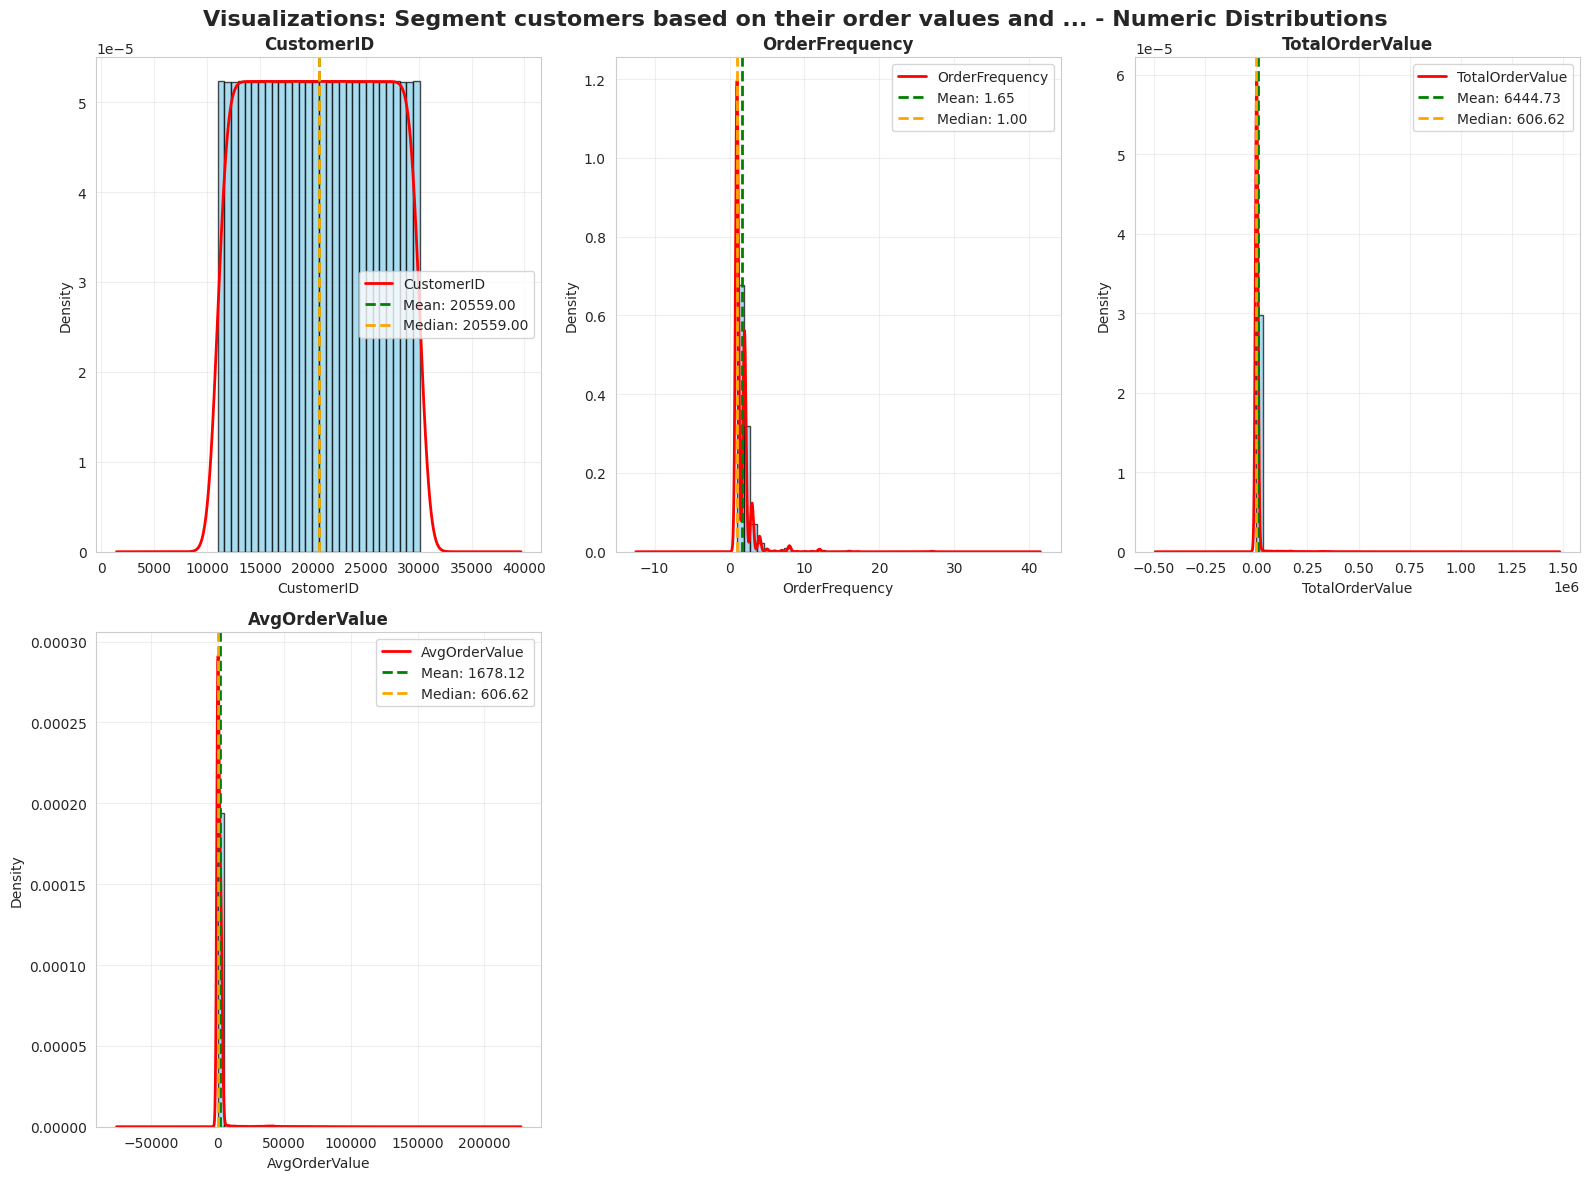

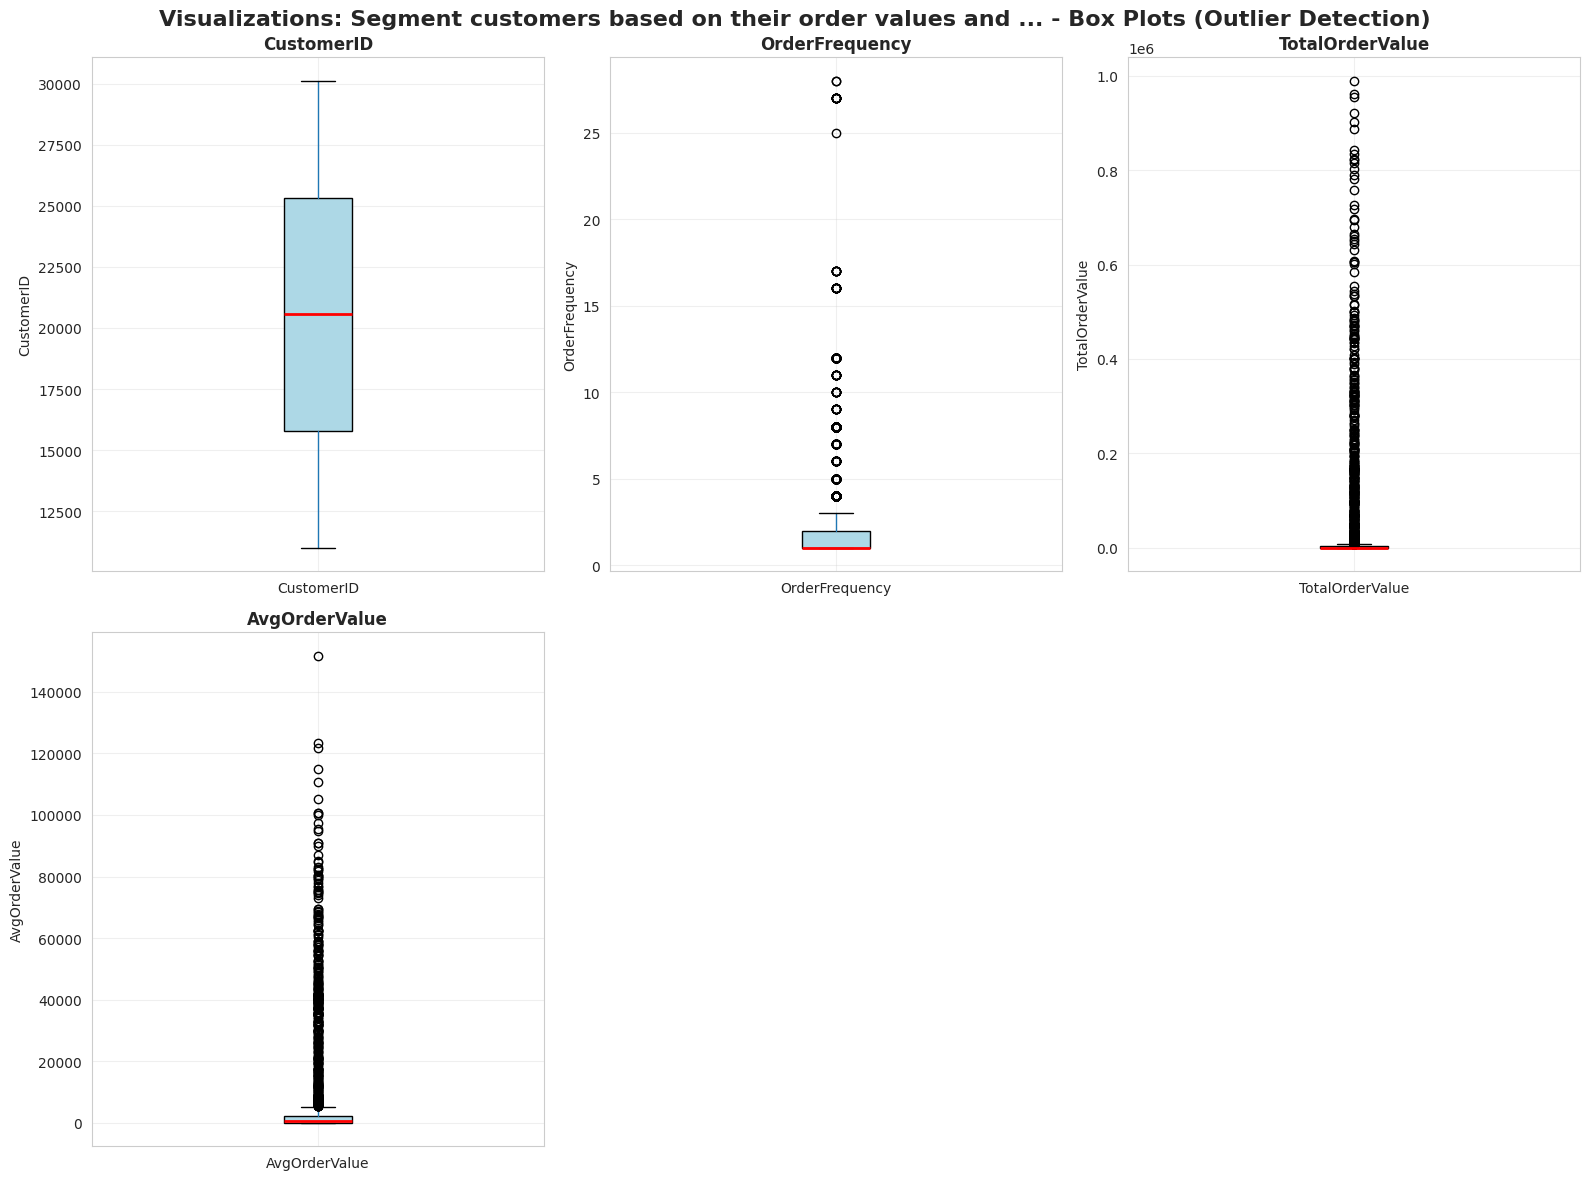

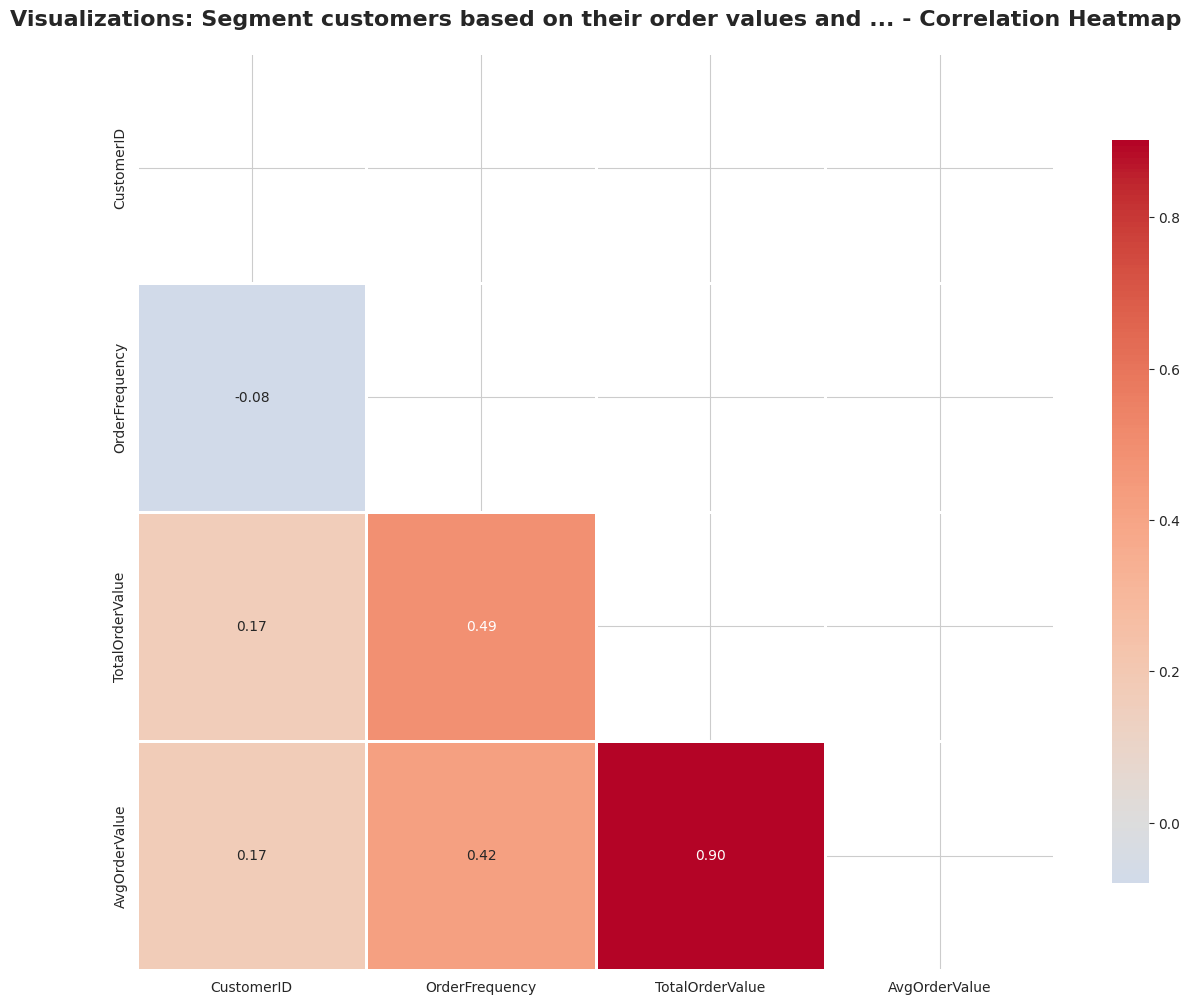


🔗 Strong Correlations (|r| > 0.5):
------------------------------------------------------------
  TotalOrderValue ↔ AvgOrderValue: 0.901

📊 Visualizing 1 categorical column(s)...



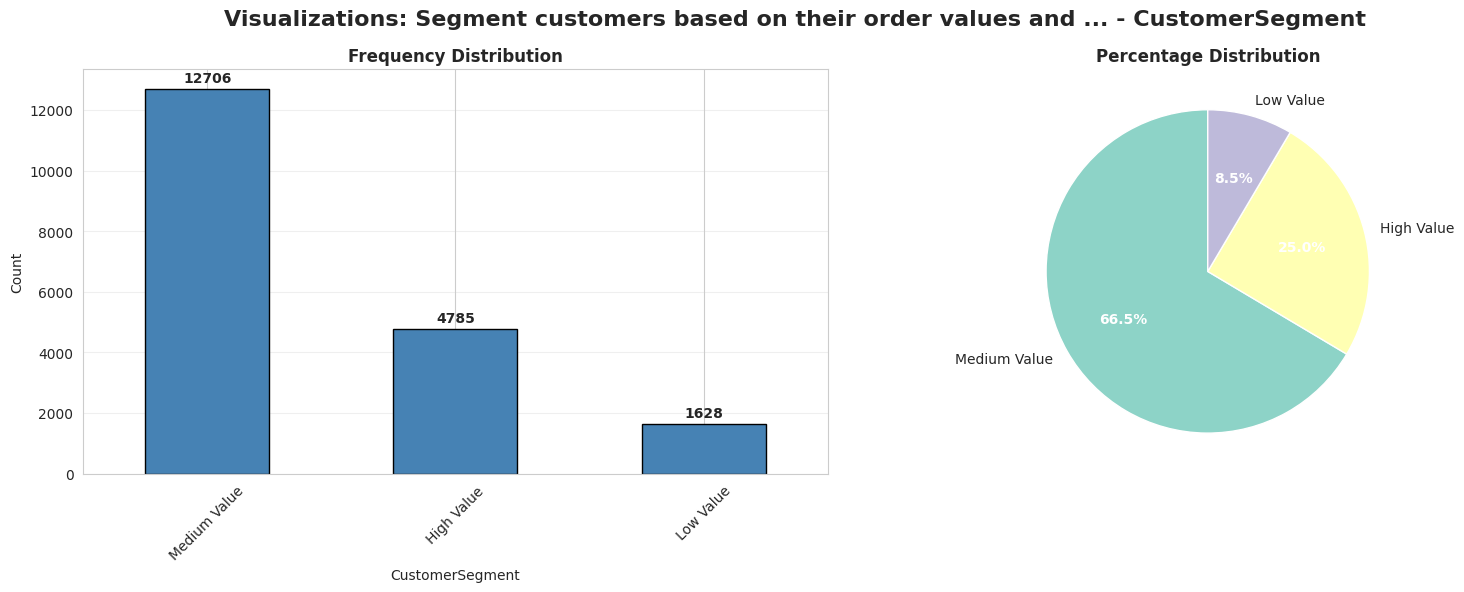


📋 SUMMARY STATISTICS TABLE
----------------------------------------------------------------------------------------------------


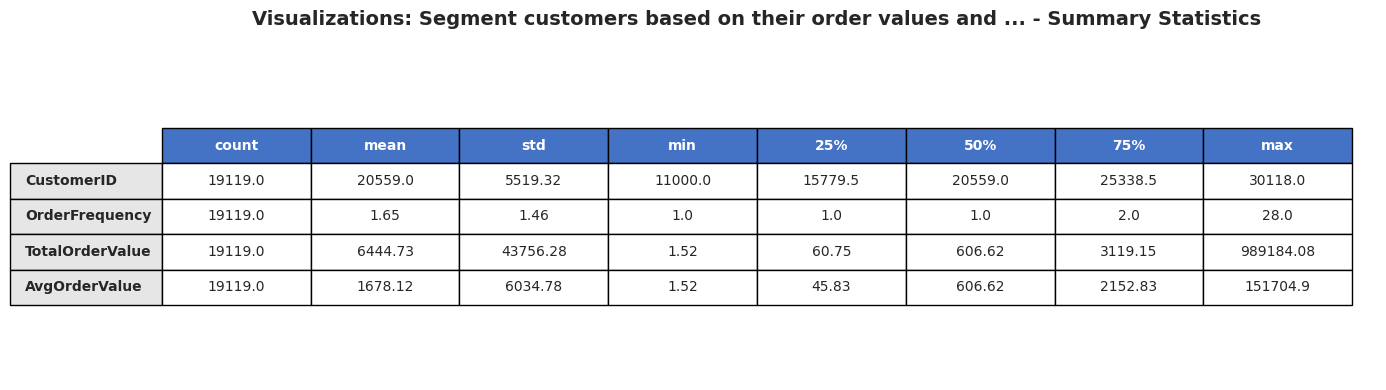


✅ Visualization complete!



In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_dataframe(df, title="Data Visualizations", max_categories=20, figsize=(16, 12)):
    """
    Create comprehensive visualizations for any pandas DataFrame.
    
    Automatically generates appropriate visualizations based on column types:
    - Numeric columns: histograms, box plots, distribution plots
    - Categorical columns: bar charts, pie charts (for reasonable cardinality)
    - Correlations: heatmap
    - Trends: line plots for sequential data
    
    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to visualize
    title : str
        Title for the visualization set
    max_categories : int
        Maximum number of categories to show in categorical plots
    figsize : tuple
        Figure size for plots
    
    Returns:
    --------
    None (displays plots)
    """
    
    if df is None or df.empty:
        print("❌ Cannot visualize empty or None DataFrame")
        return
    
    print("="*100)
    print(f"📊 {title}")
    print("="*100)
    
    # Identify column types
    numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    
    # ============================================================================
    # NUMERIC COLUMNS VISUALIZATIONS
    # ============================================================================
    if numeric_cols:
        print(f"\n📈 Visualizing {len(numeric_cols)} numeric column(s)...\n")
        
        # 1. Distribution plots (Histograms + KDE)
        n_cols = min(3, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle(f'{title} - Numeric Distributions', fontsize=16, fontweight='bold')
        
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if len(numeric_cols) > 1 else [axes]
        
        for idx, col in enumerate(numeric_cols):
            if idx < len(axes):
                ax = axes[idx]
                
                # Plot histogram with KDE
                df[col].hist(bins=30, alpha=0.7, color='skyblue', edgecolor='black', ax=ax, density=True)
                df[col].plot(kind='kde', ax=ax, color='red', linewidth=2)
                
                ax.set_title(f'{col}', fontweight='bold')
                ax.set_xlabel(col)
                ax.set_ylabel('Density')
                ax.grid(True, alpha=0.3)
                
                # Add statistics annotation
                mean_val = df[col].mean()
                median_val = df[col].median()
                ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
                ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
                ax.legend()
        
        # Hide extra subplots
        for idx in range(len(numeric_cols), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 2. Box plots for outlier detection
        if len(numeric_cols) > 0:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
            fig.suptitle(f'{title} - Box Plots (Outlier Detection)', fontsize=16, fontweight='bold')
            
            if n_rows == 1 and n_cols == 1:
                axes = [axes]
            else:
                axes = axes.flatten() if len(numeric_cols) > 1 else [axes]
            
            for idx, col in enumerate(numeric_cols):
                if idx < len(axes):
                    ax = axes[idx]
                    df.boxplot(column=col, ax=ax, patch_artist=True,
                              boxprops=dict(facecolor='lightblue'),
                              medianprops=dict(color='red', linewidth=2))
                    ax.set_title(f'{col}', fontweight='bold')
                    ax.set_ylabel(col)
                    ax.grid(True, alpha=0.3)
            
            # Hide extra subplots
            for idx in range(len(numeric_cols), len(axes)):
                axes[idx].axis('off')
            
            plt.tight_layout()
            plt.show()
        
        # 3. Correlation heatmap
        if len(numeric_cols) > 1:
            plt.figure(figsize=(12, 10))
            correlation_matrix = df[numeric_cols].corr()
            
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
            sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                       center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                       mask=mask)
            plt.title(f'{title} - Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.show()
            
            # Print strong correlations
            print("\n🔗 Strong Correlations (|r| > 0.5):")
            print("-"*60)
            strong_corr = []
            for i in range(len(correlation_matrix.columns)):
                for j in range(i+1, len(correlation_matrix.columns)):
                    corr_val = correlation_matrix.iloc[i, j]
                    if abs(corr_val) > 0.5:
                        strong_corr.append((correlation_matrix.columns[i], 
                                          correlation_matrix.columns[j], 
                                          corr_val))
            
            if strong_corr:
                for col1, col2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
                    print(f"  {col1} ↔ {col2}: {corr:.3f}")
            else:
                print("  No strong correlations found (|r| > 0.5)")
    
    # ============================================================================
    # CATEGORICAL COLUMNS VISUALIZATIONS
    # ============================================================================
    if categorical_cols:
        print(f"\n📊 Visualizing {len(categorical_cols)} categorical column(s)...\n")
        
        for col in categorical_cols:
            unique_count = df[col].nunique()
            
            # Only visualize if reasonable number of categories
            if unique_count <= max_categories:
                value_counts = df[col].value_counts().head(max_categories)
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                fig.suptitle(f'{title} - {col}', fontsize=16, fontweight='bold')
                
                # Bar chart
                value_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
                ax1.set_title(f'Frequency Distribution', fontweight='bold')
                ax1.set_xlabel(col)
                ax1.set_ylabel('Count')
                ax1.grid(True, alpha=0.3, axis='y')
                ax1.tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for i, v in enumerate(value_counts.values):
                    ax1.text(i, v + max(value_counts.values)*0.01, str(v), 
                            ha='center', va='bottom', fontweight='bold')
                
                # Pie chart (if not too many categories)
                if unique_count <= 10:
                    colors = plt.cm.Set3(range(len(value_counts)))
                    wedges, texts, autotexts = ax2.pie(value_counts.values, 
                                                        labels=value_counts.index,
                                                        autopct='%1.1f%%',
                                                        colors=colors,
                                                        startangle=90)
                    ax2.set_title(f'Percentage Distribution', fontweight='bold')
                    
                    # Improve text visibility
                    for autotext in autotexts:
                        autotext.set_color('white')
                        autotext.set_fontweight('bold')
                else:
                    # Horizontal bar for many categories
                    value_counts.plot(kind='barh', ax=ax2, color='coral', edgecolor='black')
                    ax2.set_title(f'Top {len(value_counts)} Categories', fontweight='bold')
                    ax2.set_xlabel('Count')
                    ax2.grid(True, alpha=0.3, axis='x')
                
                plt.tight_layout()
                plt.show()
            else:
                print(f"  ⚠️  Skipping {col}: too many unique values ({unique_count})")
    
    # ============================================================================
    # TIME SERIES / TREND VISUALIZATIONS
    # ============================================================================
    if datetime_cols and numeric_cols:
        print(f"\n📈 Creating trend visualizations...\n")
        
        for dt_col in datetime_cols:
            for num_col in numeric_cols[:3]:  # Limit to first 3 numeric columns
                plt.figure(figsize=(16, 6))
                
                # Sort by datetime
                df_sorted = df.sort_values(dt_col)
                
                plt.plot(df_sorted[dt_col], df_sorted[num_col], 
                        marker='o', linestyle='-', linewidth=2, markersize=4)
                plt.title(f'{title} - {num_col} over {dt_col}', 
                         fontsize=16, fontweight='bold')
                plt.xlabel(dt_col, fontweight='bold')
                plt.ylabel(num_col, fontweight='bold')
                plt.grid(True, alpha=0.3)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    
    # ============================================================================
    # SUMMARY STATISTICS TABLE
    # ============================================================================
    if numeric_cols:
        print("\n📋 SUMMARY STATISTICS TABLE")
        print("-"*100)
        
        fig, ax = plt.subplots(figsize=(14, max(4, len(numeric_cols) * 0.4)))
        ax.axis('tight')
        ax.axis('off')
        
        summary_data = df[numeric_cols].describe().T
        summary_data = summary_data.round(2)
        
        table = ax.table(cellText=summary_data.values,
                        rowLabels=summary_data.index,
                        colLabels=summary_data.columns,
                        cellLoc='center',
                        loc='center',
                        colWidths=[0.12] * len(summary_data.columns))
        
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # Style header
        for i in range(len(summary_data.columns)):
            table[(0, i)].set_facecolor('#4472C4')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Style row labels
        for i in range(1, len(summary_data) + 1):
            table[(i, -1)].set_facecolor('#E7E6E6')
            table[(i, -1)].set_text_props(weight='bold')
        
        plt.title(f'{title} - Summary Statistics', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    
    print("\n" + "="*100)
    print("✅ Visualization complete!")
    print("="*100 + "\n")


# Visualize the pipeline results
if 'pipeline_result' in locals() and pipeline_result.get('success') and pipeline_result.get('dataframe') is not None:
    print("🎨 Creating visualizations for pipeline results...\n")
    visualize_dataframe(
        df=pipeline_result['dataframe'],
        title=f"Visualizations: {pipeline_result['query'][:50]}...",
        max_categories=15
    )
else:
    print("⚠️  No DataFrame available for visualization.")
    print("Please run the rag_text_to_sql_pipeline first to generate data.")

## Complete Analysis & Visualization Pipeline

This cell combines everything: Query → SQL Generation → Execution → Analysis → Visualization

Running complete data insights pipeline...

🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🚀 COMPLETE DATA INSIGHTS PIPELINE
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

💬 User Query: 'Segment products based on their sales performance into high, medium, and low sales categories.'

📍 PHASE 1: Text-to-SQL Generation
🌟==================================================================================================🌟
🚀 COMPLETE RAG TEXT-TO-SQL PIPELINE WITH EXECUTION
🌟==================================================================================================🌟

💬 User Query: 'Segment products based on their sales performance into high, medium, and low sales categories.'

📍 STEP 1 & 2: Generating SQL query using RAG agent...
----------------------------------------------------------------------------------------------------
✅ SQL query generated successfully!
📊 Used 7 table(s) and 10 column(s)

────────────────────────────────────────────────────────────────────────────────

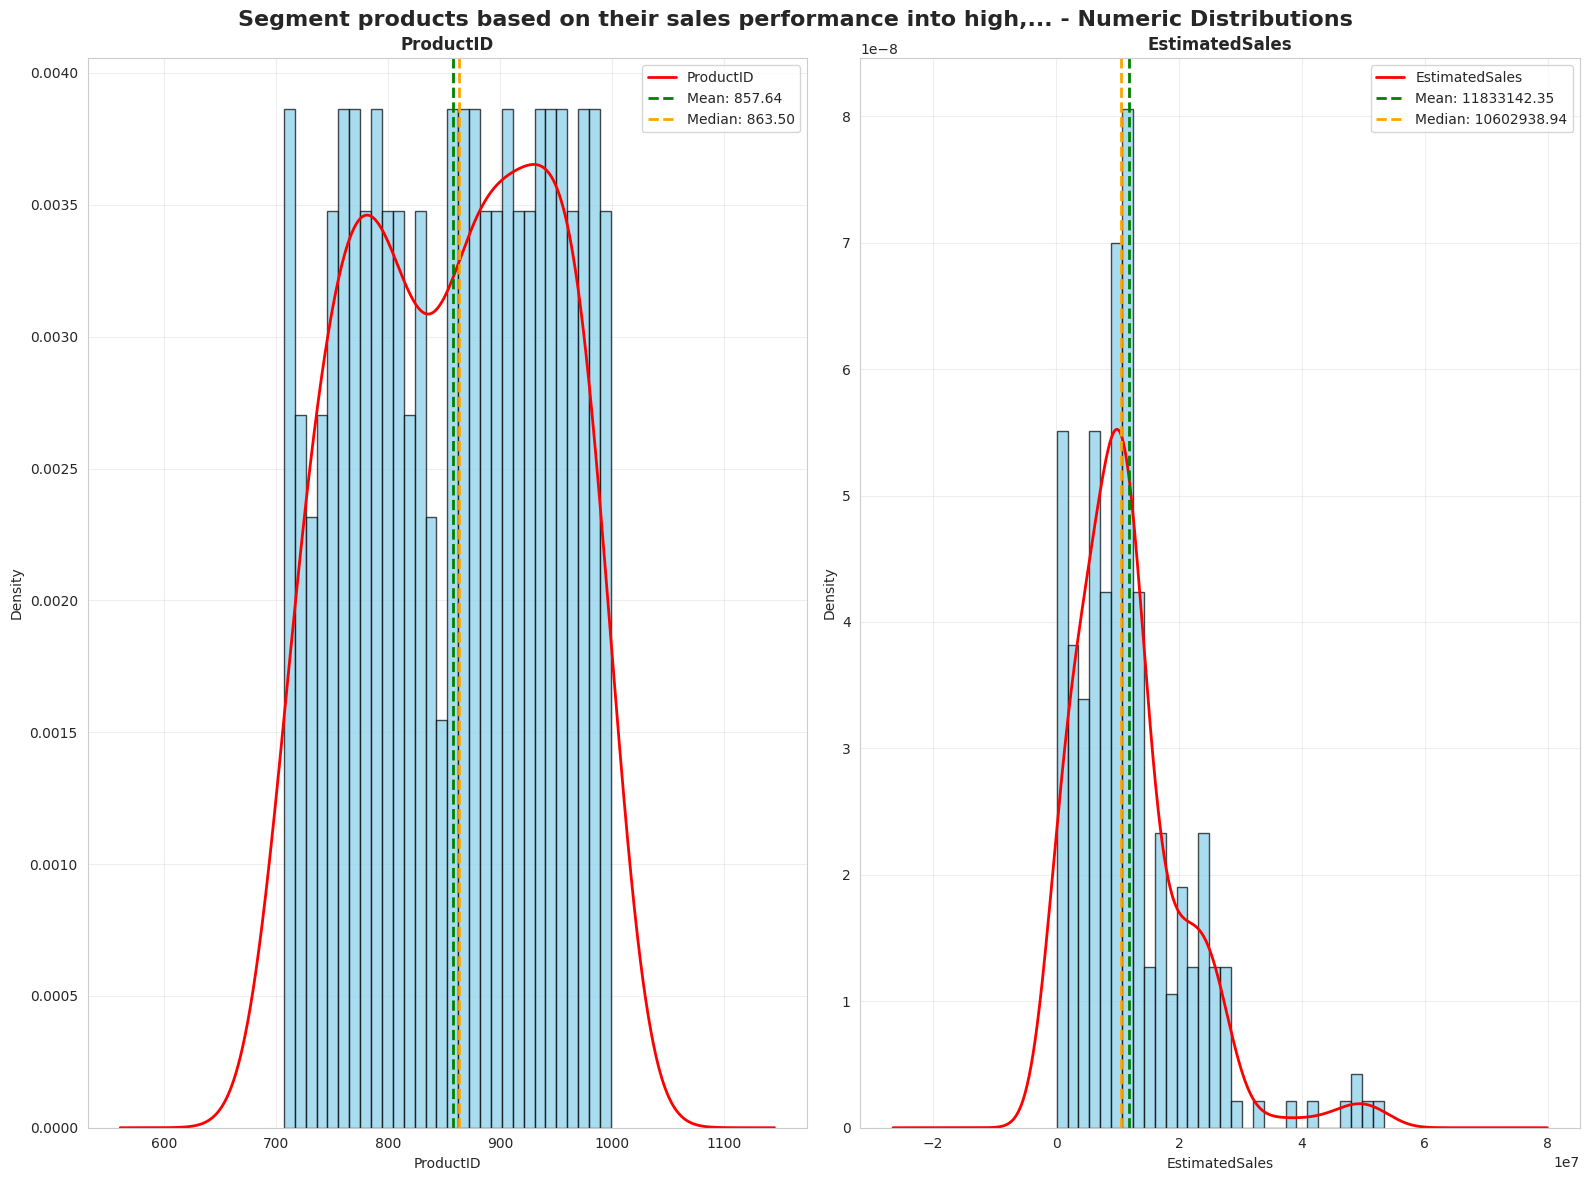

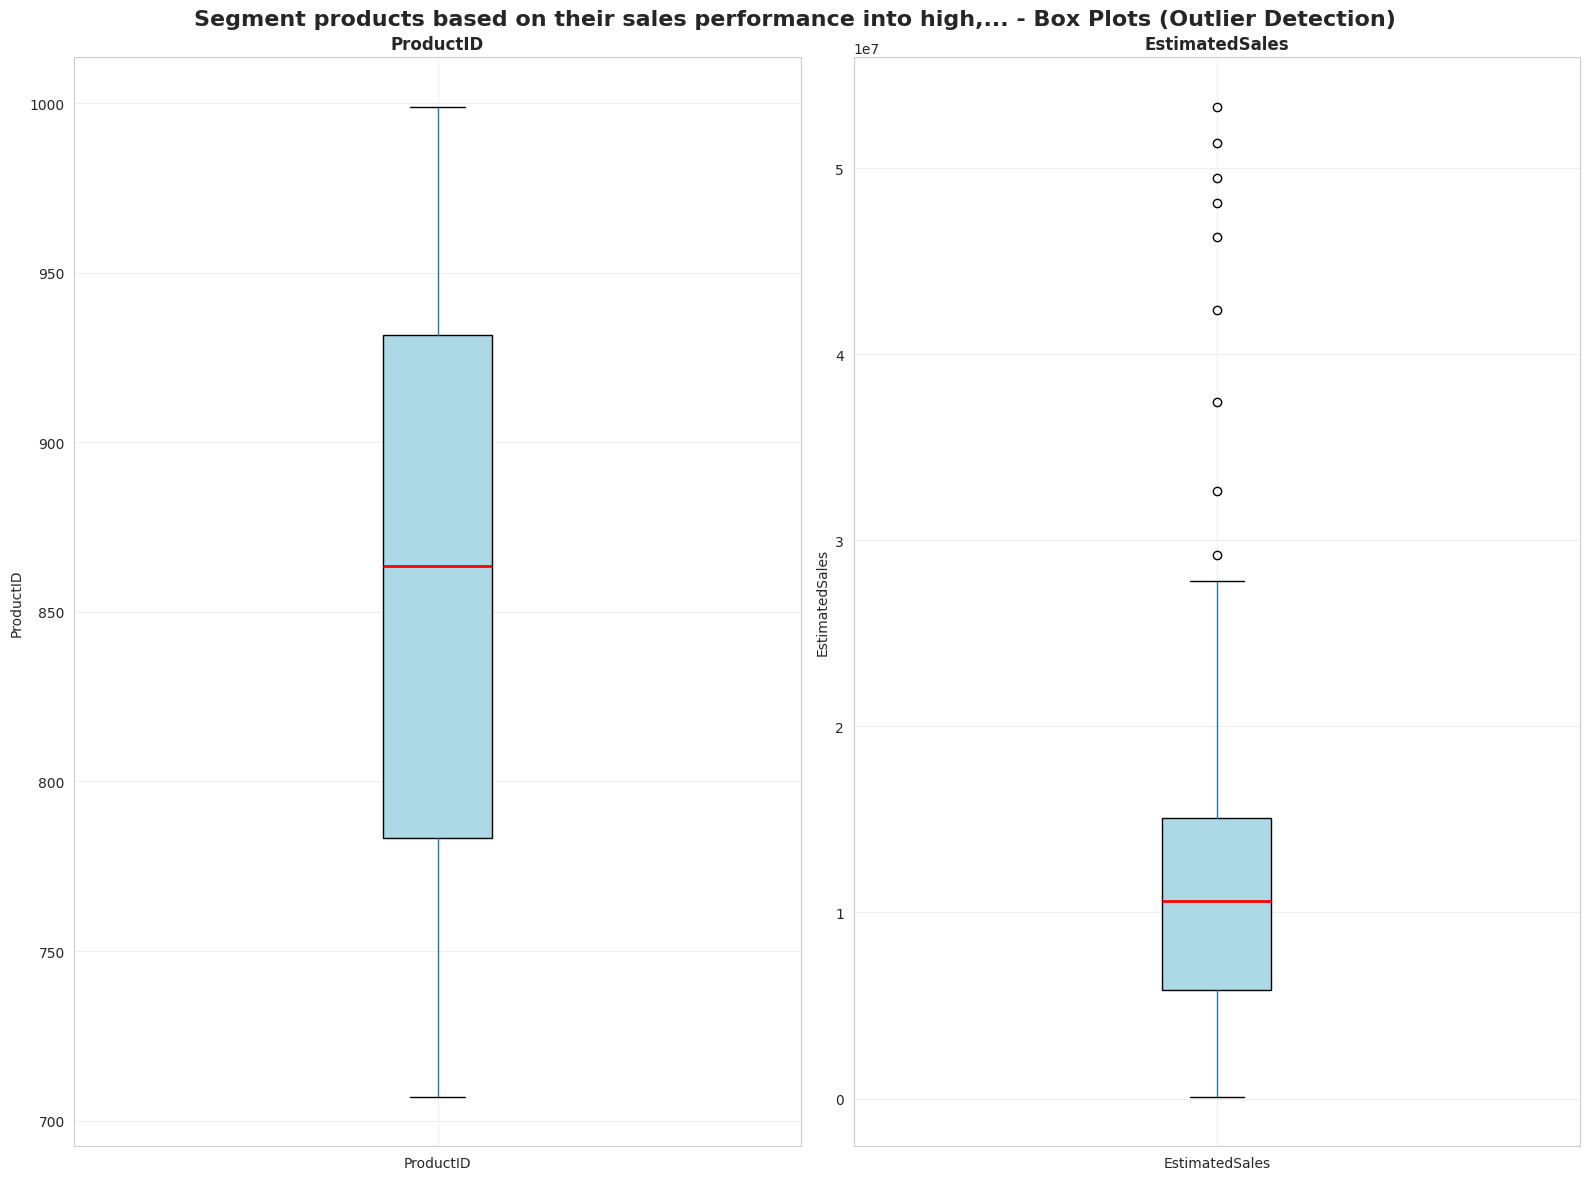

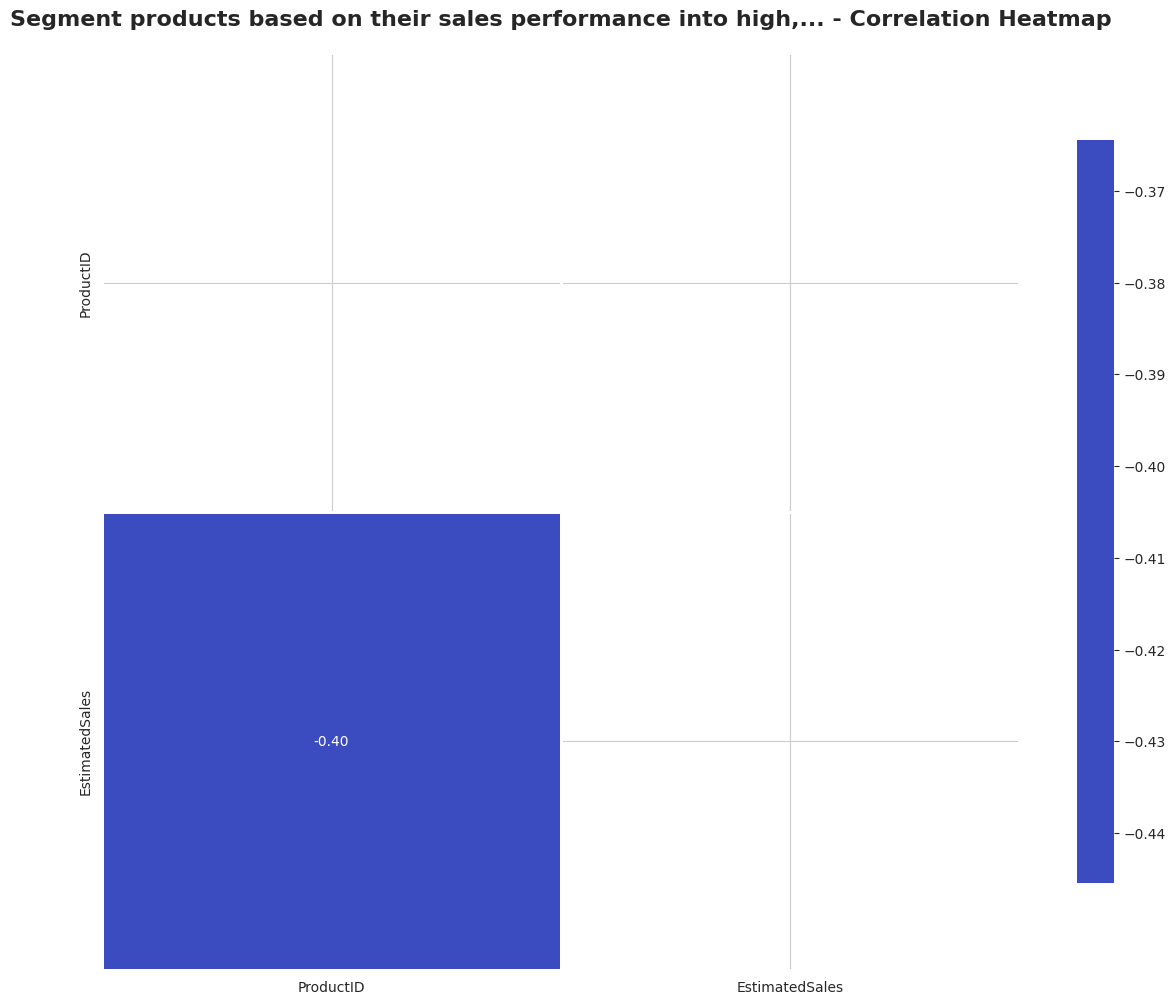


🔗 Strong Correlations (|r| > 0.5):
------------------------------------------------------------
  No strong correlations found (|r| > 0.5)

📊 Visualizing 2 categorical column(s)...

  ⚠️  Skipping ProductName: too many unique values (266)


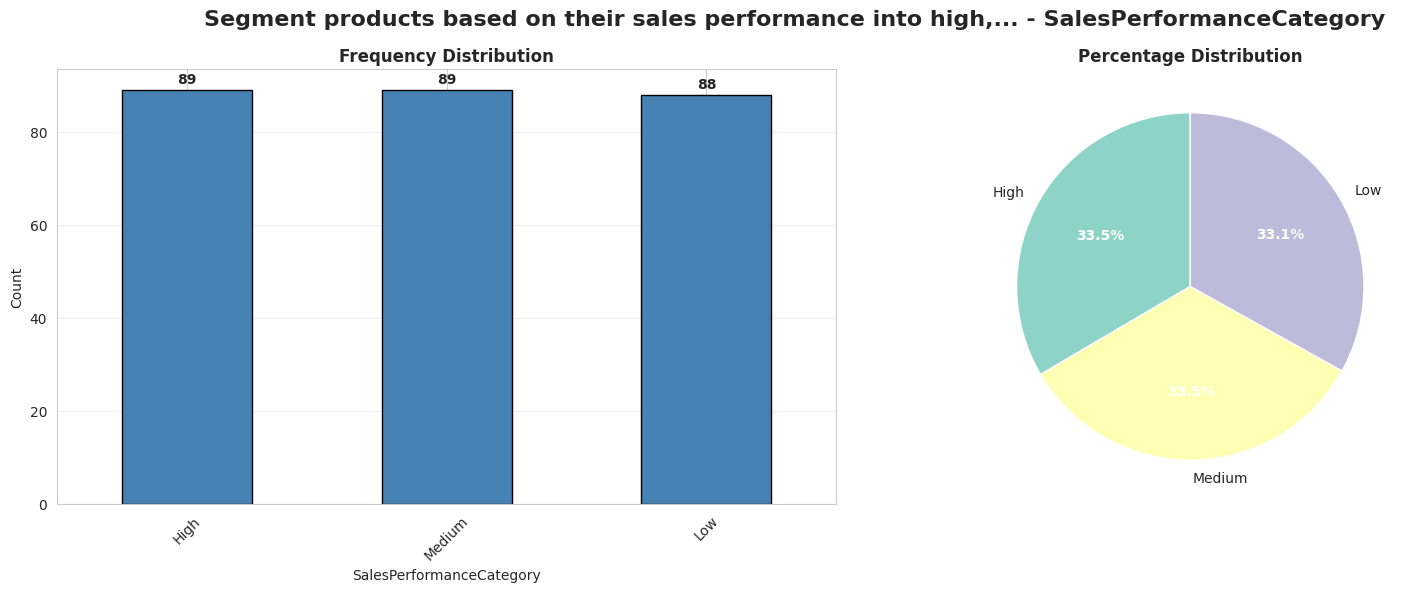


📋 SUMMARY STATISTICS TABLE
----------------------------------------------------------------------------------------------------


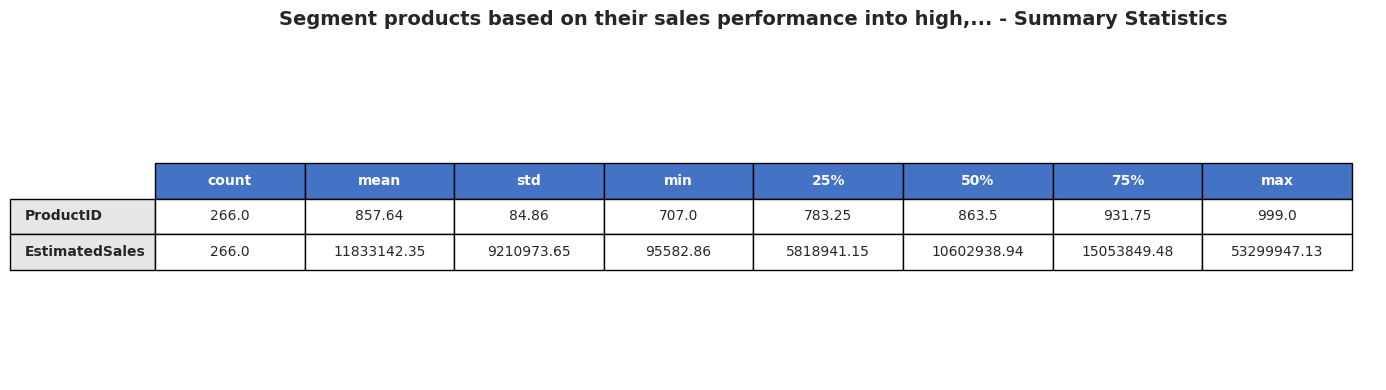


✅ Visualization complete!

✅ Phase 3 Complete: Visualizations created


🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
✅ PIPELINE COMPLETED SUCCESSFULLY!
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

📊 EXECUTIVE SUMMARY:
----------------------------------------------------------------------------------------------------
Query: Segment products based on their sales performance into high, medium, and low sales categories.
SQL Generated: Yes
Data Retrieved: 266 rows × 4 columns
Statistical Analysis: Yes
Visualizations: Yes

Data Insights:
  • Numeric columns: 11
  • Categorical columns: 2
  • Missing values: 0
  • Outliers detected: 1
----------------------------------------------------------------------------------------------------

💾 Available Variables:
  • SQL Query: pipeline_result['sql_query']
  • DataFrame: pipeline_result['dataframe']
  • Analysis: analysis_results
  • Save data: pipeline_result['dataframe'].to_csv('resu

In [26]:
def complete_data_insights_pipeline(user_query, db_connector, 
                                    top_k=10, keyword_boost=1.0, semantic_boost=1.5,
                                    execute_sql=True, analyze=True, visualize=True):
    """
    Complete end-to-end data insights pipeline.
    
    This master function orchestrates the entire workflow:
    1. Natural language query → RAG agent
    2. Metadata retrieval from OpenSearch
    3. SQL query generation with DeepSeek
    4. Query execution on database
    5. Statistical analysis of results
    6. Comprehensive visualizations
    
    Parameters:
    -----------
    user_query : str
        Natural language question about the data
    db_connector : MSSQLConnector
        Database connector instance
    top_k : int
        Number of metadata entries to retrieve
    keyword_boost : float
        Boost for keyword search
    semantic_boost : float
        Boost for semantic search
    execute_sql : bool
        Whether to execute the SQL query
    analyze : bool
        Whether to perform statistical analysis
    visualize : bool
        Whether to create visualizations
    
    Returns:
    --------
    dict : Complete pipeline results
    """
    
    print("🌟" * 50)
    print("🚀 COMPLETE DATA INSIGHTS PIPELINE")
    print("🌟" * 50)
    print(f"\n💬 User Query: '{user_query}'\n")
    
    # ============================================================================
    # PHASE 1: RAG Text-to-SQL Generation
    # ============================================================================
    print("📍 PHASE 1: Text-to-SQL Generation")
    print("="*100)
    
    pipeline_result = rag_text_to_sql_pipeline(
        user_query=user_query,
        db_connector=db_connector,
        top_k=top_k,
        keyword_boost=keyword_boost,
        semantic_boost=semantic_boost,
        execute_query=execute_sql,
        show_results=False  # We'll show results in analysis/viz
    )
    
    if not pipeline_result['success']:
        print("\n❌ Pipeline failed. Cannot proceed with analysis.")
        return pipeline_result
    
    df = pipeline_result.get('dataframe')
    
    if df is None or df.empty:
        print("\n⚠️  No data returned from query. Cannot proceed with analysis.")
        return pipeline_result
    
    print(f"\n✅ Phase 1 Complete: Retrieved {len(df)} rows, {len(df.columns)} columns\n")
    
    # ============================================================================
    # PHASE 2: Statistical Analysis
    # ============================================================================
    analysis_results = None
    if analyze and df is not None:
        print("\n📍 PHASE 2: Statistical Analysis")
        print("="*100)
        
        analysis_results = analyze_dataframe(
            df=df,
            title=f"Analysis: {user_query[:60]}..."
        )
        
        print("✅ Phase 2 Complete: Statistical analysis finished\n")
    
    # ============================================================================
    # PHASE 3: Visualizations
    # ============================================================================
    if visualize and df is not None:
        print("\n📍 PHASE 3: Data Visualizations")
        print("="*100)
        
        visualize_dataframe(
            df=df,
            title=f"{user_query[:60]}...",
            max_categories=15
        )
        
        print("✅ Phase 3 Complete: Visualizations created\n")
    
    # ============================================================================
    # FINAL SUMMARY
    # ============================================================================
    print("\n🌟" * 50)
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("🌟" * 50)
    
    print("\n📊 EXECUTIVE SUMMARY:")
    print("-"*100)
    print(f"Query: {user_query}")
    print(f"SQL Generated: Yes")
    print(f"Data Retrieved: {len(df)} rows × {len(df.columns)} columns")
    print(f"Statistical Analysis: {'Yes' if analyze else 'Skipped'}")
    print(f"Visualizations: {'Yes' if visualize else 'Skipped'}")
    
    if analysis_results:
        print(f"\nData Insights:")
        print(f"  • Numeric columns: {len(analysis_results.get('numeric_stats', {}))}")
        print(f"  • Categorical columns: {len(analysis_results.get('categorical_stats', {}))}")
        print(f"  • Missing values: {len(analysis_results.get('missing_values', []))}")
        print(f"  • Outliers detected: {len(analysis_results.get('outliers', {}))}")
    
    print("-"*100)
    print("\n💾 Available Variables:")
    print(f"  • SQL Query: pipeline_result['sql_query']")
    print(f"  • DataFrame: pipeline_result['dataframe']")
    print(f"  • Analysis: analysis_results")
    print(f"  • Save data: pipeline_result['dataframe'].to_csv('results.csv', index=False)")
    
    print("\n" + "="*100 + "\n")
    
    return {
        **pipeline_result,
        'analysis': analysis_results
    }


# ============================================================================
# EXAMPLE: Run Complete Pipeline
# ============================================================================

# Example 1: Product Sales Analysis
print("Running complete data insights pipeline...\n")

insights = complete_data_insights_pipeline(
    user_query="Segment products based on their sales performance into high, medium, and low sales categories.",
    db_connector=db_connector,
    top_k=10,
    execute_sql=True,
    analyze=True,
    visualize=True
)

# Access results
if insights['success']:
    results_dataframe = insights['dataframe']
    sql_query = insights['sql_query']
    analysis = insights.get('analysis')
    
    print(f"\n✅ Pipeline completed! Access results using:")
    print(f"   - results_dataframe")
    print(f"   - sql_query")
    print(f"   - analysis")
else:
    print("\n❌ Pipeline failed. Check error messages above.")

## Quick Analysis Examples

Try these pre-configured queries to see the complete pipeline in action.

🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🚀 COMPLETE DATA INSIGHTS PIPELINE
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

💬 User Query: 'What are the total sales by product category?'

📍 PHASE 1: Text-to-SQL Generation
🌟==================================================================================================🌟
🚀 COMPLETE RAG TEXT-TO-SQL PIPELINE WITH EXECUTION
🌟==================================================================================================🌟

💬 User Query: 'What are the total sales by product category?'

📍 STEP 1 & 2: Generating SQL query using RAG agent...
----------------------------------------------------------------------------------------------------
✅ SQL query generated successfully!
📊 Used 4 table(s) and 10 column(s)

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL:
────────────────────────────────────────────────────────────────────────────────────────────────────
SELEC

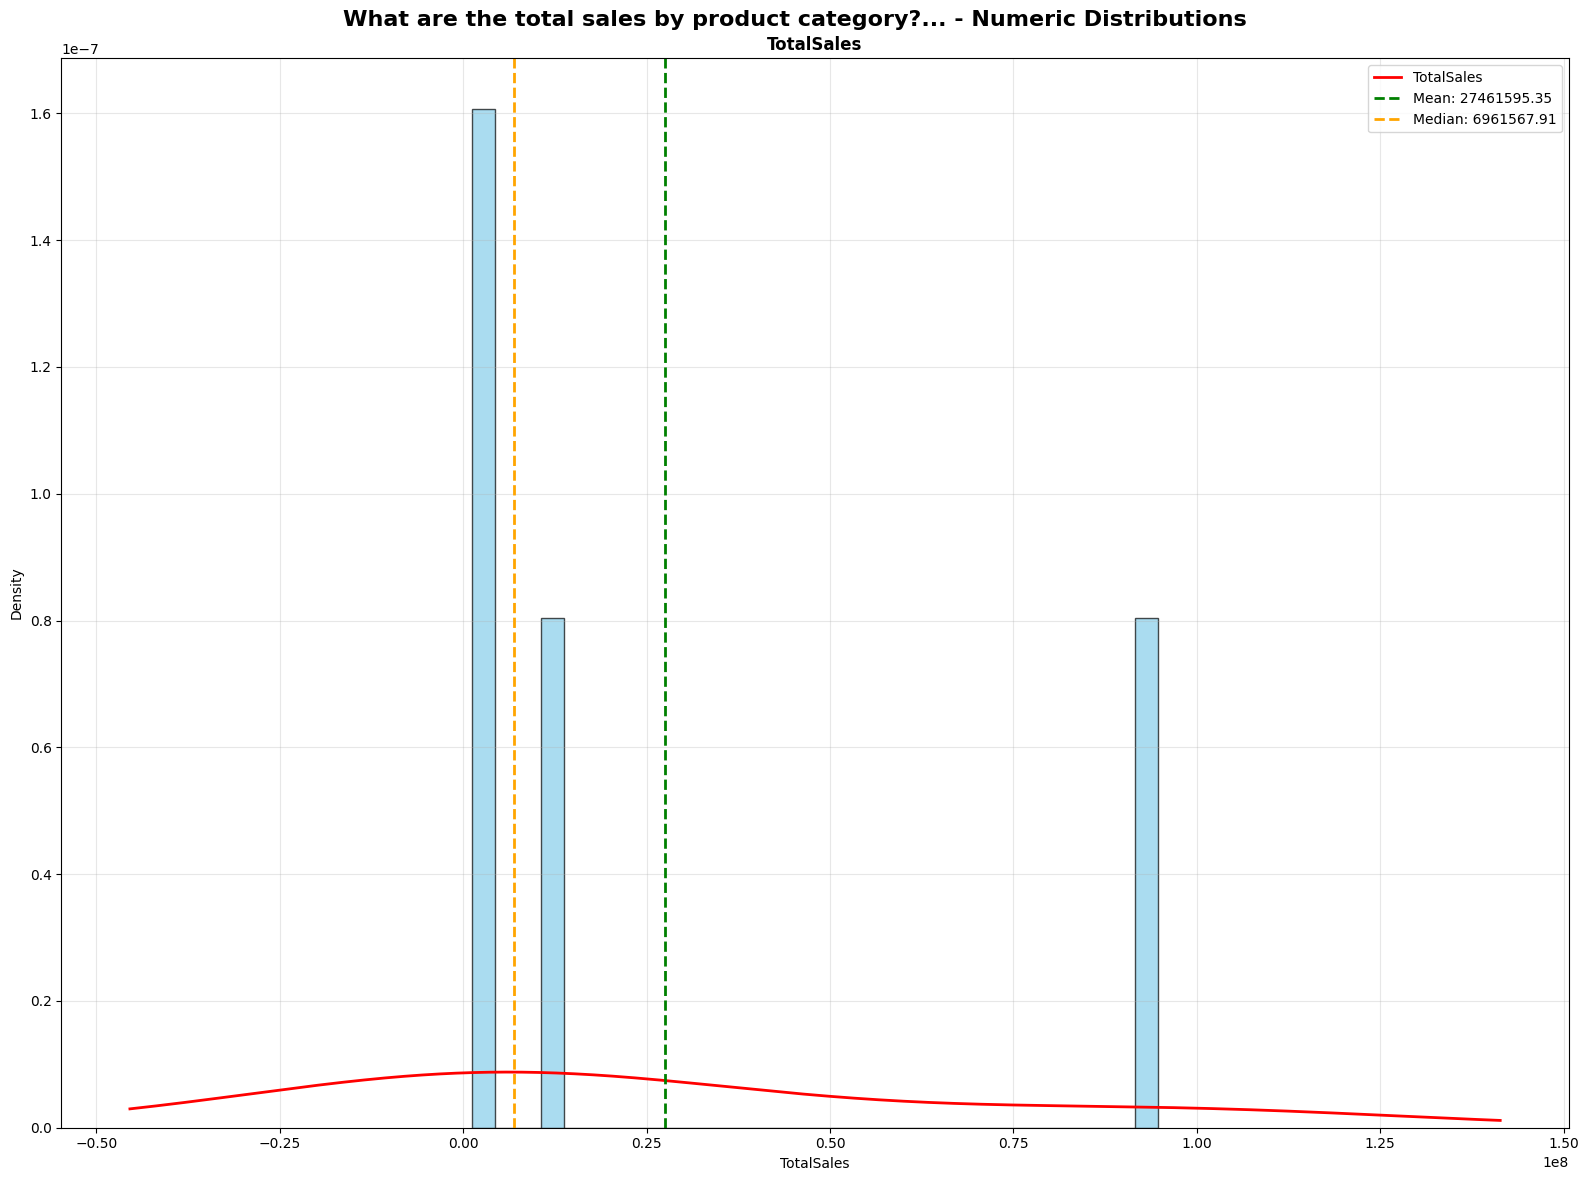

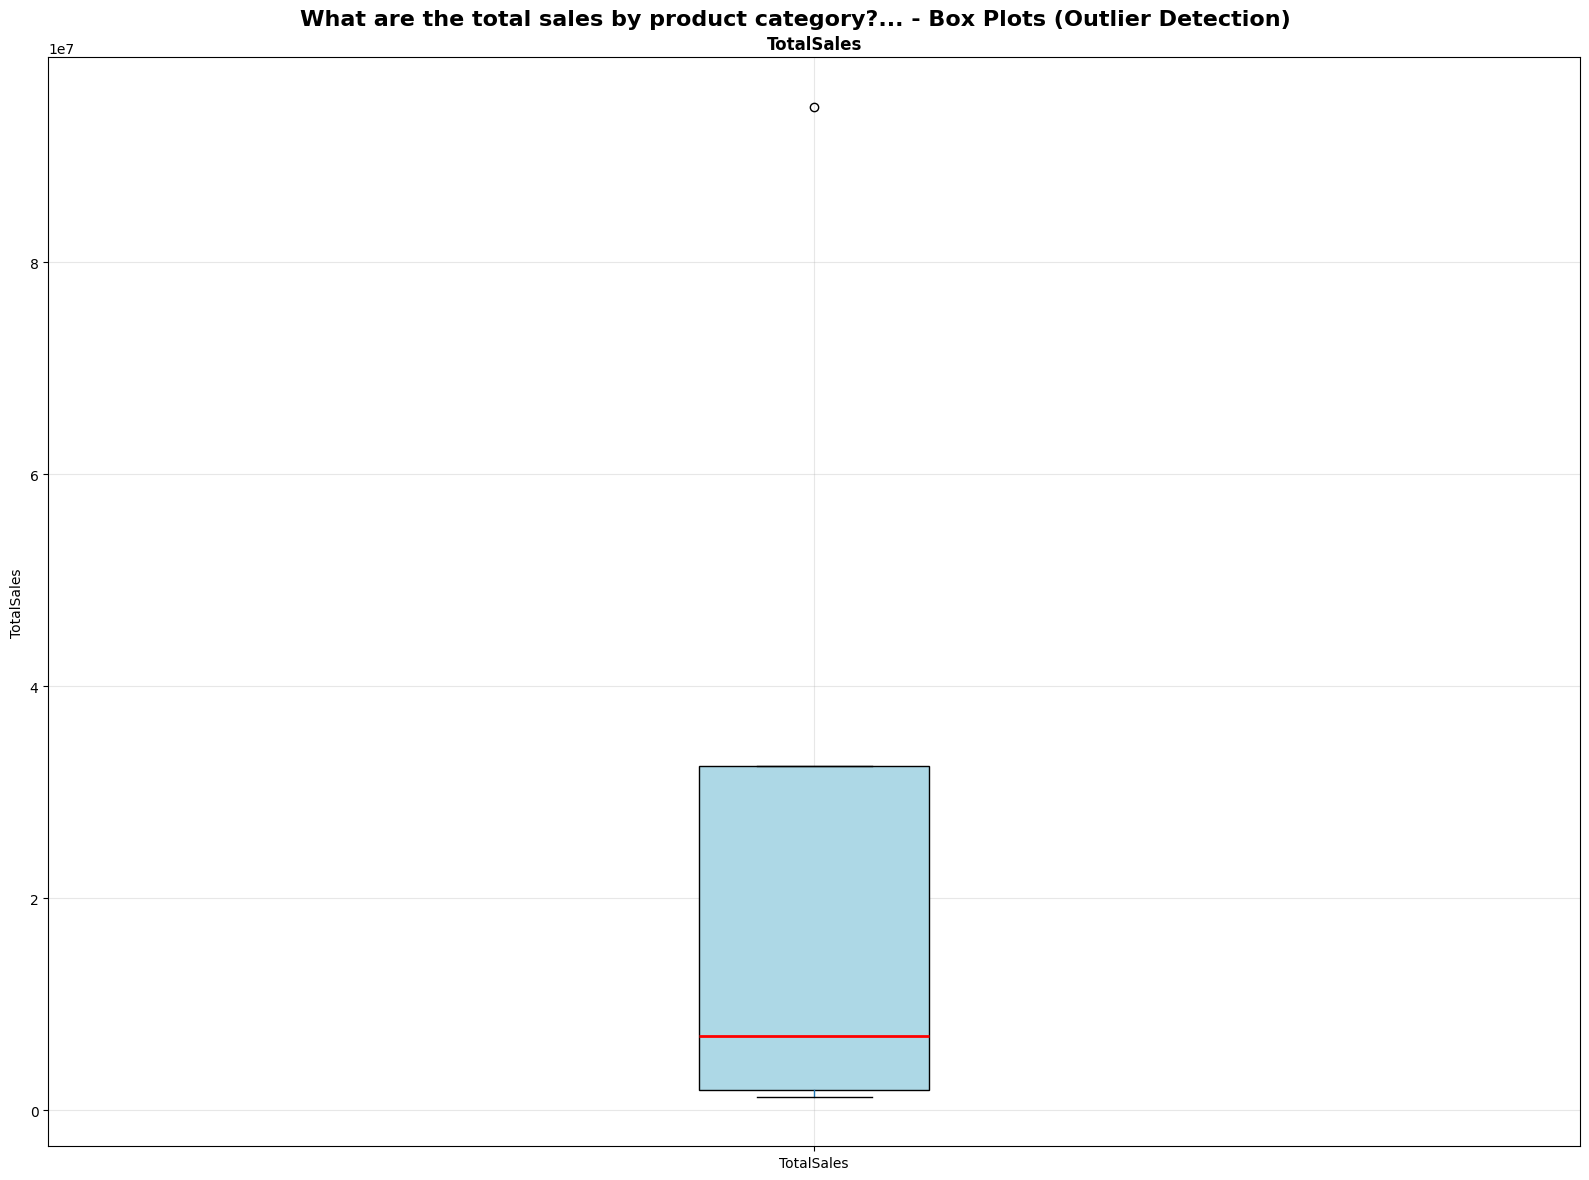


📊 Visualizing 1 categorical column(s)...



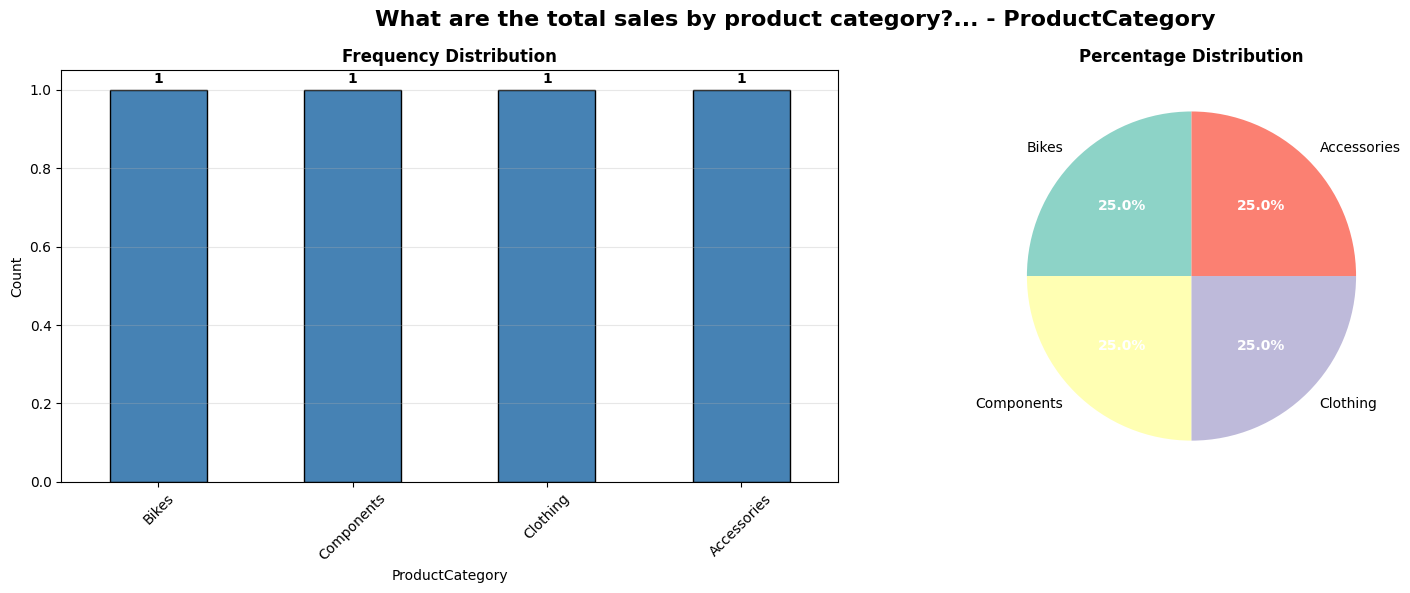


📋 SUMMARY STATISTICS TABLE
----------------------------------------------------------------------------------------------------


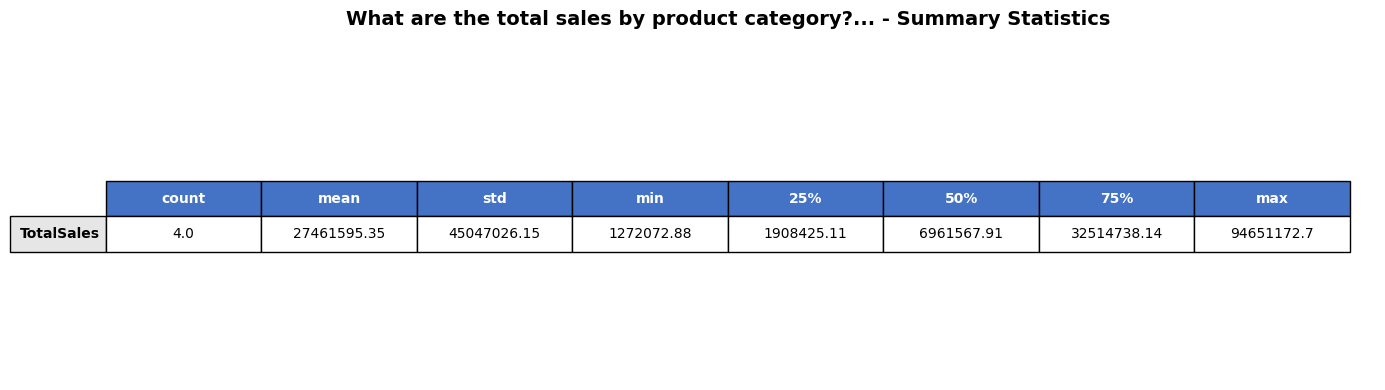


✅ Visualization complete!

✅ Phase 3 Complete: Visualizations created


🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
✅ PIPELINE COMPLETED SUCCESSFULLY!
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

📊 EXECUTIVE SUMMARY:
----------------------------------------------------------------------------------------------------
Query: What are the total sales by product category?
SQL Generated: Yes
Data Retrieved: 4 rows × 2 columns
Statistical Analysis: Yes
Visualizations: Yes

Data Insights:
  • Numeric columns: 11
  • Categorical columns: 1
  • Missing values: 0
  • Outliers detected: 1
----------------------------------------------------------------------------------------------------

💾 Available Variables:
  • SQL Query: pipeline_result['sql_query']
  • DataFrame: pipeline_result['dataframe']
  • Analysis: analysis_results
  • Save data: pipeline_result['dataframe'].to_csv('results.csv', index=False)




In [23]:
# Example 1: Sales by Category
insights_1 = complete_data_insights_pipeline(
    user_query="What are the total sales by product category?",
    db_connector=db_connector,
    analyze=True,
    visualize=True
)

🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🚀 COMPLETE DATA INSIGHTS PIPELINE
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

💬 User Query: 'Show me customer distribution by state or region'

📍 PHASE 1: Text-to-SQL Generation
🌟==================================================================================================🌟
🚀 COMPLETE RAG TEXT-TO-SQL PIPELINE WITH EXECUTION
🌟==================================================================================================🌟

💬 User Query: 'Show me customer distribution by state or region'

📍 STEP 1 & 2: Generating SQL query using RAG agent...
----------------------------------------------------------------------------------------------------
✅ SQL query generated successfully!
📊 Used 3 table(s) and 10 column(s)

────────────────────────────────────────────────────────────────────────────────────────────────────
GENERATED SQL:
────────────────────────────────────────────────────────────────────────────────────────────────────

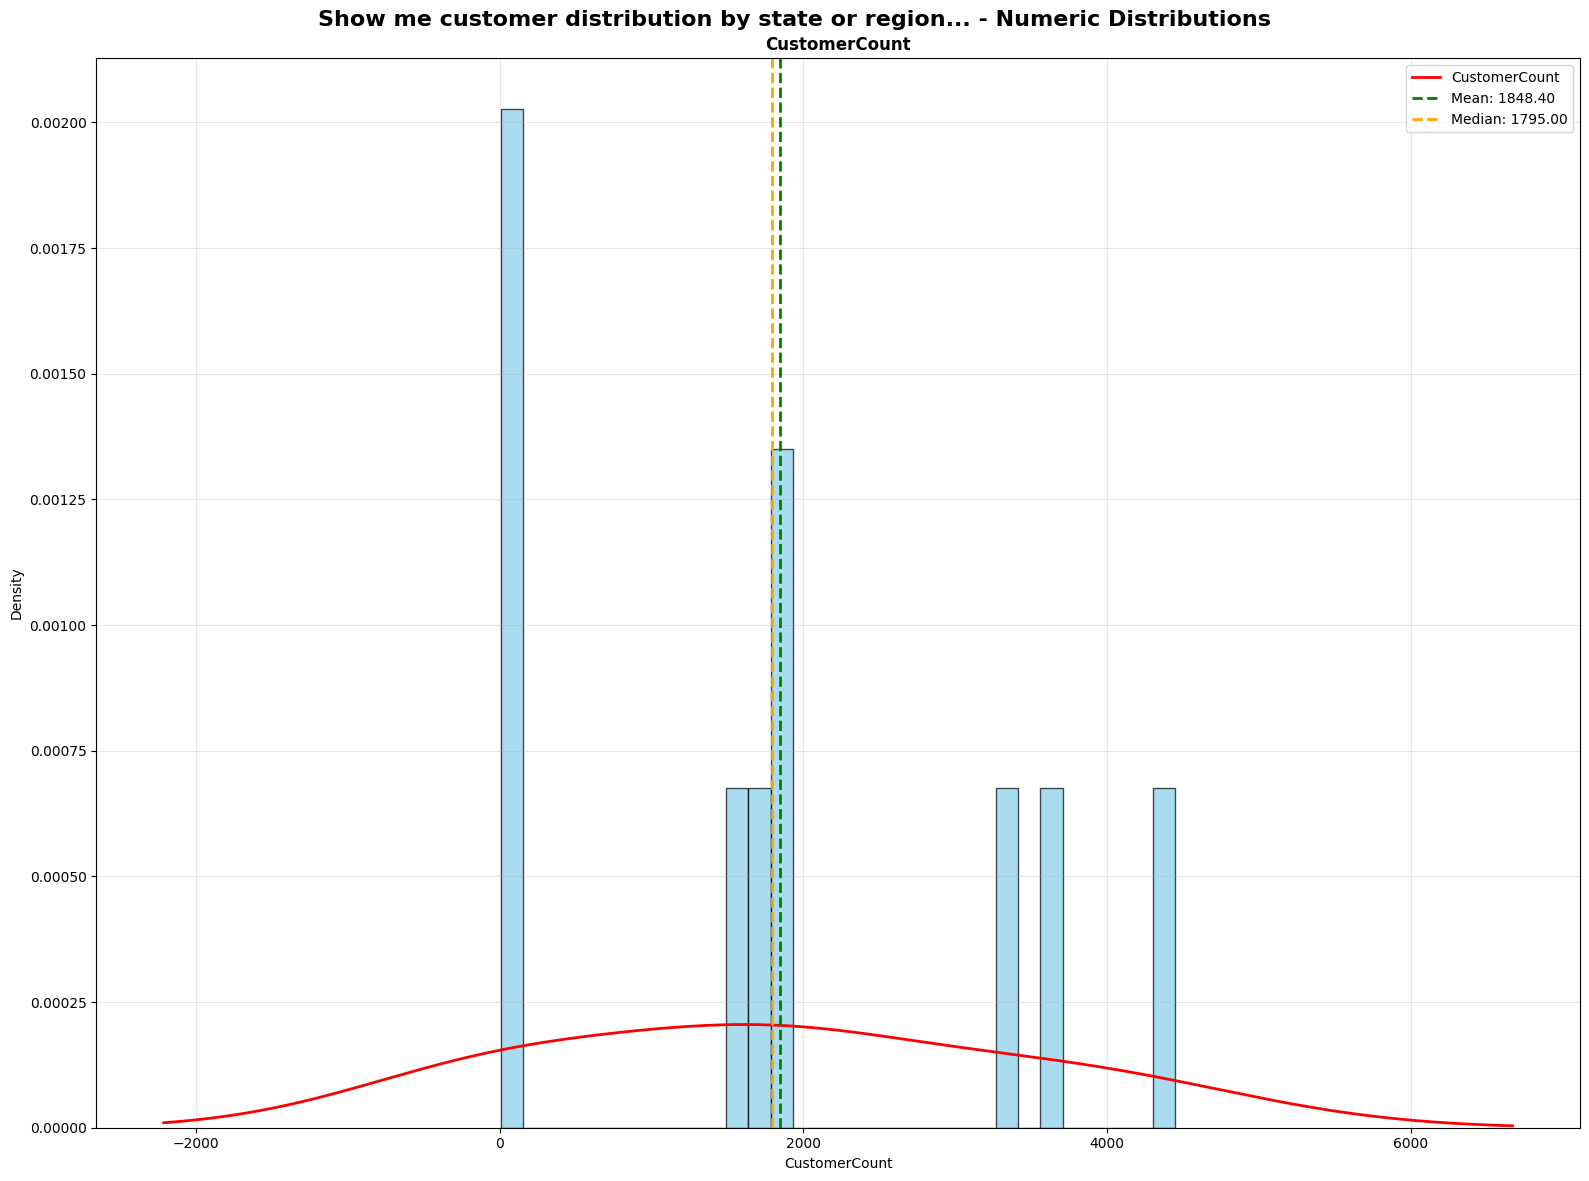

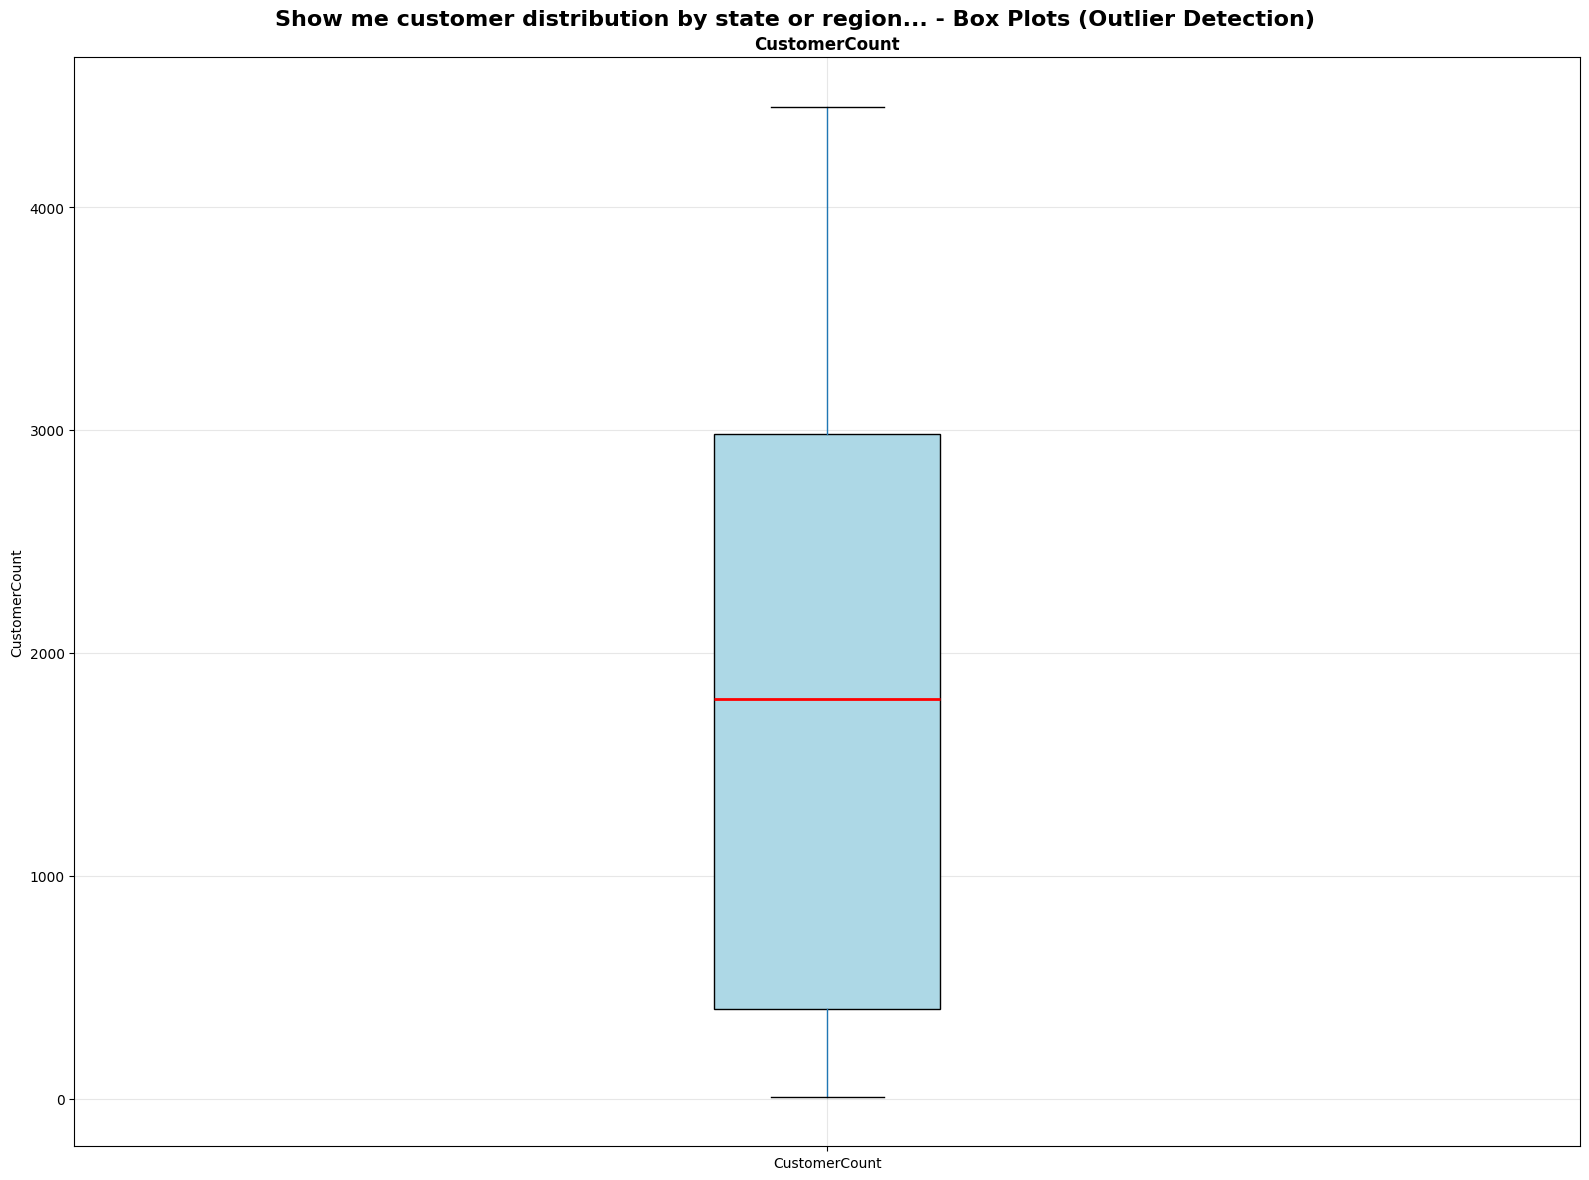


📊 Visualizing 1 categorical column(s)...



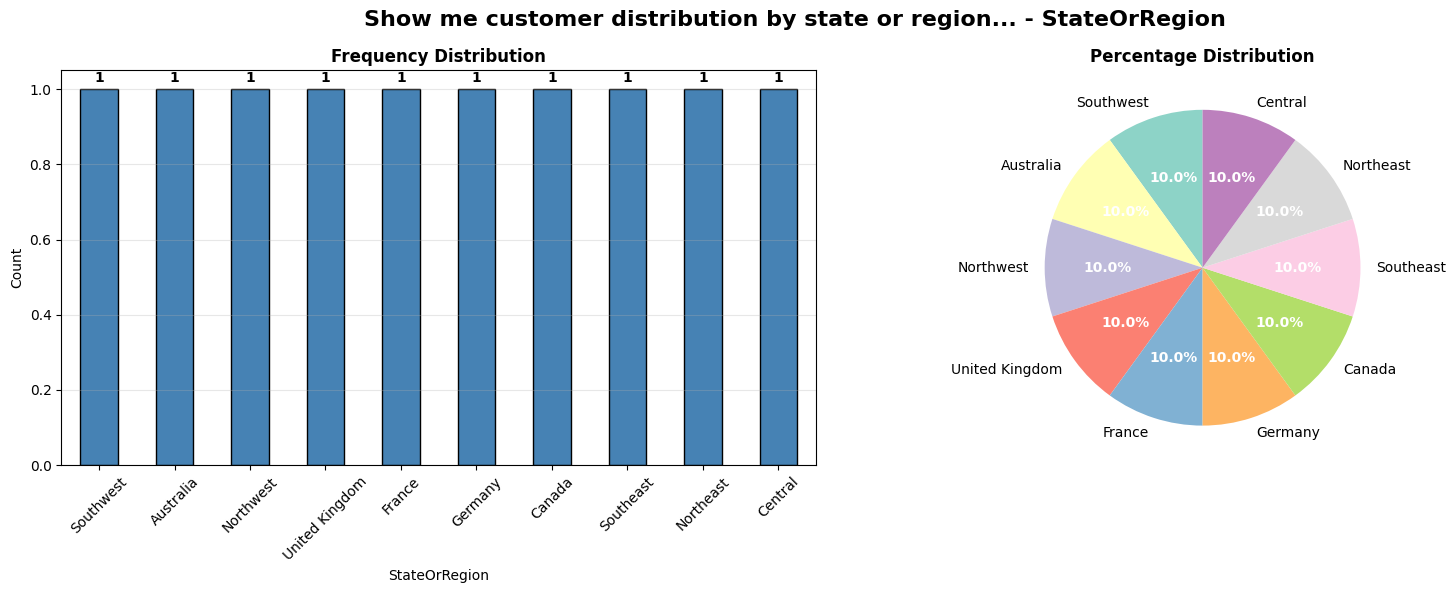


📋 SUMMARY STATISTICS TABLE
----------------------------------------------------------------------------------------------------


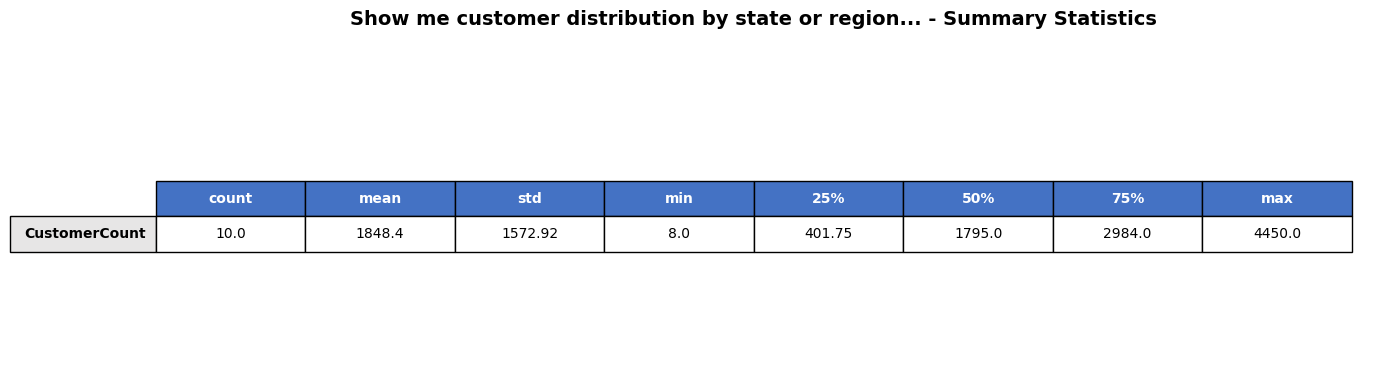


✅ Visualization complete!

✅ Phase 3 Complete: Visualizations created


🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
✅ PIPELINE COMPLETED SUCCESSFULLY!
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

📊 EXECUTIVE SUMMARY:
----------------------------------------------------------------------------------------------------
Query: Show me customer distribution by state or region
SQL Generated: Yes
Data Retrieved: 10 rows × 2 columns
Statistical Analysis: Yes
Visualizations: Yes

Data Insights:
  • Numeric columns: 11
  • Categorical columns: 1
  • Missing values: 0
  • Outliers detected: 0
----------------------------------------------------------------------------------------------------

💾 Available Variables:
  • SQL Query: pipeline_result['sql_query']
  • DataFrame: pipeline_result['dataframe']
  • Analysis: analysis_results
  • Save data: pipeline_result['dataframe'].to_csv('results.csv', index=False)




In [24]:
# Example 2: Customer Distribution
insights_2 = complete_data_insights_pipeline(
    user_query="Show me customer distribution by state or region",
    db_connector=db_connector,
    analyze=True,
    visualize=True
)

# AI-Powered Business Insights

This section uses DeepSeek LLM to generate business insights and actionable recommendations based on the query results.

**📝 Note**: This section builds on all previous sections. Make sure you've run all cells above in order, including:
- OpenSearch client setup
- Model deployment
- RAG text-to-SQL functions
- Data analysis functions
- Visualization functions

In [22]:
def generate_business_insights(df, original_query, sql_query=None, analysis_results=None, 
                               model_id=None, max_rows_to_send=100):
    """
    Generate AI-powered business insights and recommendations using DeepSeek LLM.
    
    This function sends the DataFrame results to DeepSeek LLM along with context
    about the original query and generates:
    - Key findings from the data
    - Business insights and patterns
    - Actionable recommendations
    - Strategic considerations
    
    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame with query results
    original_query : str
        The original natural language query
    sql_query : str, optional
        The SQL query that was executed
    analysis_results : dict, optional
        Statistical analysis results
    model_id : str, optional
        DeepSeek model ID (defaults to global llm_model_id)
    max_rows_to_send : int
        Maximum number of rows to send to LLM (default: 100)
    
    Returns:
    --------
    dict : Contains insights, recommendations, and raw LLM response
    """
    
    if df is None or df.empty:
        print("❌ Cannot generate insights for empty DataFrame")
        return None
    
    if model_id is None:
        model_id = llm_model_id
    
    print("="*100)
    print("🤖 GENERATING AI-POWERED BUSINESS INSIGHTS")
    print("="*100)
    print(f"\n📊 Analyzing {len(df)} rows × {len(df.columns)} columns")
    print(f"📝 Original Query: '{original_query}'\n")
    
    # ============================================================================
    # Prepare Data Summary for LLM
    # ============================================================================
    
    # Limit rows to avoid context window issues
    df_sample = df.head(max_rows_to_send) if len(df) > max_rows_to_send else df
    
    # Convert DataFrame to a readable format
    data_summary = []
    data_summary.append(f"Dataset Overview:")
    data_summary.append(f"- Total Rows: {len(df)}")
    data_summary.append(f"- Columns: {', '.join(df.columns.tolist())}")
    data_summary.append(f"\nColumn Types:")
    for col in df.columns:
        dtype = df[col].dtype
        data_summary.append(f"- {col}: {dtype}")
    
    # Add basic statistics
    data_summary.append(f"\nSummary Statistics:")
    numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    if len(numeric_cols) > 0:
        for col in numeric_cols:
            data_summary.append(f"\n{col}:")
            data_summary.append(f"  Mean: {df[col].mean():.2f}")
            data_summary.append(f"  Median: {df[col].median():.2f}")
            data_summary.append(f"  Min: {df[col].min():.2f}")
            data_summary.append(f"  Max: {df[col].max():.2f}")
            data_summary.append(f"  Std Dev: {df[col].std():.2f}")
    
    # Add actual data sample
    data_summary.append(f"\nData Sample (first {len(df_sample)} rows):")
    data_summary.append(df_sample.to_string(index=False))
    
    # Add analysis results if available
    if analysis_results:
        if analysis_results.get('missing_values'):
            data_summary.append(f"\nMissing Values Detected:")
            for mv in analysis_results['missing_values']:
                data_summary.append(f"- {mv['Column']}: {mv['Missing_Count']} ({mv['Missing_Percentage']:.1f}%)")
        
        if analysis_results.get('outliers'):
            data_summary.append(f"\nOutliers Detected:")
            for col, info in analysis_results['outliers'].items():
                data_summary.append(f"- {col}: {info['count']} outliers ({info['percentage']:.1f}%)")
    
    data_context = "\n".join(data_summary)
    
    # ============================================================================
    # Construct LLM Prompt
    # ============================================================================
    
    system_prompt = """You are a senior business analyst and data scientist with expertise in deriving actionable insights from data. Your role is to analyze query results and provide strategic business recommendations.

Your analysis should be:
1. Data-driven and evidence-based
2. Actionable and specific
3. Business-focused, not just technical
4. Strategic and forward-thinking
5. Clear and concise

Structure your response in the following format:

KEY FINDINGS:
- List 3-5 most important findings from the data
- Focus on patterns, trends, and notable observations

BUSINESS INSIGHTS:
- Explain what these findings mean for the business
- Identify opportunities and risks
- Compare to industry standards or expectations where relevant

RECOMMENDATIONS:
1. [Specific, actionable recommendation]
   - Expected impact
   - Implementation considerations
2. [Another recommendation]
   - Expected impact
   - Implementation considerations
3. [Continue as needed]

STRATEGIC CONSIDERATIONS:
- Long-term implications
- Related areas to investigate
- Potential challenges to address

Keep your analysis professional, insightful, and focused on driving business value."""

    user_prompt = f"""Please analyze the following data and provide business insights and recommendations.

ORIGINAL BUSINESS QUESTION:
{original_query}

{'SQL QUERY EXECUTED:' if sql_query else ''}
{sql_query if sql_query else ''}

DATA AND ANALYSIS:
{data_context}

Based on this data, please provide:
1. Key findings from the data
2. Business insights and what they mean
3. Specific, actionable recommendations
4. Strategic considerations for the business

Focus on practical, actionable insights that can drive business decisions."""

    # ============================================================================
    # Call DeepSeek LLM
    # ============================================================================
    
    print("⏳ Generating insights with DeepSeek LLM...")
    
    predict_body = {
        "parameters": {
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ]
        }
    }
    
    try:
        predict_response = os_client.transport.perform_request(
            'POST', 
            f'/_plugins/_ml/models/{model_id}/_predict', 
            body=predict_body
        )
        
        # Extract response
        inference_results = predict_response.get('inference_results', [{}])[0]
        output = inference_results.get('output', [{}])[0]
        insights_text = output.get('dataAsMap', {}).get('choices', [{}])[0].get('message', {}).get('content', '')
        
        if not insights_text:
            print("❌ No insights generated")
            return None
        
        # ============================================================================
        # Display Results
        # ============================================================================
        
        print("✅ Insights generated successfully!\n")
        print("="*100)
        print("💡 AI-POWERED BUSINESS INSIGHTS & RECOMMENDATIONS")
        print("="*100)
        print(f"\n📊 Query: {original_query}\n")
        print(insights_text)
        print("\n" + "="*100)
        
        # Parse sections (if formatted correctly)
        sections = {
            'key_findings': '',
            'business_insights': '',
            'recommendations': '',
            'strategic_considerations': ''
        }
        
        # Try to extract sections
        if "KEY FINDINGS:" in insights_text:
            sections['key_findings'] = insights_text.split("KEY FINDINGS:")[1].split("BUSINESS INSIGHTS:")[0].strip() if "BUSINESS INSIGHTS:" in insights_text else insights_text.split("KEY FINDINGS:")[1].strip()
        
        if "BUSINESS INSIGHTS:" in insights_text:
            sections['business_insights'] = insights_text.split("BUSINESS INSIGHTS:")[1].split("RECOMMENDATIONS:")[0].strip() if "RECOMMENDATIONS:" in insights_text else insights_text.split("BUSINESS INSIGHTS:")[1].strip()
        
        if "RECOMMENDATIONS:" in insights_text:
            sections['recommendations'] = insights_text.split("RECOMMENDATIONS:")[1].split("STRATEGIC CONSIDERATIONS:")[0].strip() if "STRATEGIC CONSIDERATIONS:" in insights_text else insights_text.split("RECOMMENDATIONS:")[1].strip()
        
        if "STRATEGIC CONSIDERATIONS:" in insights_text:
            sections['strategic_considerations'] = insights_text.split("STRATEGIC CONSIDERATIONS:")[1].strip()
        
        return {
            'success': True,
            'full_insights': insights_text,
            'sections': sections,
            'query': original_query,
            'data_rows': len(df),
            'data_columns': len(df.columns),
            'raw_response': predict_response
        }
        
    except Exception as e:
        print(f"❌ Error generating insights: {str(e)}")
        return {
            'success': False,
            'error': str(e),
            'query': original_query
        }


# Test with pipeline results
if 'pipeline_result' in locals() and pipeline_result.get('success') and pipeline_result.get('dataframe') is not None:
    print("🧠 Generating AI-powered business insights from pipeline results...\n")
    
    business_insights = generate_business_insights(
        df=pipeline_result['dataframe'],
        original_query=pipeline_result['query'],
        sql_query=pipeline_result.get('sql_query'),
        analysis_results=pipeline_result.get('analysis'),
        max_rows_to_send=100
    )
    
    if business_insights and business_insights['success']:
        print("\n✅ Business insights stored in variable: business_insights")
        print("📋 Access sections:")
        print("   - business_insights['sections']['key_findings']")
        print("   - business_insights['sections']['recommendations']")
    
else:
    print("⚠️  No pipeline results available.")
    print("Please run complete_data_insights_pipeline() first.")

🧠 Generating AI-powered business insights from pipeline results...

🤖 GENERATING AI-POWERED BUSINESS INSIGHTS

📊 Analyzing 19119 rows × 5 columns
📝 Original Query: 'Segment customers based on their order values and frequency into high, medium, and low value segments.'

⏳ Generating insights with DeepSeek LLM...
✅ Insights generated successfully!

💡 AI-POWERED BUSINESS INSIGHTS & RECOMMENDATIONS

📊 Query: Segment customers based on their order values and frequency into high, medium, and low value segments.

KEY FINDINGS:
- **Extreme value concentration**: The top 100 customers show massive spending disparities, with TotalOrderValue ranging from $989,184 to $323,176 while the median across all customers is only $606.62
- **High-value segment characteristics**: High-value customers typically place 8-12 orders with average order values ranging from $27,240 to $151,704, indicating consistent high-value purchasing behavior
- **Significant data skew**: The mean TotalOrderValue ($6,444) is 10x

## Complete Intelligence Pipeline

The ultimate end-to-end pipeline: Query → SQL → Execute → Analyze → Visualize → AI Insights

**⚠️ IMPORTANT**: Make sure you have executed all previous cells in order, especially:
- The `complete_data_insights_pipeline` function (around line 1896)
- The `generate_business_insights` function (around line 2092)

If you get a `NameError`, scroll up and run those cells first.

In [27]:
# ============================================================================
# DEPENDENCY CHECK - Run this cell first to verify all functions are available
# ============================================================================

print("🔍 Checking required functions...")
print("-"*80)

missing_functions = []

# Check for complete_data_insights_pipeline
if 'complete_data_insights_pipeline' not in dir():
    missing_functions.append('complete_data_insights_pipeline (Cell ~35, line ~1896)')
    print("❌ complete_data_insights_pipeline - NOT FOUND")
else:
    print("✅ complete_data_insights_pipeline - Found")

# Check for generate_business_insights
if 'generate_business_insights' not in dir():
    missing_functions.append('generate_business_insights (Cell ~40, line ~2099)')
    print("❌ generate_business_insights - NOT FOUND")
else:
    print("✅ generate_business_insights - Found")

# Check for text_to_sql_agent
if 'text_to_sql_agent' not in dir():
    missing_functions.append('text_to_sql_agent (Cell ~14, line ~679)')
    print("❌ text_to_sql_agent - NOT FOUND")
else:
    print("✅ text_to_sql_agent - Found")

# Check for analyze_dataframe
if 'analyze_dataframe' not in dir():
    missing_functions.append('analyze_dataframe (Cell ~32, line ~1381)')
    print("❌ analyze_dataframe - NOT FOUND")
else:
    print("✅ analyze_dataframe - Found")

# Check for visualize_dataframe
if 'visualize_dataframe' not in dir():
    missing_functions.append('visualize_dataframe (Cell ~33, line ~1608)')
    print("❌ visualize_dataframe - NOT FOUND")
else:
    print("✅ visualize_dataframe - Found")

print("-"*80)

if missing_functions:
    print("\n❌ MISSING DEPENDENCIES DETECTED!")
    print("\nYou need to run the following cells first:")
    for func in missing_functions:
        print(f"  • {func}")
    print("\n💡 QUICK FIX: Run all cells from the beginning using 'Run All' or Shift+Enter through each cell in order.")
    print("\n⚠️  Do not run the next cell until all dependencies are available!")
else:
    print("\n✅ All dependencies found! You can proceed with the complete_intelligence_pipeline.")
    print("👉 Run the next cell to execute the full pipeline.")

🔍 Checking required functions...
--------------------------------------------------------------------------------
✅ complete_data_insights_pipeline - Found
✅ generate_business_insights - Found
✅ text_to_sql_agent - Found
✅ analyze_dataframe - Found
✅ visualize_dataframe - Found
--------------------------------------------------------------------------------

✅ All dependencies found! You can proceed with the complete_intelligence_pipeline.
👉 Run the next cell to execute the full pipeline.


🚀 Running Complete Business Intelligence Pipeline...

This will execute all phases:
  1️⃣  Text-to-SQL with RAG
  2️⃣  Query Execution
  3️⃣  Statistical Analysis
  4️⃣  Data Visualizations
  5️⃣  AI Business Insights

----------------------------------------------------------------------------------------------------

🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🚀 COMPLETE BUSINESS INTELLIGENCE PIPELINE
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

💬 Business Question: 'What are the top 10 products by sales quantity and revenue?'

📍 PHASES 1-3: Data Retrieval, Analysis & Visualization
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🚀 COMPLETE DATA INSIGHTS PIPELINE
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

💬 User Query: 'What are the top 10 products by sales quantity and revenue?'

📍 PHASE 1: Text-to-SQL Generation
🌟==================================================================================================🌟
🚀 COMPLETE RAG TEXT-TO-SQL PIPELINE WITH EXECU

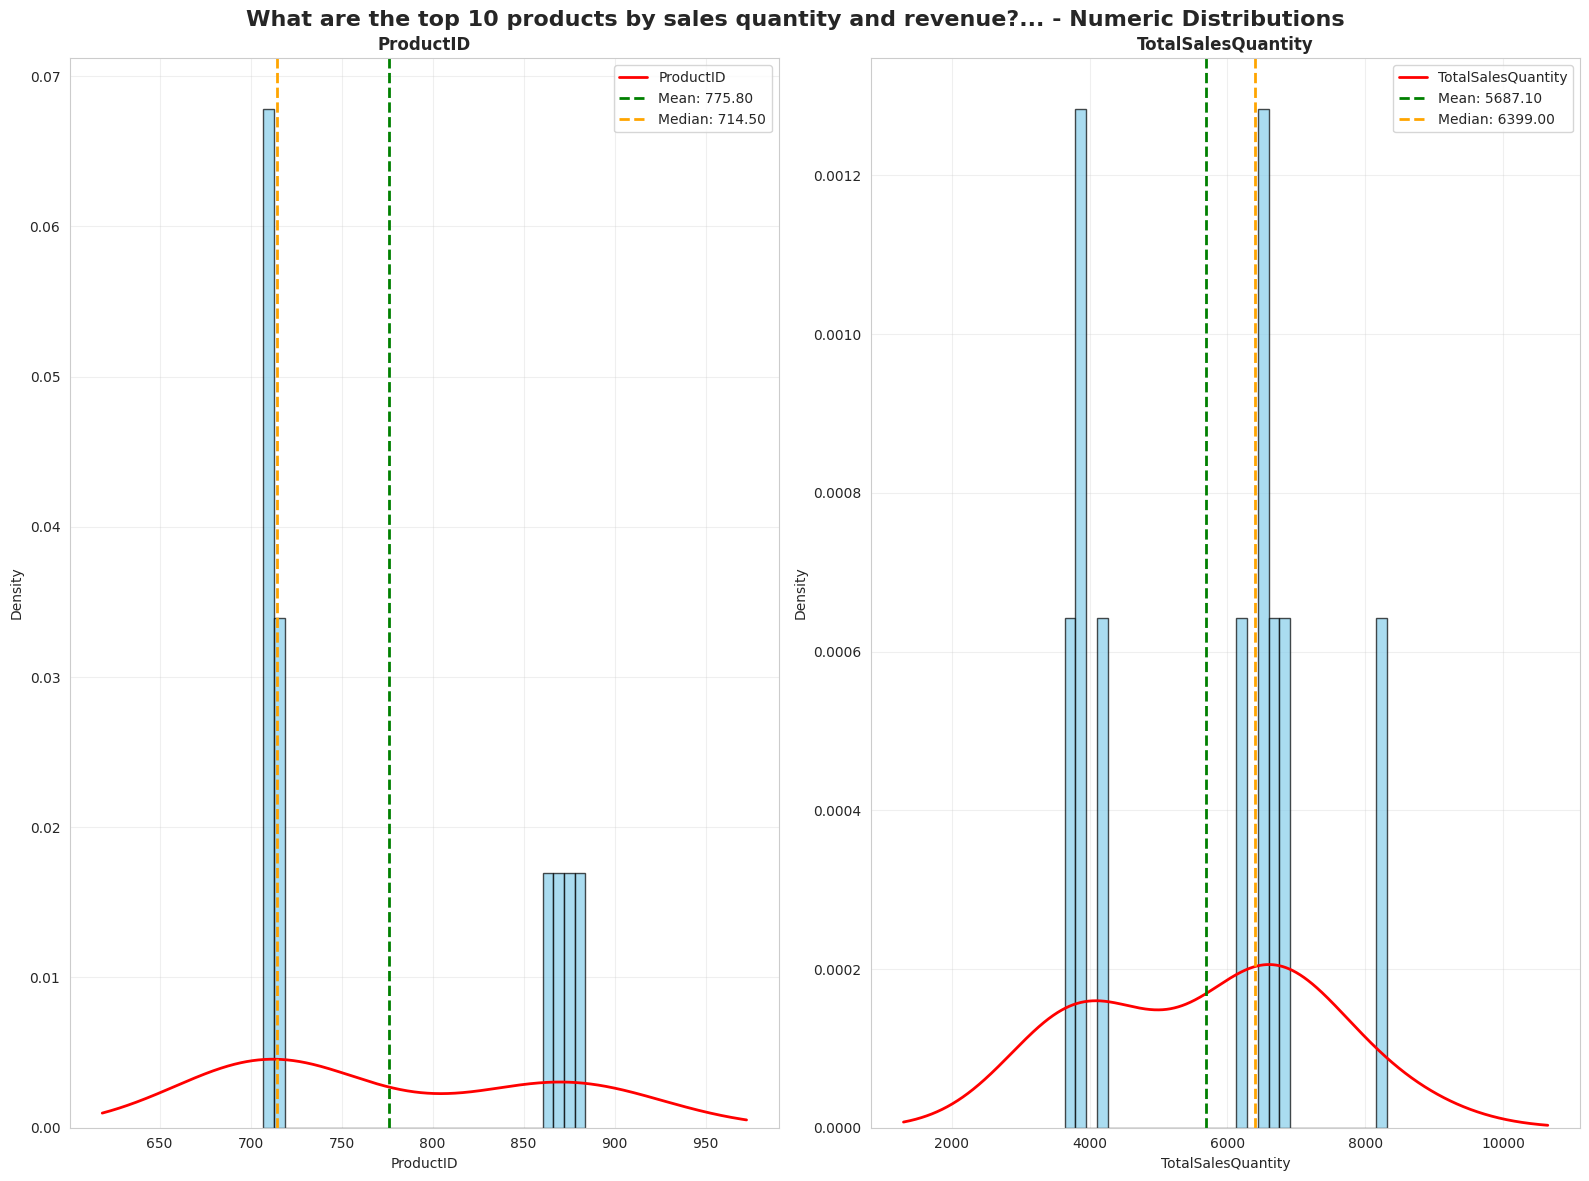

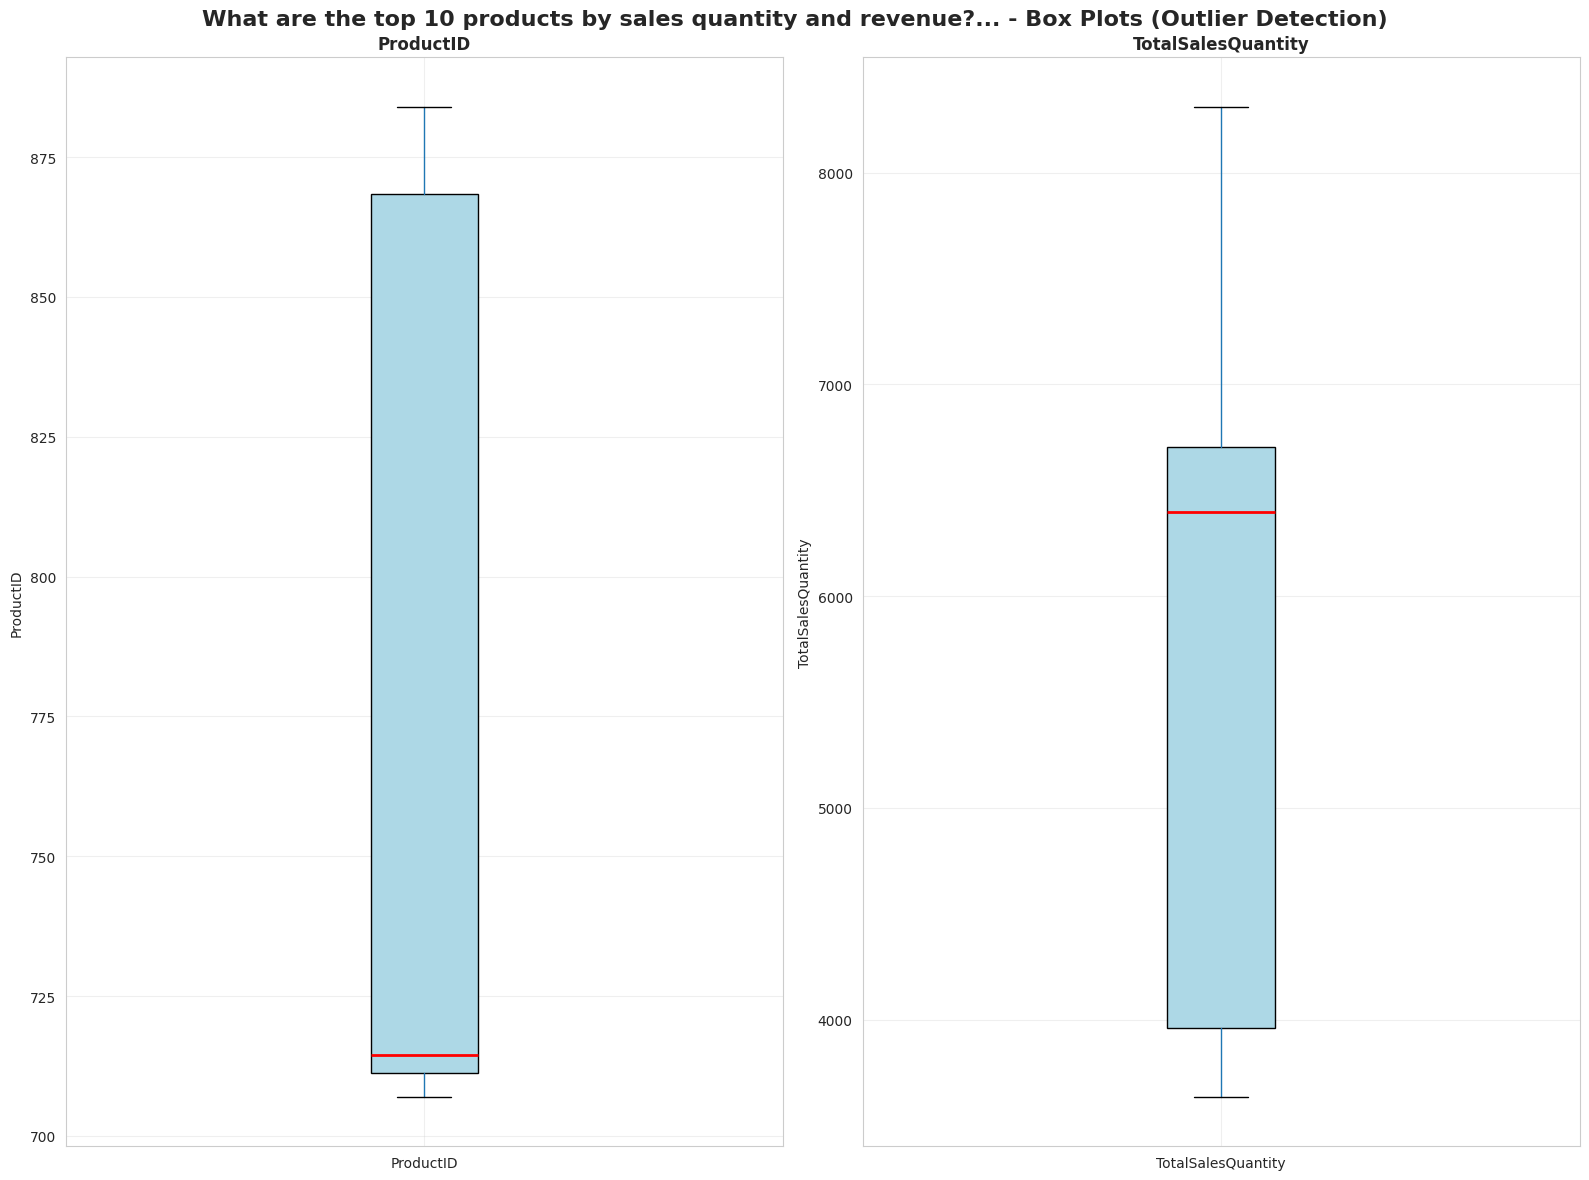

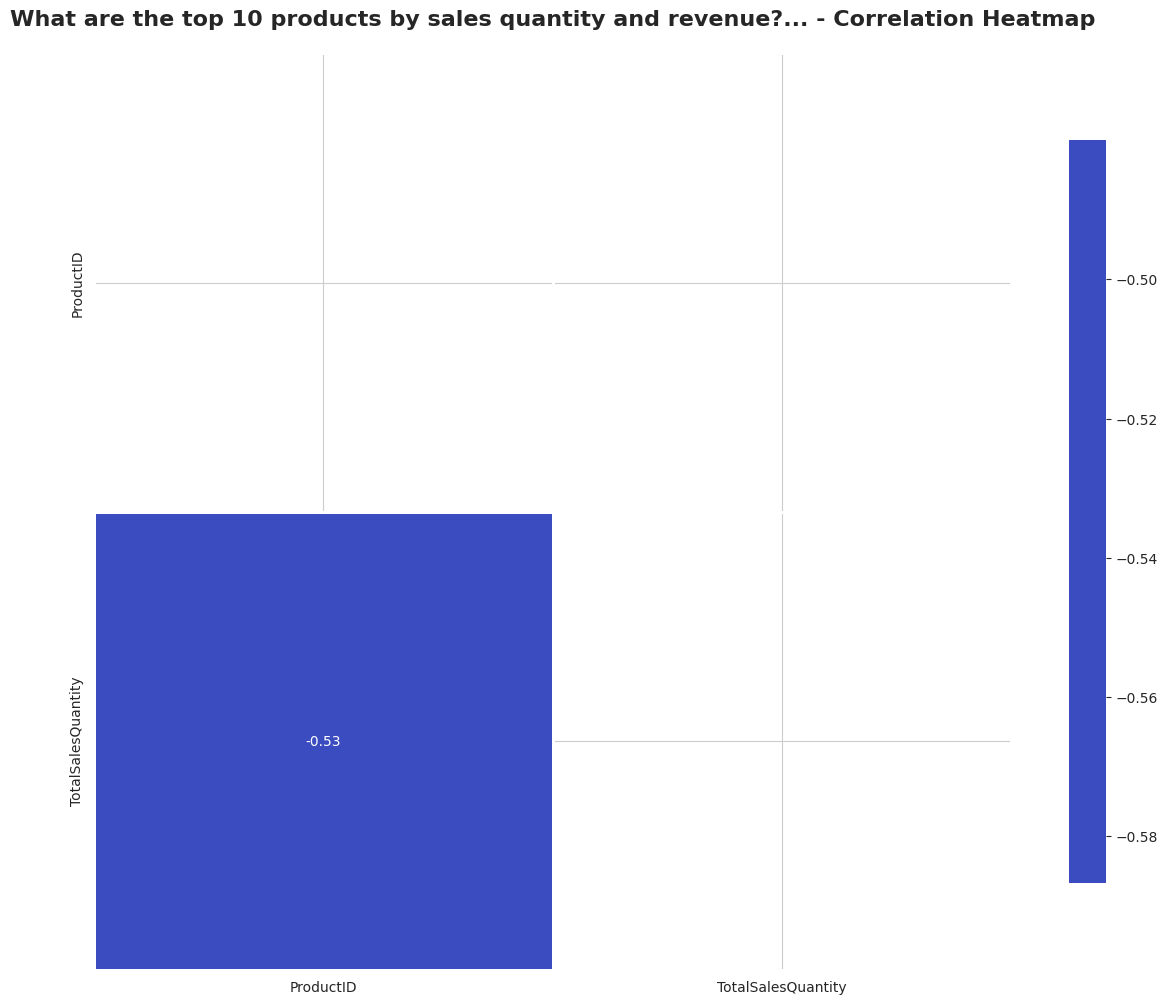


🔗 Strong Correlations (|r| > 0.5):
------------------------------------------------------------
  ProductID ↔ TotalSalesQuantity: -0.533

📋 SUMMARY STATISTICS TABLE
----------------------------------------------------------------------------------------------------


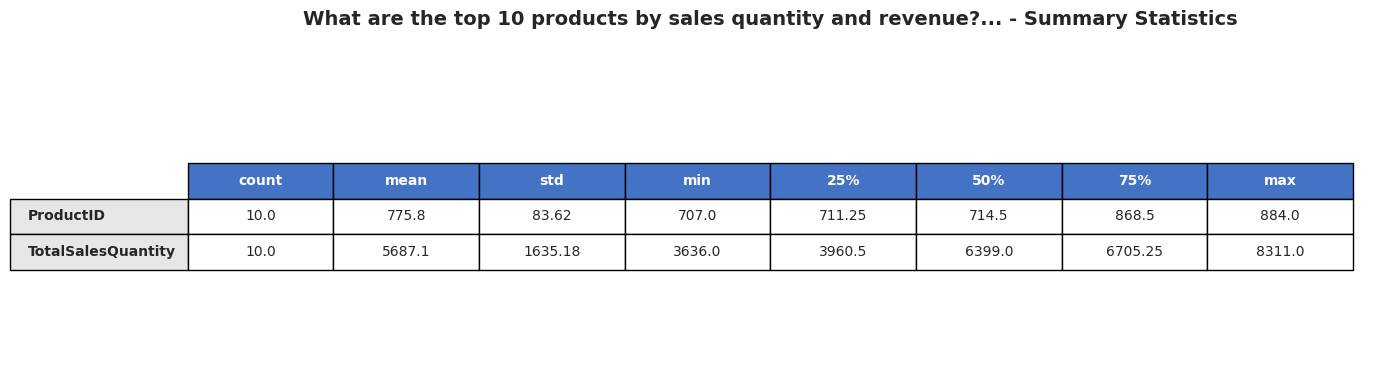


✅ Visualization complete!

✅ Phase 3 Complete: Visualizations created


🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
✅ PIPELINE COMPLETED SUCCESSFULLY!
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

📊 EXECUTIVE SUMMARY:
----------------------------------------------------------------------------------------------------
Query: What are the top 10 products by sales quantity and revenue?
SQL Generated: Yes
Data Retrieved: 10 rows × 2 columns
Statistical Analysis: Yes
Visualizations: Yes

Data Insights:
  • Numeric columns: 11
  • Categorical columns: 0
  • Missing values: 0
  • Outliers detected: 0
----------------------------------------------------------------------------------------------------

💾 Available Variables:
  • SQL Query: pipeline_result['sql_query']
  • DataFrame: pipeline_result['dataframe']
  • Analysis: analysis_results
  • Save data: pipeline_result['dataframe'].to_csv('results.csv', index=False)



📍 PHASE 4:

In [29]:
def complete_intelligence_pipeline(user_query, db_connector, 
                                  top_k=10, keyword_boost=1.0, semantic_boost=1.5,
                                  execute_sql=True, analyze=True, visualize=True, 
                                  generate_insights=True, max_rows_for_llm=100):
    """
    The ultimate end-to-end business intelligence pipeline.
    
    Complete workflow from natural language to actionable business insights:
    1. Natural language query → RAG-based metadata retrieval
    2. AI SQL query generation with DeepSeek
    3. Query execution on database
    4. Statistical analysis and data profiling
    5. Comprehensive visualizations
    6. AI-powered business insights and recommendations
    
    Parameters:
    -----------
    user_query : str
        Natural language business question
    db_connector : MSSQLConnector
        Database connector instance
    top_k : int
        Number of metadata entries to retrieve
    keyword_boost : float
        Boost for keyword search
    semantic_boost : float
        Boost for semantic search
    execute_sql : bool
        Whether to execute the SQL query
    analyze : bool
        Whether to perform statistical analysis
    visualize : bool
        Whether to create visualizations
    generate_insights : bool
        Whether to generate AI business insights
    max_rows_for_llm : int
        Maximum rows to send to LLM for insights
    
    Returns:
    --------
    dict : Complete results including data, analysis, visualizations, and insights
    """
    
    print("🌟" * 50)
    print("🚀 COMPLETE BUSINESS INTELLIGENCE PIPELINE")
    print("🌟" * 50)
    print(f"\n💬 Business Question: '{user_query}'\n")
    
    # ============================================================================
    # PHASE 1-3: Data Retrieval & Analysis
    # ============================================================================
    print("📍 PHASES 1-3: Data Retrieval, Analysis & Visualization")
    print("="*100)
    
    data_pipeline_result = complete_data_insights_pipeline(
        user_query=user_query,
        db_connector=db_connector,
        top_k=top_k,
        keyword_boost=keyword_boost,
        semantic_boost=semantic_boost,
        execute_sql=execute_sql,
        analyze=analyze,
        visualize=visualize
    )
    
    if not data_pipeline_result['success']:
        print("\n❌ Data pipeline failed. Cannot proceed with insights generation.")
        return data_pipeline_result
    
    df = data_pipeline_result.get('dataframe')
    
    if df is None or df.empty:
        print("\n⚠️  No data available for insights generation.")
        return data_pipeline_result
    
    # ============================================================================
    # PHASE 4: AI Business Insights
    # ============================================================================
    ai_insights = None
    if generate_insights and df is not None:
        print("\n📍 PHASE 4: AI-Powered Business Insights Generation")
        print("="*100)
        
        ai_insights = generate_business_insights(
            df=df,
            original_query=user_query,
            sql_query=data_pipeline_result.get('sql_query'),
            analysis_results=data_pipeline_result.get('analysis'),
            max_rows_to_send=max_rows_for_llm
        )
        
        if ai_insights and ai_insights['success']:
            print("\n✅ Phase 4 Complete: AI insights generated successfully")
        else:
            print("\n⚠️  Phase 4: Failed to generate AI insights")
    
    # ============================================================================
    # FINAL EXECUTIVE SUMMARY
    # ============================================================================
    print("\n" + "🌟" * 50)
    print("✅ COMPLETE INTELLIGENCE PIPELINE FINISHED!")
    print("🌟" * 50)
    
    print("\n📊 EXECUTIVE SUMMARY:")
    print("-"*100)
    print(f"Business Question: {user_query}")
    print(f"\nData Retrieved:")
    print(f"  • Rows: {len(df):,}")
    print(f"  • Columns: {len(df.columns)}")
    print(f"  • Column Names: {', '.join(df.columns.tolist())}")
    
    if data_pipeline_result.get('analysis'):
        analysis = data_pipeline_result['analysis']
        print(f"\nStatistical Analysis:")
        print(f"  • Numeric columns analyzed: {len(analysis.get('numeric_stats', {}))}")
        print(f"  • Categorical columns analyzed: {len(analysis.get('categorical_stats', {}))}")
        print(f"  • Missing values detected: {len(analysis.get('missing_values', []))}")
        print(f"  • Outliers detected: {len(analysis.get('outliers', {}))}")
    
    print(f"\nVisualizations: {'Generated' if visualize else 'Skipped'}")
    print(f"AI Insights: {'Generated' if (ai_insights and ai_insights['success']) else 'Skipped or Failed'}")
    
    if ai_insights and ai_insights['success']:
        print(f"\n💡 KEY INSIGHTS PREVIEW:")
        print("-"*100)
        if ai_insights['sections'].get('key_findings'):
            findings = ai_insights['sections']['key_findings']
            # Show first 300 characters
            preview = findings[:300] + "..." if len(findings) > 300 else findings
            print(preview)
    
    print("\n" + "-"*100)
    print("💾 AVAILABLE RESULTS:")
    print(f"  • Complete results: result")
    print(f"  • DataFrame: result['dataframe']")
    print(f"  • SQL Query: result['sql_query']")
    print(f"  • Analysis: result['analysis']")
    print(f"  • AI Insights: result['ai_insights']")
    print(f"  • Business Recommendations: result['ai_insights']['sections']['recommendations']")
    
    print("\n💡 QUICK ACTIONS:")
    print(f"  • Save data: result['dataframe'].to_csv('results.csv', index=False)")
    print(f"  • Save insights: with open('insights.txt', 'w') as f: f.write(result['ai_insights']['full_insights'])")
    
    print("\n" + "="*100 + "\n")
    
    # Return complete results
    return {
        **data_pipeline_result,
        'ai_insights': ai_insights,
        'pipeline_complete': True
    }


# ============================================================================
# EXAMPLE: Run Complete Intelligence Pipeline
# ============================================================================

print("🚀 Running Complete Business Intelligence Pipeline...\n")
print("This will execute all phases:")
print("  1️⃣  Text-to-SQL with RAG")
print("  2️⃣  Query Execution")
print("  3️⃣  Statistical Analysis")
print("  4️⃣  Data Visualizations")
print("  5️⃣  AI Business Insights\n")
print("-"*100 + "\n")

# Example query
intelligence_result = complete_intelligence_pipeline(
    user_query="Segment products based on their sales performance into high, medium, and low sales categories.",
    db_connector=db_connector,
    top_k=10,
    execute_sql=True,
    analyze=True,
    visualize=True,
    generate_insights=True,
    max_rows_for_llm=50
)

# Access the complete results
if intelligence_result.get('pipeline_complete'):
    print("\n" + "="*100)
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*100)
    
    # Quick access variables
    final_data = intelligence_result['dataframe']
    final_sql = intelligence_result['sql_query']
    final_analysis = intelligence_result.get('analysis')
    final_insights = intelligence_result.get('ai_insights')
    
    print("\n📦 Results stored in: intelligence_result")
    print("📊 Quick access variables created:")
    print("   - final_data (DataFrame)")
    print("   - final_sql (SQL query)")
    print("   - final_analysis (statistical analysis)")
    print("   - final_insights (AI insights)")
    
else:
    print("\n❌ Pipeline incomplete. Check error messages above.")

## Try Your Own Questions

Use this cell to ask your own business questions and get complete intelligence reports.

🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🚀 COMPLETE BUSINESS INTELLIGENCE PIPELINE
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

💬 Business Question: '
Which product categories have the highest profit margins, 
and what recommendations can you provide to improve underperforming categories?
'

📍 PHASES 1-3: Data Retrieval, Analysis & Visualization
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🚀 COMPLETE DATA INSIGHTS PIPELINE
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

💬 User Query: '
Which product categories have the highest profit margins, 
and what recommendations can you provide to improve underperforming categories?
'

📍 PHASE 1: Text-to-SQL Generation
🌟==================================================================================================🌟
🚀 COMPLETE RAG TEXT-TO-SQL PIPELINE WITH EXECUTION
🌟==================================================================================================🌟

💬 User Query: '
Which product categories have the hi

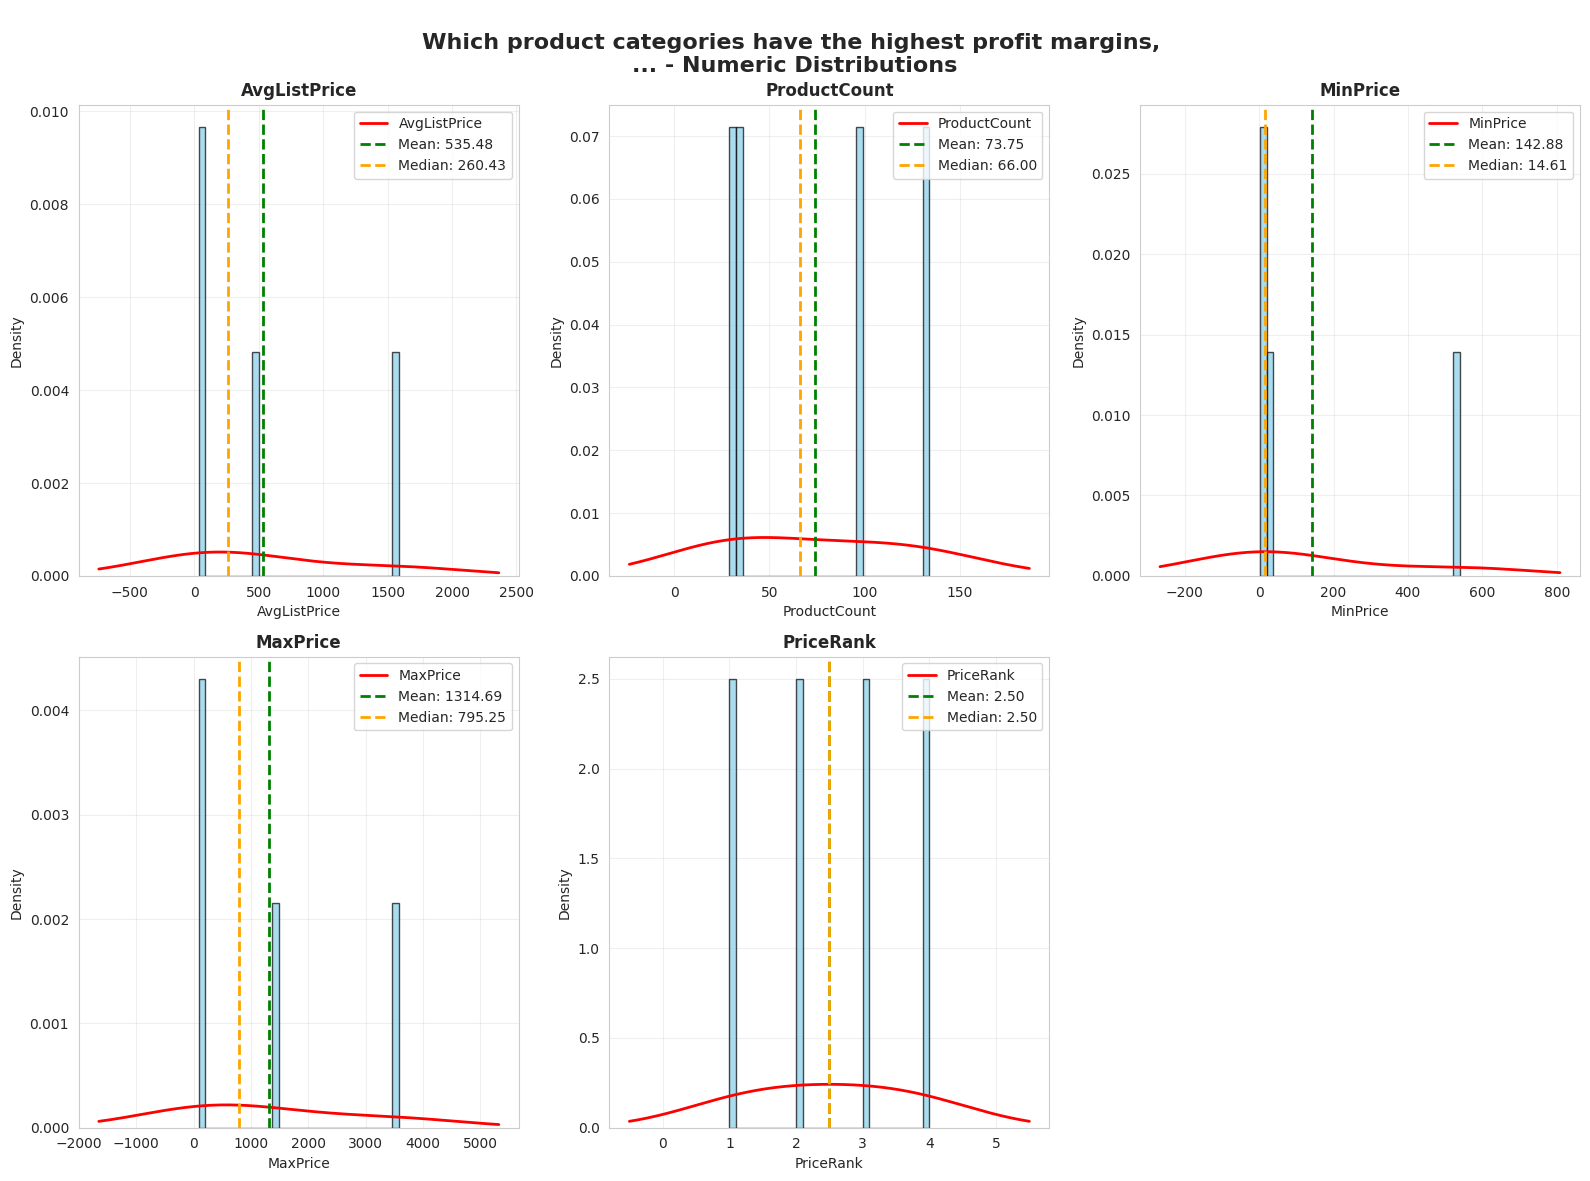

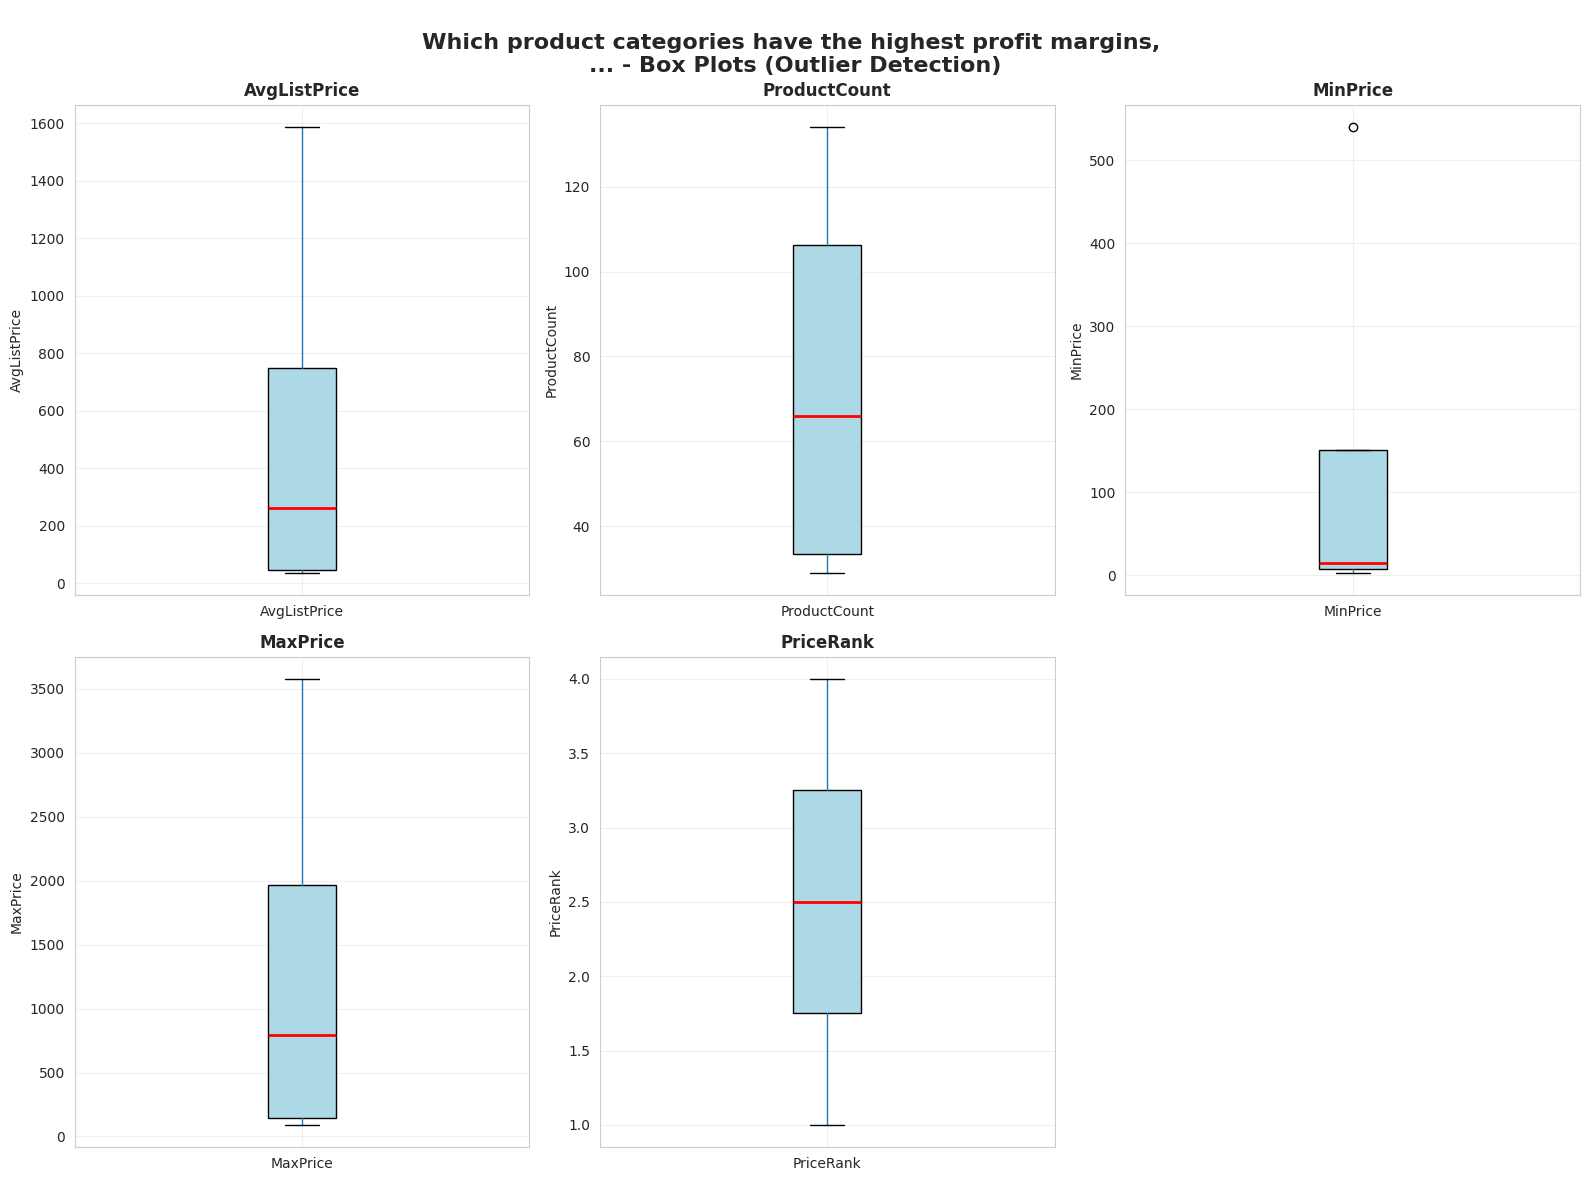

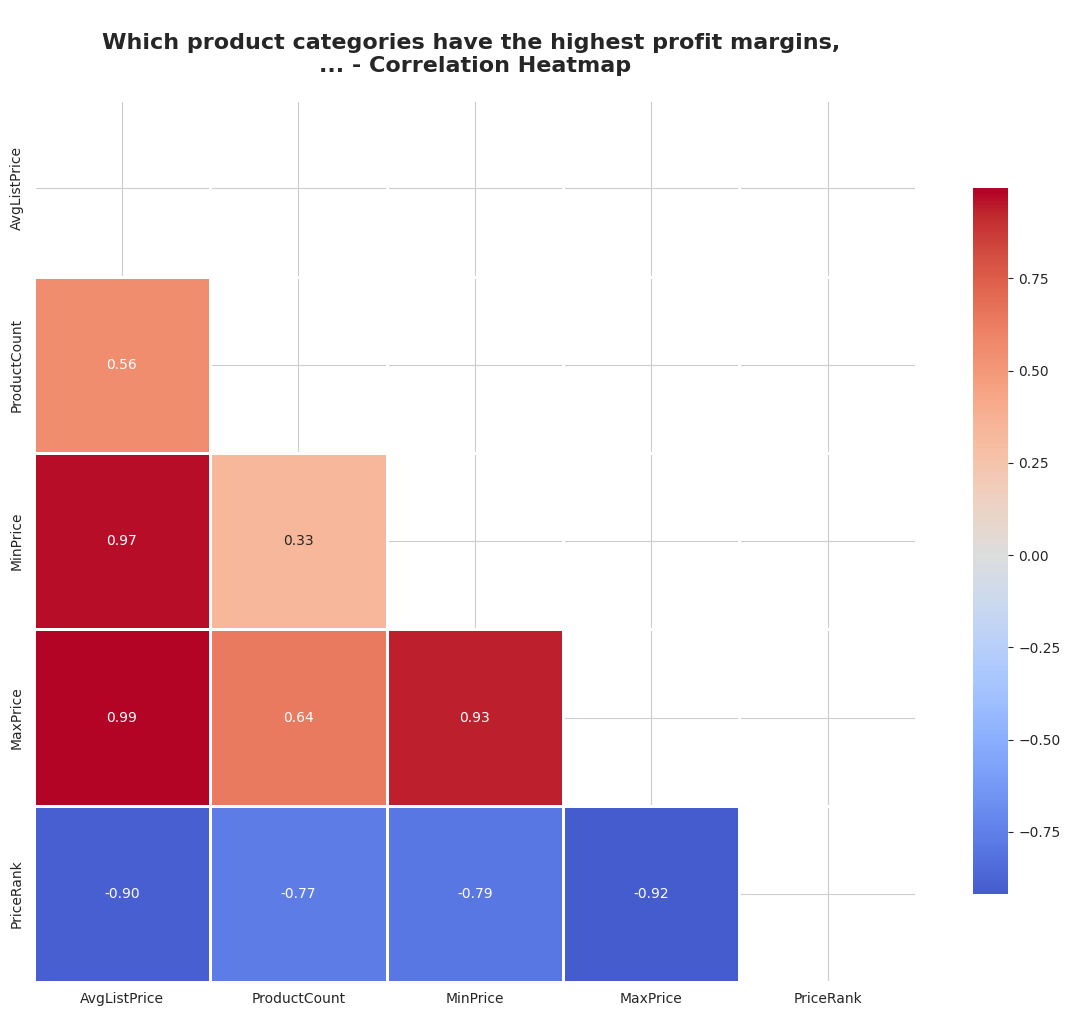


🔗 Strong Correlations (|r| > 0.5):
------------------------------------------------------------
  AvgListPrice ↔ MaxPrice: 0.994
  AvgListPrice ↔ MinPrice: 0.968
  MinPrice ↔ MaxPrice: 0.935
  MaxPrice ↔ PriceRank: -0.919
  AvgListPrice ↔ PriceRank: -0.899
  MinPrice ↔ PriceRank: -0.792
  ProductCount ↔ PriceRank: -0.773
  ProductCount ↔ MaxPrice: 0.642
  AvgListPrice ↔ ProductCount: 0.557

📊 Visualizing 3 categorical column(s)...



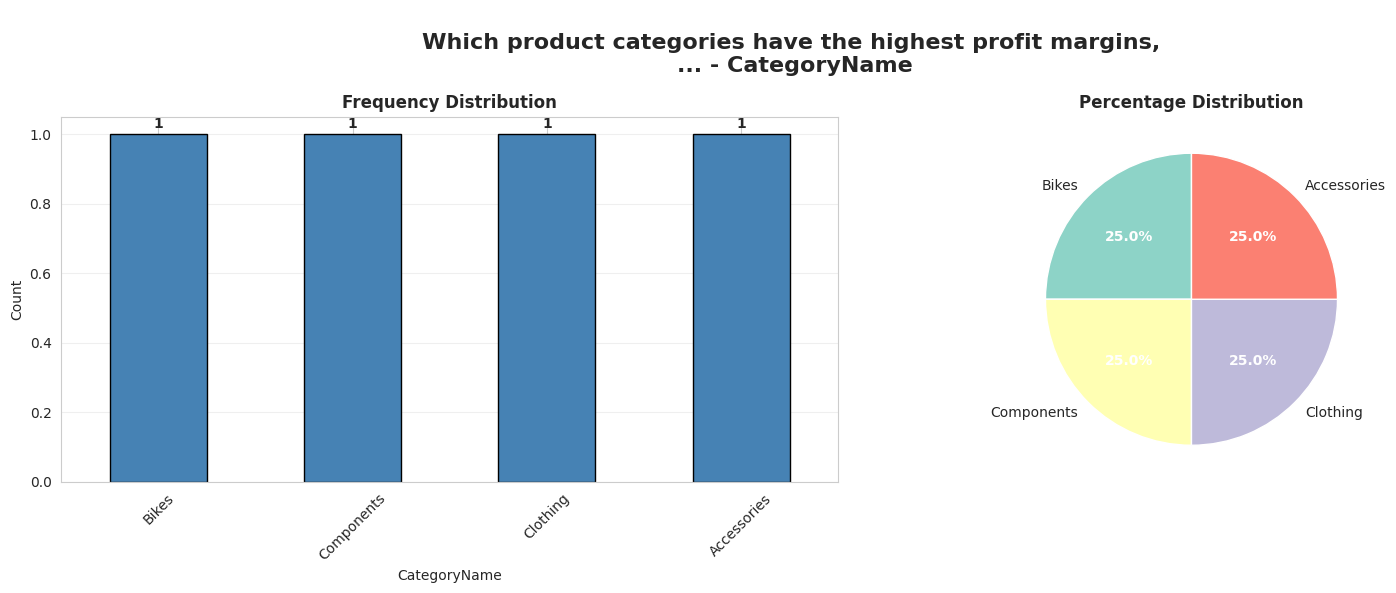

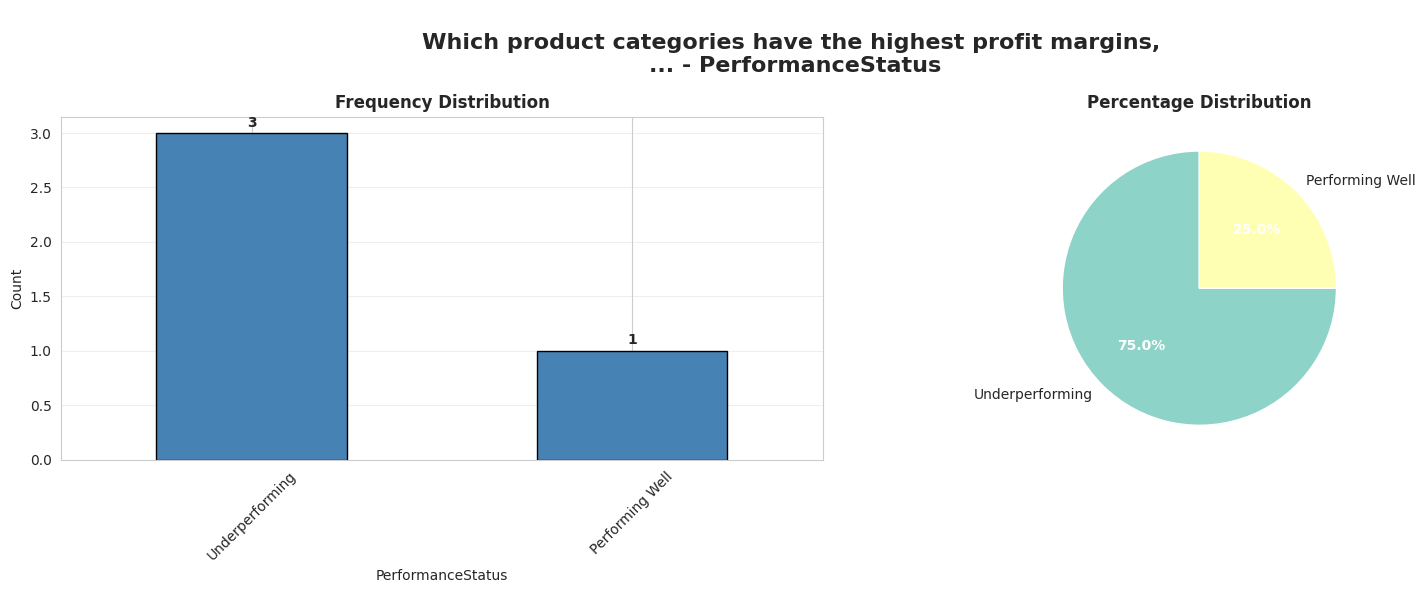

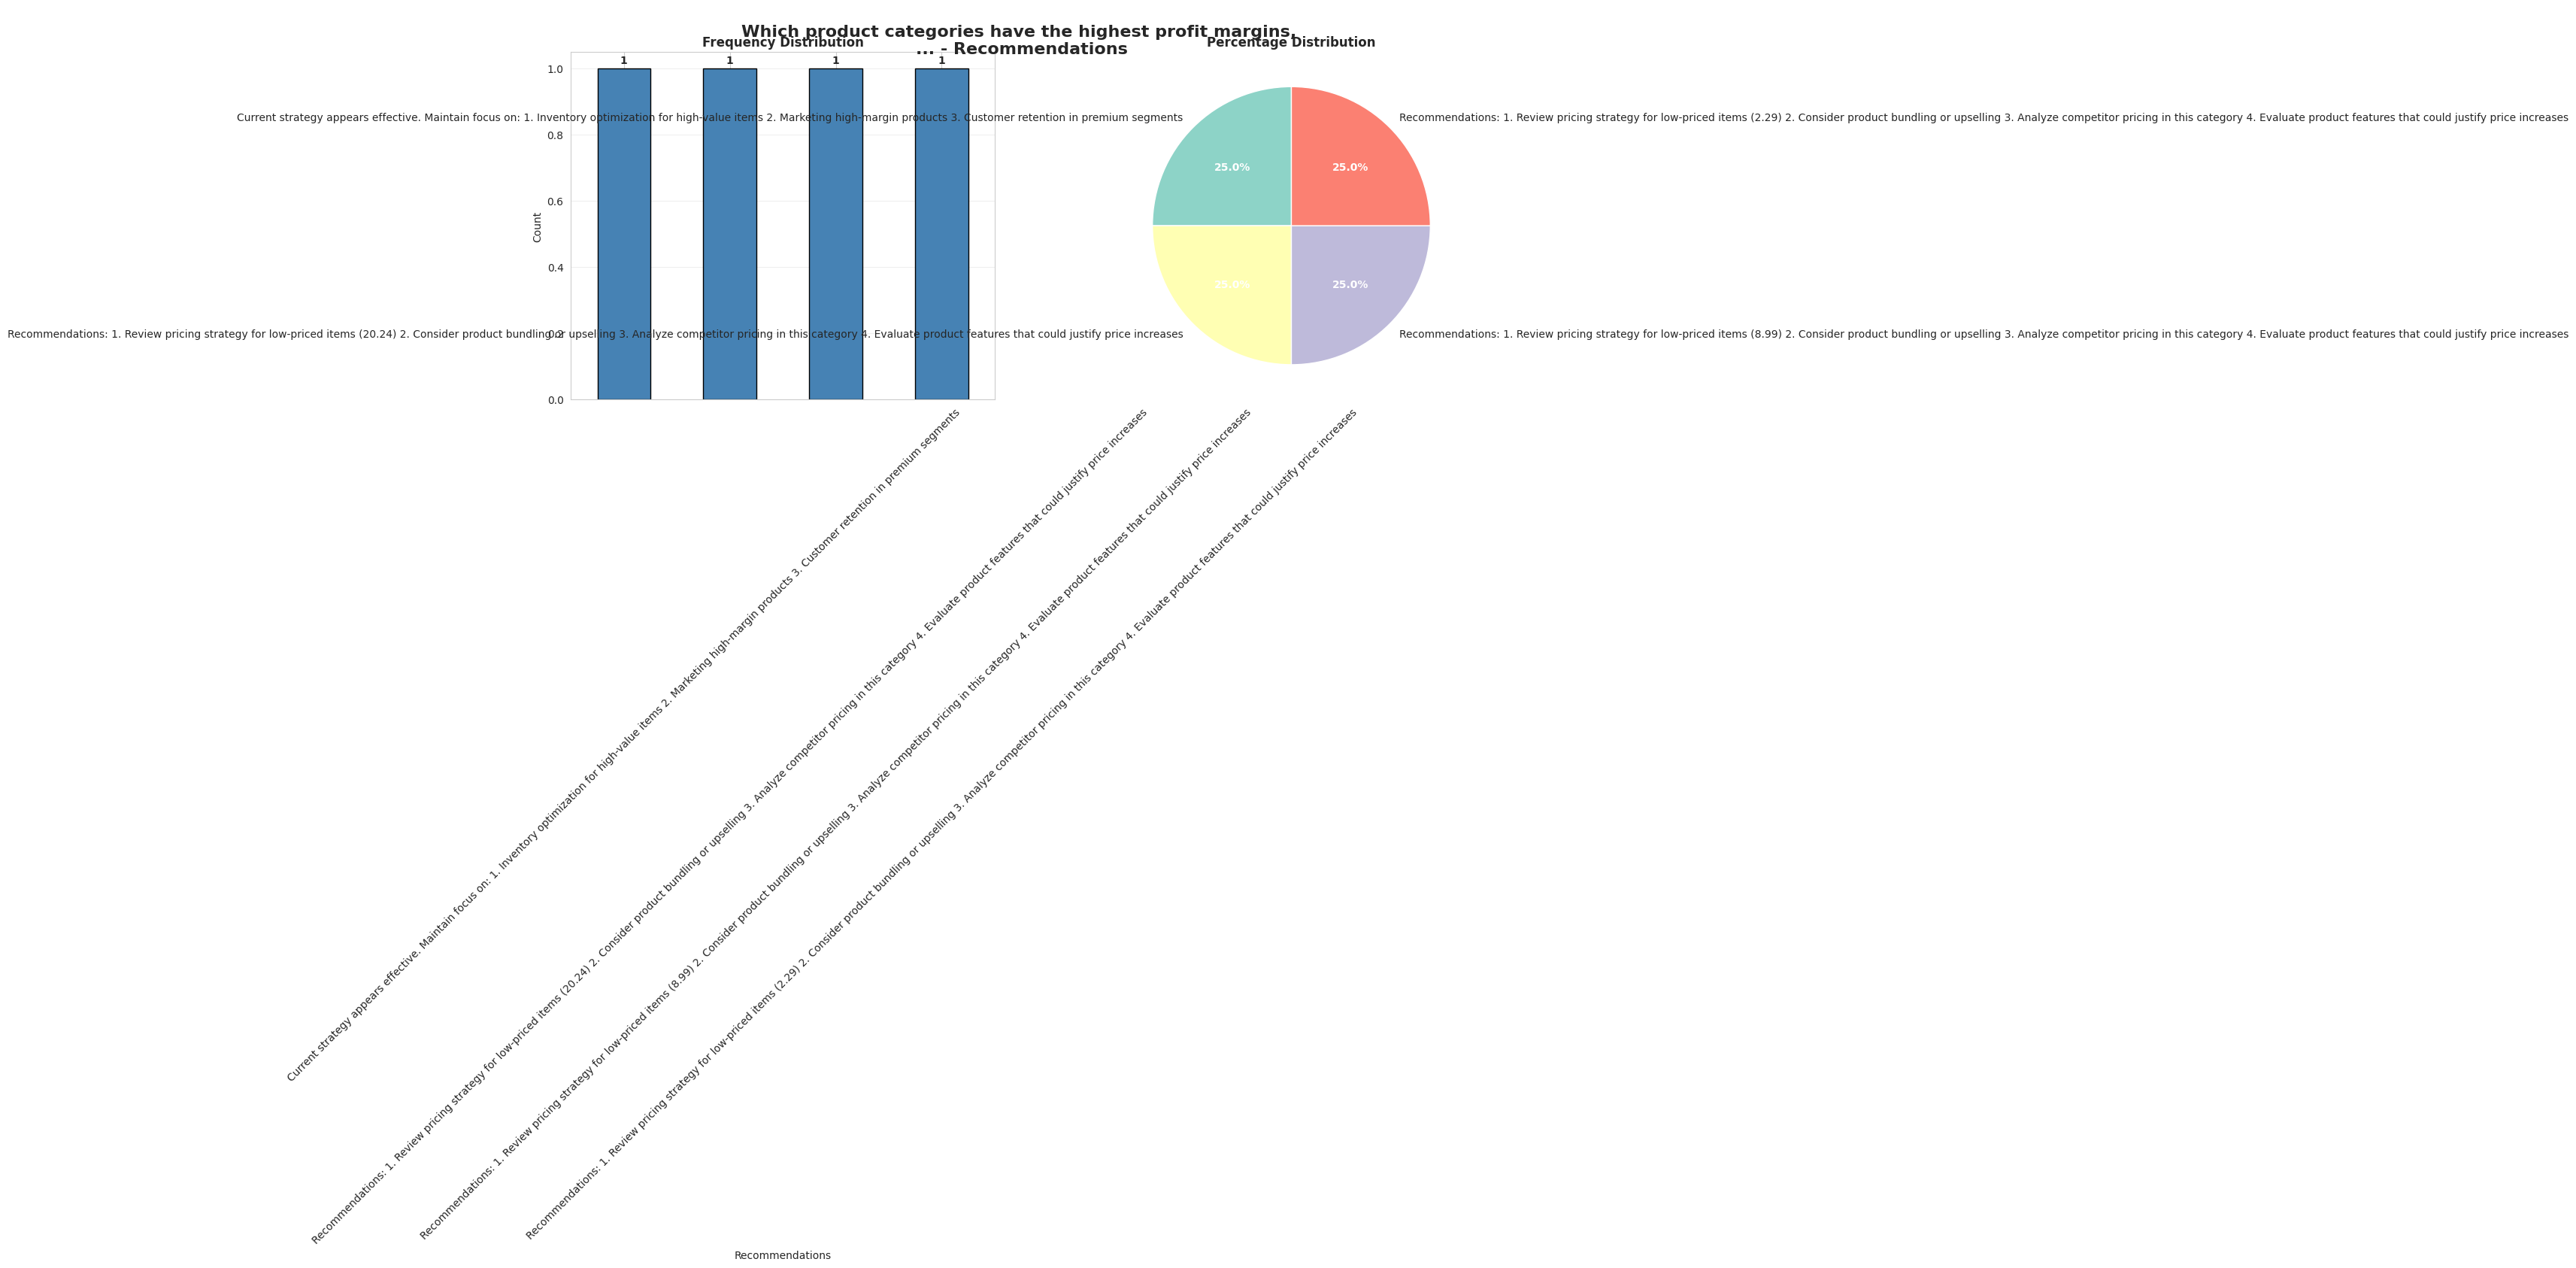


📋 SUMMARY STATISTICS TABLE
----------------------------------------------------------------------------------------------------


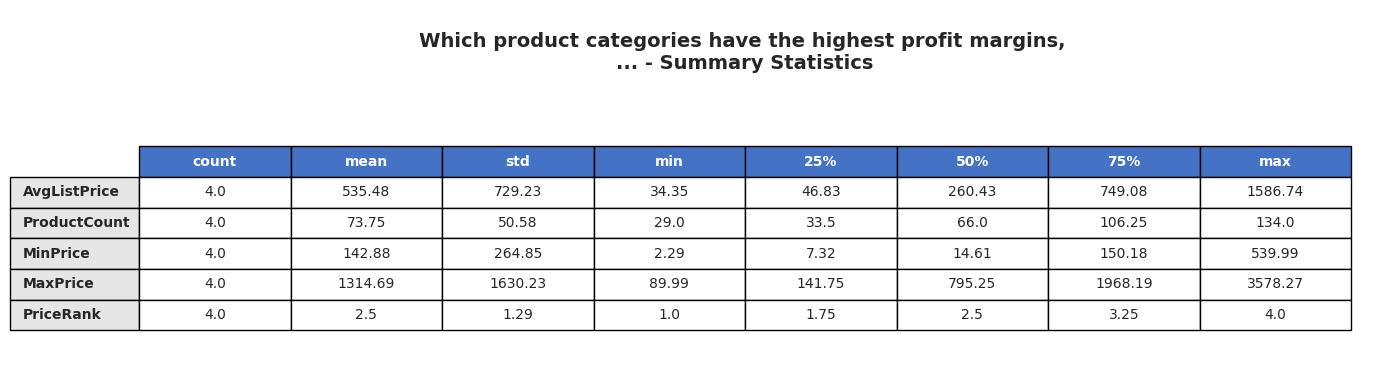


✅ Visualization complete!

✅ Phase 3 Complete: Visualizations created


🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
🌟
✅ PIPELINE COMPLETED SUCCESSFULLY!
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

📊 EXECUTIVE SUMMARY:
----------------------------------------------------------------------------------------------------
Query: 
Which product categories have the highest profit margins, 
and what recommendations can you provide to improve underperforming categories?

SQL Generated: Yes
Data Retrieved: 4 rows × 8 columns
Statistical Analysis: Yes
Visualizations: Yes

Data Insights:
  • Numeric columns: 11
  • Categorical columns: 3
  • Missing values: 0
  • Outliers detected: 1
----------------------------------------------------------------------------------------------------

💾 Available Variables:
  • SQL Query: pipeline_result['sql_query']
  • DataFrame: pipeline_result['dataframe']
  • Analysis: analysis_results
  • Save dat

In [30]:
# Ask your own business question
my_business_question = """
Which product categories have the highest profit margins, 
and what recommendations can you provide to improve underperforming categories?
"""

# Run the complete intelligence pipeline
my_result = complete_intelligence_pipeline(
    user_query=my_business_question,
    db_connector=db_connector,
    top_k=12,
    execute_sql=True,
    analyze=True,
    visualize=True,
    generate_insights=True,
    max_rows_for_llm=75
)

# Display key insights if successful
if my_result.get('pipeline_complete') and my_result.get('ai_insights'):
    print("\n" + "="*100)
    print("📋 EXECUTIVE SUMMARY OF KEY INSIGHTS")
    print("="*100)
    
    insights = my_result['ai_insights']
    
    if insights['sections'].get('key_findings'):
        print("\n🔍 KEY FINDINGS:")
        print("-"*100)
        print(insights['sections']['key_findings'])
    
    if insights['sections'].get('recommendations'):
        print("\n💡 RECOMMENDATIONS:")
        print("-"*100)
        print(insights['sections']['recommendations'])
    
    print("\n" + "="*100)

## Generate Insights for Existing Data

Use this if you already have a DataFrame and want to generate business insights without re-running queries.

In [31]:
# Generate insights from existing DataFrame
# Useful if you've already run queries and want to generate insights

if 'final_data' in locals() and final_data is not None:
    print("🔄 Generating insights for existing data...\n")
    
    standalone_insights = generate_business_insights(
        df=final_data,
        original_query="Analysis of existing data",
        sql_query=None,
        analysis_results=None,
        max_rows_to_send=100
    )
    
    if standalone_insights and standalone_insights['success']:
        print("\n✅ Insights generated successfully!")
        print("\n" + "="*100)
        print("💡 FULL INSIGHTS:")
        print("="*100)
        print(standalone_insights['full_insights'])
        print("="*100)
    
else:
    print("⚠️  No DataFrame available.")
    print("\nOptions:")
    print("  1. Run complete_intelligence_pipeline() first")
    print("  2. Or load your own DataFrame:")
    print("     my_df = pd.read_csv('your_data.csv')")
    print("     generate_business_insights(my_df, 'Describe your data')")

🔄 Generating insights for existing data...

🤖 GENERATING AI-POWERED BUSINESS INSIGHTS

📊 Analyzing 10 rows × 2 columns
📝 Original Query: 'Analysis of existing data'

⏳ Generating insights with DeepSeek LLM...
✅ Insights generated successfully!

💡 AI-POWERED BUSINESS INSIGHTS & RECOMMENDATIONS

📊 Query: Analysis of existing data

KEY FINDINGS:
- **Significant sales performance disparity**: Top-performing product (ProductID 712) sells 128% more than the lowest performer (ProductID 714)
- **Clear performance tiers**: Products naturally cluster into high-performers (6,266-8,311 units) and low-performers (3,636-4,247 units)
- **High variability in sales**: Standard deviation of 1,635 units indicates inconsistent performance across the product portfolio
- **No obvious correlation between ProductID and sales**: Product numbering doesn't predict performance (e.g., ProductID 707-715 show both high and low performers)

BUSINESS INSIGHTS:
- **Portfolio imbalance**: The business is heavily depende